In [184]:
import statsmodels.api as sm #for OLS regression
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt #for heatmap plotting
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns #for heatmap plotting
from statsmodels.iolib.summary2 import summary_col #to summarize multiple regressions in one table

In [185]:
p25 = pd.read_csv('C:/Users/yzou/Desktop/25_Porfolio.csv')
ff3 = pd.read_csv('C:/Users/yzou/Desktop/3 factor.csv')

In [186]:
p25.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)
ff3.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)

In [187]:
#to convert to decile format and get excess returns
ff3.iloc[:,1:ff3.shape[1]] = ff3.iloc[:,1:ff3.shape[1]]/100
p25_excess=(p25.iloc[:,1:p25.shape[1]]/100).sub(ff3.RF,axis=0)
print(p25_excess.head())

   SMALL LoBM   ME1 BM2   ME1 BM3   ME1 BM4  SMALL HiBM   ME2 BM1   ME2 BM2  \
0    0.035582 -0.006319 -0.021634  0.001330    0.018334  0.019704  0.021992   
1   -0.024574 -0.089775  0.021904  0.003586    0.081468  0.019209 -0.014349   
2   -0.064413 -0.005289 -0.064282 -0.018668    0.006349 -0.020850 -0.014918   
3   -0.089441 -0.040732 -0.059919  0.053970   -0.028676 -0.021195 -0.035863   
4    0.031644  0.063376  0.019534 -0.050120    0.002262  0.025951 -0.026790   

    ME2 BM3   ME2 BM4   ME2 BM5    ...      ME4 BM1   ME4 BM2   ME4 BM3  \
0  0.002726 -0.017970 -0.005544    ...     0.013693  0.013078  0.009669   
1  0.037584  0.002143  0.059175    ...     0.010836  0.036230  0.017559   
2  0.008529 -0.032705 -0.011701    ...     0.008623 -0.007550 -0.019614   
3 -0.053945 -0.083650 -0.016413    ...    -0.036561 -0.029759 -0.023516   
4  0.026978  0.043549  0.024192    ...     0.031348  0.020787  0.034303   

    ME4 BM4   ME4 BM5  BIG LoBM   ME5 BM2   ME5 BM3   ME5 BM4  BIG HiBM  


In [188]:
#YYMM as timestamp
ff3['YYMM'] = pd.to_datetime(ff3['YYMM'],yearfirst=True, format='%Y%m')
p25_excess['YYMM'] = pd.to_datetime(p25['YYMM'],yearfirst=True, format='%Y%m')

In [189]:
#change timestamps to index and delete unnecessary columns
ff3.index = ff3['YYMM']
p25_excess.index = p25_excess['YYMM']
ff3 = ff3.drop('YYMM', axis = 1)
p25_excess = p25_excess.drop('YYMM', axis = 1)
ff3 = ff3.drop('RF', axis = 1)

In [190]:
#calculate average excess return for the 25 porfolios over the whole history
avg_return = p25_excess.mean(axis = 0)
avg_return = avg_return.as_matrix(columns = None)
avg_return = pd.DataFrame(avg_return.reshape((5,5)))
avg_return.rename(columns = {0:'Market Size 0', 1:'Market Size 1', 2: 'Market Size 2', 3:'Market Size 3',4:'Market Size 4'}, inplace = True) 
avg_return.rename(index = {0:'B/M 0', 1:'B/M 1', 2: 'B/M 2', 3:'B/M 3',4:'B/M 4'}, inplace = True)

print(avg_return)
type(avg_return)

       Market Size 0  Market Size 1  Market Size 2  Market Size 3  \
B/M 0       0.005827       0.006958       0.009895       0.011676   
B/M 1       0.006415       0.009339       0.009817       0.010513   
B/M 2       0.007159       0.009111       0.009241       0.010141   
B/M 3       0.007398       0.007629       0.008582       0.009587   
B/M 4       0.006404       0.006379       0.007056       0.006493   

       Market Size 4  
B/M 0       0.013425  
B/M 1       0.012262  
B/M 2       0.011239  
B/M 3       0.010252  
B/M 4       0.009476  


C:\Users\yzou\AppData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


pandas.core.frame.DataFrame

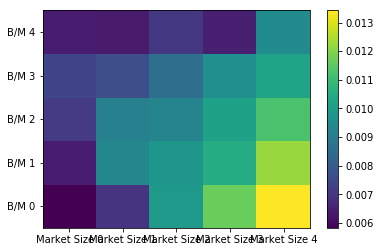

In [191]:
#plot the average excess return of 25 portfolios in a heatmap
plt.pcolor(avg_return)
plt.yticks(np.arange(0.5, len(avg_return.index), 1), avg_return.index)
plt.xticks(np.arange(0.5, len(avg_return.columns), 1), avg_return.columns)
plt.colorbar()
plt.show() 

In [192]:
t0 = '1963-7-1'
t1 = str(int(t0[:4])+1)+t0[4:8]
print(t1)
window = 10
n_window = 2019 - 1963 - window + 1
print(n_window)

1964-7-1
47


In [193]:
#To run OLS on a 10-year rolling window basis. The logic of this loop is to run the rolling window regressions 
#for each of the 25 portfolios. That is, the first 47 models are for the portfolio "small-size and lowest BM",
#the next 47 models are for the portfolio "small-size and second lowest BM"
models = []
for i in range (25):
    for m in range(n_window):
        
        start = str(int(t0[:4])+ m)+t0[4:8]
        if int(start[:4])+10 < 2019:
            end = str(int(start[:4])+ 10)+t0[4:8]
        else:
            end = p25_excess.index[-1]
        
        x = ff3[start:end]
        x = sm.add_constant(x)
        y = p25_excess[start:end]
        reg = sm.OLS(y.iloc[:,i], x)
        
        models.append(reg.fit())

In [194]:
print(models[1].summary())

                            OLS Regression Results                            
Dep. Variable:             SMALL LoBM   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     795.5
Date:                Wed, 03 Jul 2019   Prob (F-statistic):           1.27e-77
Time:                        21:55:25   Log-Likelihood:                 311.12
No. Observations:                 121   AIC:                            -614.2
Df Residuals:                     117   BIC:                            -603.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.762      0.0

In [195]:
#To create the name, i.e. the corresponding time period, for each window
print(len(models))
print(25*n_window)

window_nm = []
for i in range(n_window):
    start = str(int(t0[:4])+ i)
    nm = start + '-' + str(int(start[:4])+ 10)
    window_nm.append(nm)
    
print(window_nm)

1175
1175
['1963-1973', '1964-1974', '1965-1975', '1966-1976', '1967-1977', '1968-1978', '1969-1979', '1970-1980', '1971-1981', '1972-1982', '1973-1983', '1974-1984', '1975-1985', '1976-1986', '1977-1987', '1978-1988', '1979-1989', '1980-1990', '1981-1991', '1982-1992', '1983-1993', '1984-1994', '1985-1995', '1986-1996', '1987-1997', '1988-1998', '1989-1999', '1990-2000', '1991-2001', '1992-2002', '1993-2003', '1994-2004', '1995-2005', '1996-2006', '1997-2007', '1998-2008', '1999-2009', '2000-2010', '2001-2011', '2002-2012', '2003-2013', '2004-2014', '2005-2015', '2006-2016', '2007-2017', '2008-2018', '2009-2019']


In [196]:
#to summarize the 47 regression results for the 1st portfolio in one table
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}
results_table = summary_col(results= [models[0],models[1],models[2],models[3],models[4],models[5],models[6],models[7],models[8],
                             models[9],models[10],models[11],models[12],models[13],models[14],models[15],models[16],models[17],
                             models[18],models[19],models[20],models[21],models[22],models[23],models[24],models[25],models[26],models[27],
                             models[28],models[29],models[30],models[31],models[32],models[33],models[34],models[35],models[36],models[37],
                             models[38],models[39],models[40],models[41],models[42],models[43],models[44],models[45],models[46]],
                            stars = False,
                            model_names=window_nm,
                            float_format ="%.2f",
                            info_dict = info_dict
                           )

results_table.add_title('Table - OLS Regressions')

print(results_table)


                                                                                                                                                                                                                                       Table - OLS Regressions
                 1963-1973 1964-1974 1965-1975 1966-1976 1967-1977 1968-1978 1969-1979 1970-1980 1971-1981 1972-1982 1973-1983 1974-1984 1975-1985 1976-1986 1977-1987 1978-1988 1979-1989 1980-1990 1981-1991 1982-1992 1983-1993 1984-1994 1985-1995 1986-1996 1987-1997 1988-1998 1989-1999 1990-2000 1991-2001 1992-2002 1993-2003 1994-2004 1995-2005 1996-2006 1997-2007 1998-2008 1999-2009 2000-2010 2001-2011 2002-2012 2003-2013 2004-2014 2005-2015 2006-2016 2007-2017 2008-2018 2009-2019
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [197]:
#To extract the constant terms of the 47 regressions of the 1st portfolio
ts_1_1_cons = pd.Series([models[0].params[0],models[1].params[0],models[2].params[0],models[3].params[0],models[4].params[0],models[5].params[0],models[6].params[0],models[7].params[0],models[8].params[0],
                             models[9].params[0],models[10].params[0],models[11].params[0],models[12].params[0],models[13].params[0],models[14].params[0],models[15].params[0],models[16].params[0],models[17].params[0],
                             models[18].params[0],models[19].params[0],models[20].params[0],models[21].params[0],models[22].params[0],models[23].params[0],models[24].params[0],models[25].params[0],models[26].params[0],models[27].params[0],
                             models[28].params[0],models[29].params[0],models[30].params[0],models[31].params[0],models[32].params[0],models[33].params[0],models[34].params[0],models[35].params[0],models[36].params[0],models[37].params[0],
                             models[38].params[0],models[39].params[0],models[40].params[0],models[41].params[0],models[42].params[0],models[43].params[0],models[44].params[0],models[45].params[0],models[46].params[0]],index = window_nm)

In [198]:
#To extract the coefficient of Mkt-Rf of the 47 regressions of the 1st portfolio
ts_1_1_Mkt = pd.Series([models[0].params[1],models[1].params[1],models[2].params[1],models[3].params[1],models[4].params[1],models[5].params[1],models[6].params[1],models[7].params[1],models[8].params[1],
                             models[9].params[1],models[10].params[1],models[11].params[1],models[12].params[1],models[13].params[1],models[14].params[1],models[15].params[1],models[16].params[1],models[17].params[1],
                             models[18].params[1],models[19].params[1],models[20].params[1],models[21].params[1],models[22].params[1],models[23].params[1],models[24].params[1],models[25].params[1],models[26].params[1],models[27].params[1],
                             models[28].params[1],models[29].params[1],models[30].params[1],models[31].params[1],models[32].params[1],models[33].params[1],models[34].params[1],models[35].params[1],models[36].params[1],models[37].params[1],
                             models[38].params[1],models[39].params[1],models[40].params[1],models[41].params[1],models[42].params[1],models[43].params[1],models[44].params[1],models[45].params[1],models[46].params[1]],index = window_nm)

In [199]:
#To extract the coefficient of SMB of the 47 regressions of the 1st portfolio
ts_1_1_SMB = pd.Series([models[0].params[2],models[1].params[2],models[2].params[2],models[3].params[2],models[4].params[2],models[5].params[2],models[6].params[2],models[7].params[2],models[8].params[2],
                             models[9].params[2],models[10].params[2],models[11].params[2],models[12].params[2],models[13].params[2],models[14].params[2],models[15].params[2],models[16].params[2],models[17].params[2],
                             models[18].params[2],models[19].params[2],models[20].params[2],models[21].params[2],models[22].params[2],models[23].params[2],models[24].params[2],models[25].params[2],models[26].params[2],models[27].params[2],
                             models[28].params[2],models[29].params[2],models[30].params[2],models[31].params[2],models[32].params[2],models[33].params[2],models[34].params[2],models[35].params[2],models[36].params[2],models[37].params[2],
                             models[38].params[2],models[39].params[2],models[40].params[2],models[41].params[2],models[42].params[2],models[43].params[2],models[44].params[2],models[45].params[2],models[46].params[2]], index = window_nm)

In [200]:
#To extract the coefficient of HML of the 47 regressions of the 1st portfolio
ts_1_1_HML = pd.Series([models[0].params[3],models[1].params[3],models[2].params[3],models[3].params[3],models[4].params[3],models[5].params[3],models[6].params[3],models[7].params[3],models[8].params[3],
                             models[9].params[3],models[10].params[3],models[11].params[3],models[12].params[3],models[13].params[3],models[14].params[3],models[15].params[3],models[16].params[3],models[17].params[3],
                             models[18].params[3],models[19].params[3],models[20].params[3],models[21].params[3],models[22].params[3],models[23].params[3],models[24].params[3],models[25].params[3],models[26].params[3],models[27].params[3],
                             models[28].params[3],models[29].params[3],models[30].params[3],models[31].params[3],models[32].params[3],models[33].params[3],models[34].params[3],models[35].params[3],models[36].params[3],models[37].params[3],
                             models[38].params[3],models[39].params[3],models[40].params[3],models[41].params[3],models[42].params[3],models[43].params[3],models[44].params[3],models[45].params[3],models[46].params[3]],index = window_nm)


In [201]:
#To extract the R-square of the 47 regressions of the 1st portfolio
ts_1_1_rsquared = pd.Series([models[0].rsquared,models[1].rsquared,models[2].rsquared,models[3].rsquared,models[4].rsquared,models[5].rsquared,models[6].rsquared,models[7].rsquared,models[8].rsquared,
                             models[9].rsquared,models[10].rsquared,models[11].rsquared,models[12].rsquared,models[13].rsquared,models[14].rsquared,models[15].rsquared,models[16].rsquared,models[17].rsquared,
                             models[18].rsquared,models[19].rsquared,models[20].rsquared,models[21].rsquared,models[22].rsquared,models[23].rsquared,models[24].rsquared,models[25].rsquared,models[26].rsquared,models[27].rsquared,
                             models[28].rsquared,models[29].rsquared,models[30].rsquared,models[31].rsquared,models[32].rsquared,models[33].rsquared,models[34].rsquared,models[35].rsquared,models[36].rsquared,models[37].rsquared,
                             models[38].rsquared,models[39].rsquared,models[40].rsquared,models[41].rsquared,models[42].rsquared,models[43].rsquared,models[44].rsquared,models[45].rsquared,models[46].rsquared],index = window_nm)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 <a list of 47 Text xticklabel objects>)

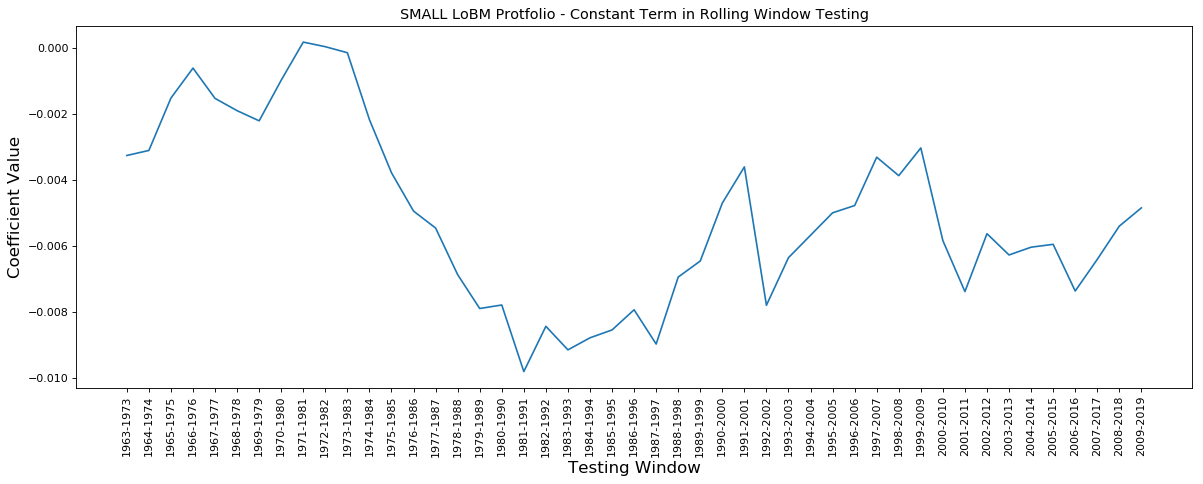

In [202]:
#to plot the constant terms from the 47 regressions of the 1st portfolio
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(ts_1_1_cons)
plt.xticks(rotation=90)
plt.xlabel('Testing Window', size = 15)
plt.ylabel('Coefficient Value', size = 15, rotation = 90)
plt.title('SMALL LoBM Protfolio - Constant Term in Rolling Window Testing', size = 13)
plt.xticks(size = 10)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 <a list of 47 Text xticklabel objects>)

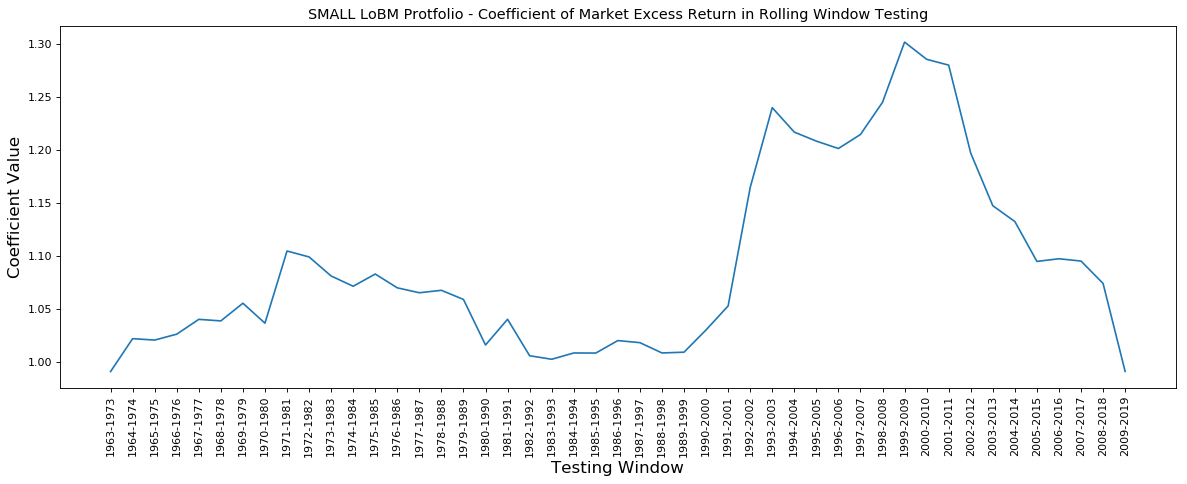

In [203]:
#to plot the coefficient of Mkt-Rf from the 47 regressions of the 1st portfolio
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(ts_1_1_Mkt)
plt.xticks(rotation=90)
plt.xlabel('Testing Window', size = 15)
plt.ylabel('Coefficient Value', size = 15, rotation = 90)
plt.title('SMALL LoBM Protfolio - Coefficient of Market Excess Return in Rolling Window Testing', size = 13)
plt.xticks(size = 10)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 <a list of 47 Text xticklabel objects>)

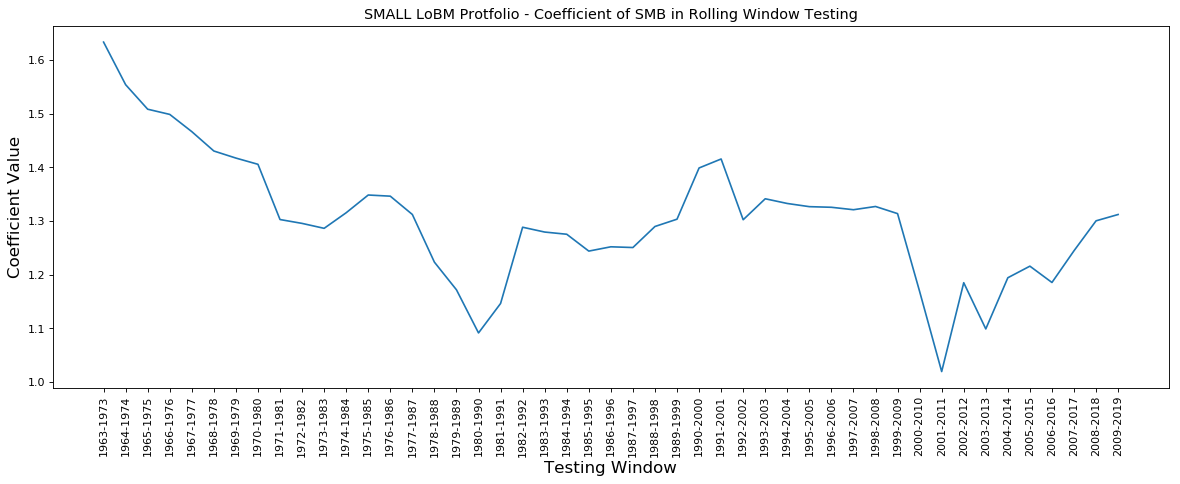

In [204]:
#to plot the coefficient of SMB from the 47 regressions of the 1st portfolio
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(ts_1_1_SMB)
plt.xticks(rotation=90)
plt.xlabel('Testing Window', size = 15)
plt.ylabel('Coefficient Value', size = 15, rotation = 90)
plt.title('SMALL LoBM Protfolio - Coefficient of SMB in Rolling Window Testing', size = 13)
plt.xticks(size = 10)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 <a list of 47 Text xticklabel objects>)

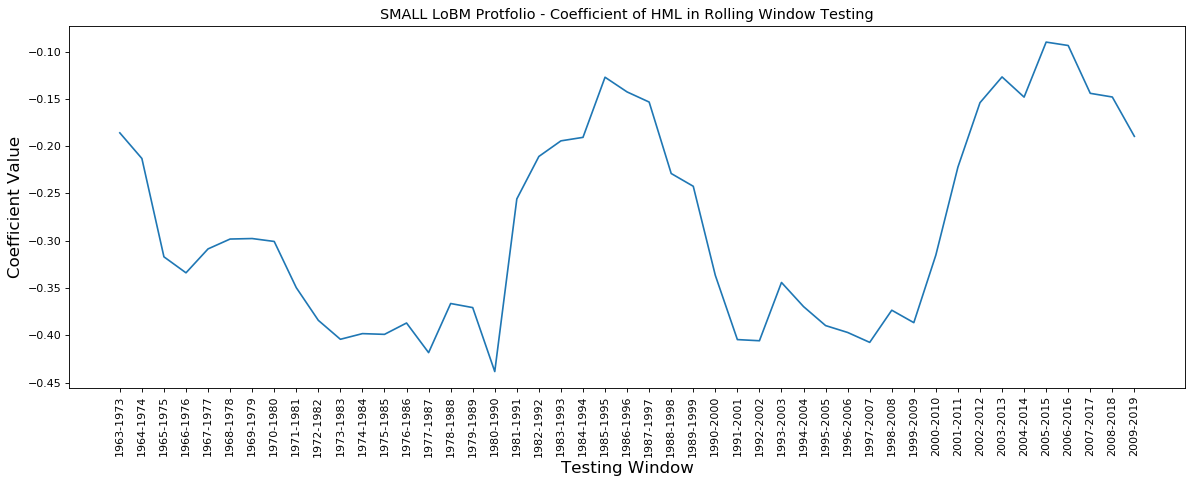

In [205]:
#to plot the coefficient of HML from the 47 regressions of the 1st portfolio
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(ts_1_1_HML)
plt.xticks(rotation=90)
plt.xlabel('Testing Window', size = 15)
plt.ylabel('Coefficient Value', size = 15, rotation = 90)
plt.title('SMALL LoBM Protfolio - Coefficient of HML in Rolling Window Testing', size = 13)
plt.xticks(size = 10)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 <a list of 47 Text xticklabel objects>)

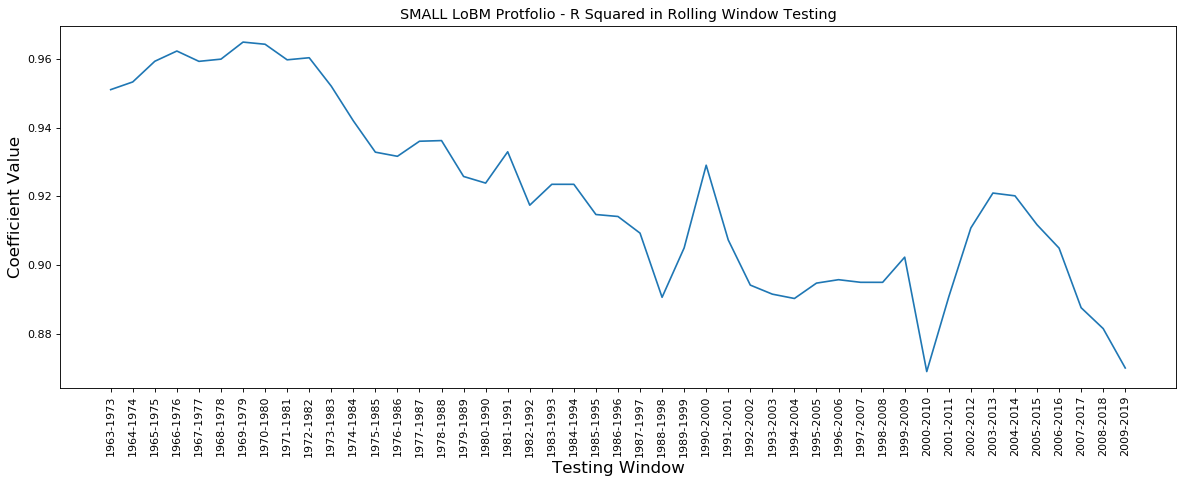

In [206]:
#to plot the R-square of the 47 regressions of the 1st portfolio
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(ts_1_1_rsquared)
plt.xticks(rotation=90)
plt.xlabel('Testing Window', size = 15)
plt.ylabel('Coefficient Value', size = 15, rotation = 90)
plt.title('SMALL LoBM Protfolio - R Squared in Rolling Window Testing', size = 13)
plt.xticks(size = 10)

In [207]:
#In a loop, collect the constant terms from 47 regressions of each of the 25 portfolios
Constant = {}
for i in range(25):
    x = []
    for n in range(47):  
        x.append(models[i*47 +n].params[0]) 
    Constant["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
print(Constant)       

{'Portfoio0': 1963-1973   -0.003245
1964-1974   -0.003092
1965-1975   -0.001504
1966-1976   -0.000596
1967-1977   -0.001514
1968-1978   -0.001886
1969-1979   -0.002194
1970-1980   -0.000962
1971-1981    0.000193
1972-1982    0.000053
1973-1983   -0.000130
1974-1984   -0.002157
1975-1985   -0.003769
1976-1986   -0.004931
1977-1987   -0.005445
1978-1988   -0.006857
1979-1989   -0.007884
1980-1990   -0.007778
1981-1991   -0.009795
1982-1992   -0.008424
1983-1993   -0.009138
1984-1994   -0.008772
1985-1995   -0.008534
1986-1996   -0.007923
1987-1997   -0.008961
1988-1998   -0.006931
1989-1999   -0.006444
1990-2000   -0.004687
1991-2001   -0.003591
1992-2002   -0.007786
1993-2003   -0.006343
1994-2004   -0.005663
1995-2005   -0.004983
1996-2006   -0.004763
1997-2007   -0.003297
1998-2008   -0.003856
1999-2009   -0.003017
2000-2010   -0.005826
2001-2011   -0.007371
2002-2012   -0.005617
2003-2013   -0.006260
2004-2014   -0.006025
2005-2015   -0.005938
2006-2016   -0.007354
2007-2017   -0.006

In [208]:
#In a loop, collect the coeff of Mkt-Rf from 47 regressions of each of the 25 portfolios
Mkt = {}
for i in range(25):
    x = []
    for n in range(47):  
        x.append(models[i*47 +n].params[1]) 
    Mkt["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [209]:
#In a loop, collect the coeff of SMB from 47 regressions of each of the 25 portfolios
SMB = {}
for i in range(25):
    x = []
    for n in range(47):  
        x.append(models[i*47 +n].params[2]) 
    SMB["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [210]:
#In a loop, collect the coeff of HML from 47 regressions of each of the 25 portfolios
HML = {}
for i in range(25):
    x = []
    for n in range(47):  
        x.append(models[i*47 +n].params[3]) 
    HML["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [211]:
#In a loop, collect the R-squared of 47 regressions of each of the 25 portfolios
Rsquare = {}
for i in range(25):
    x = []
    for n in range(47):  
        x.append(models[i*47 +n].rsquared) 
    Rsquare["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

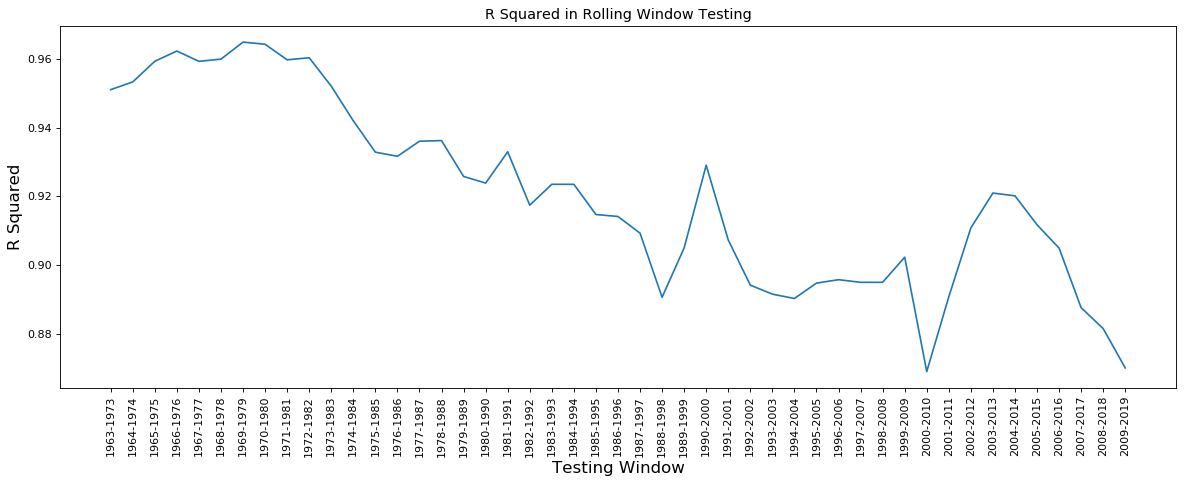

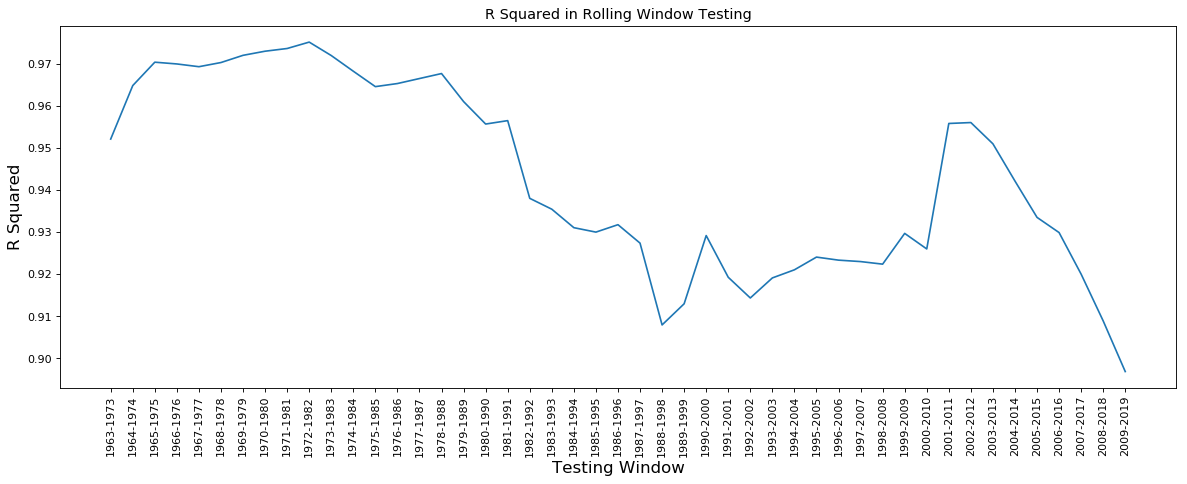

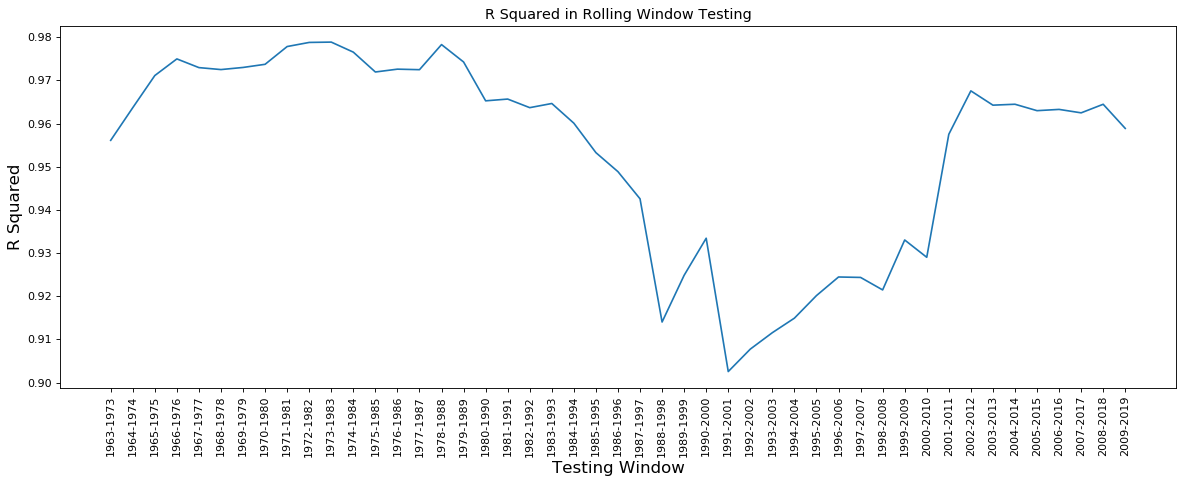

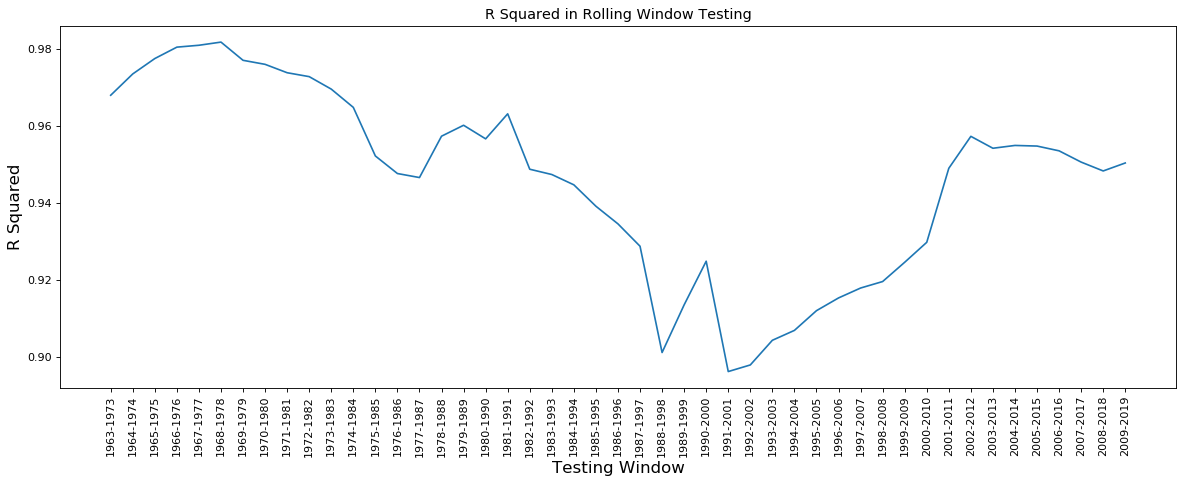

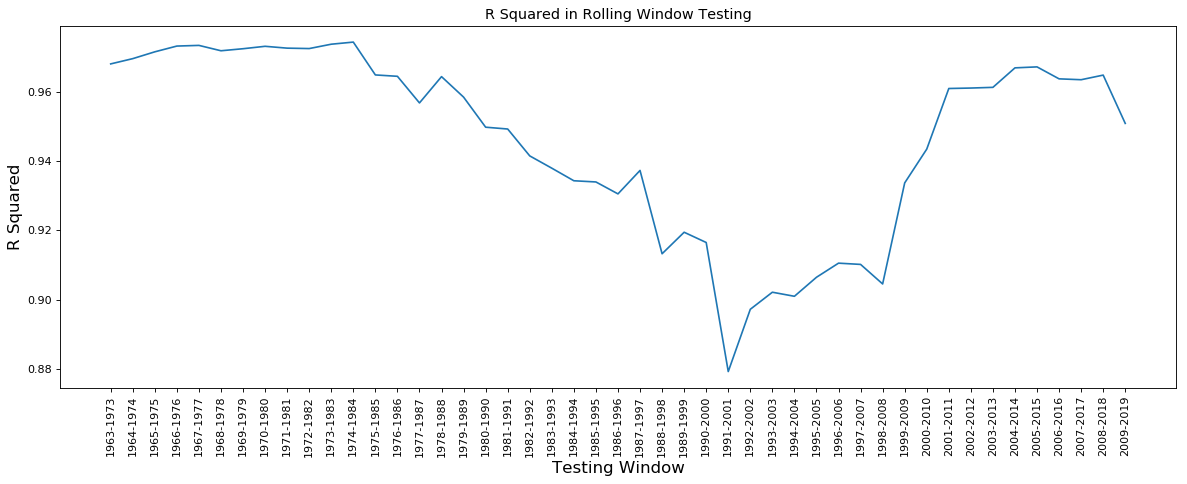

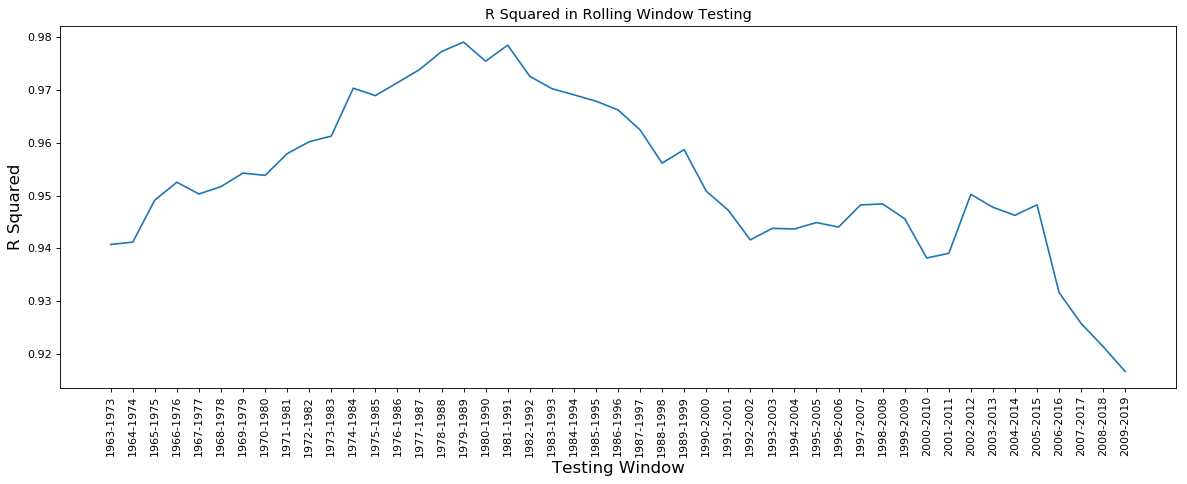

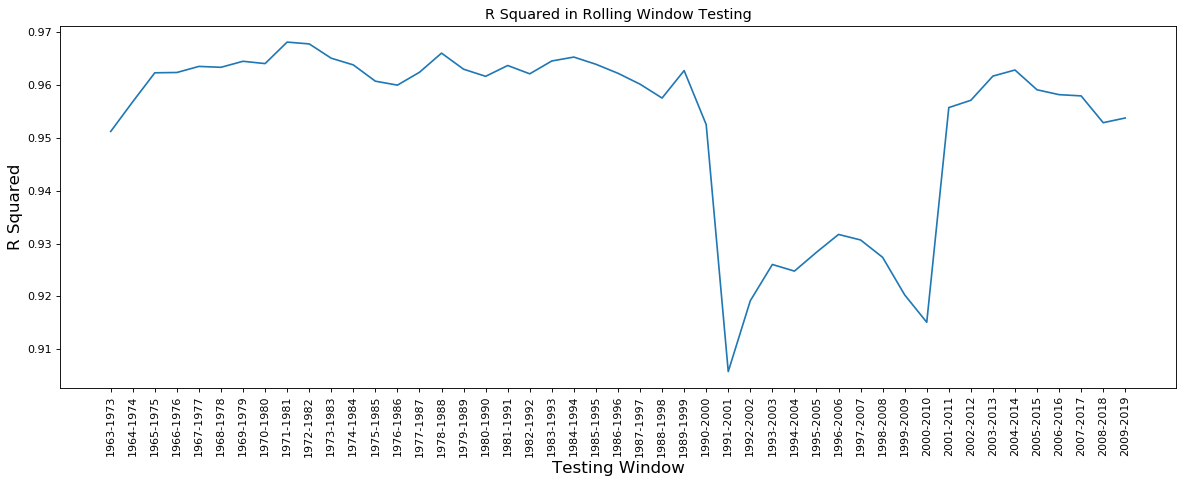

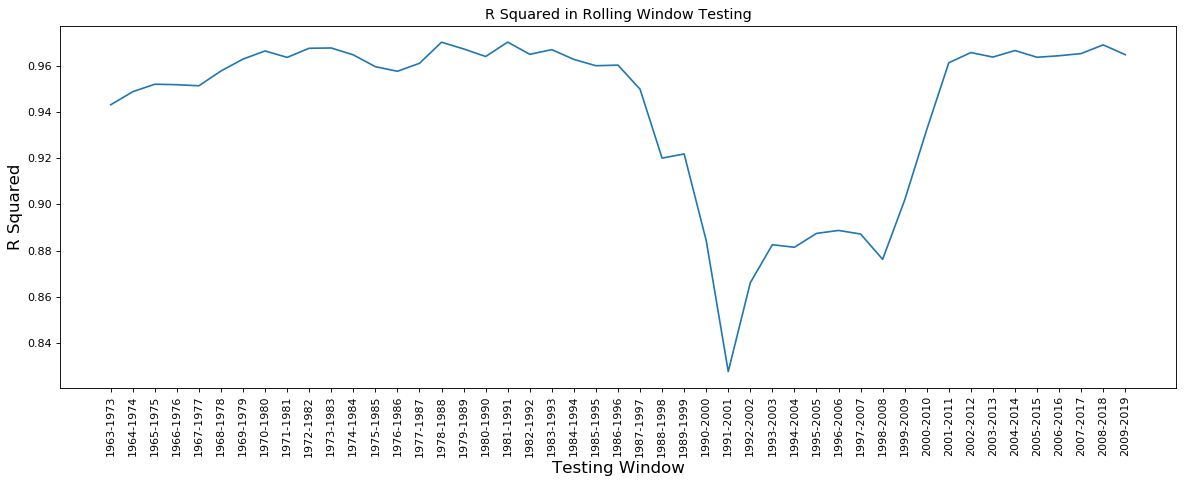

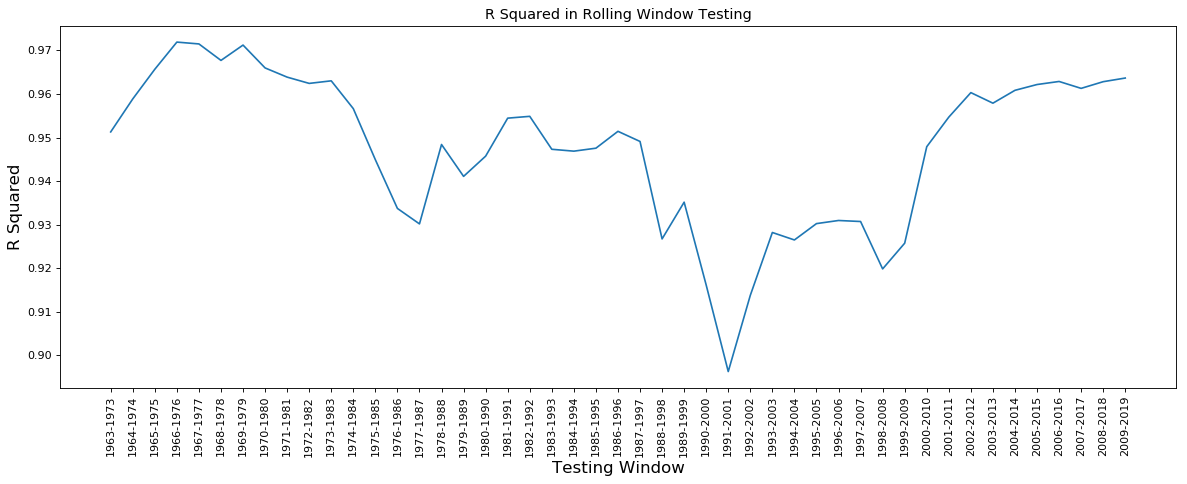

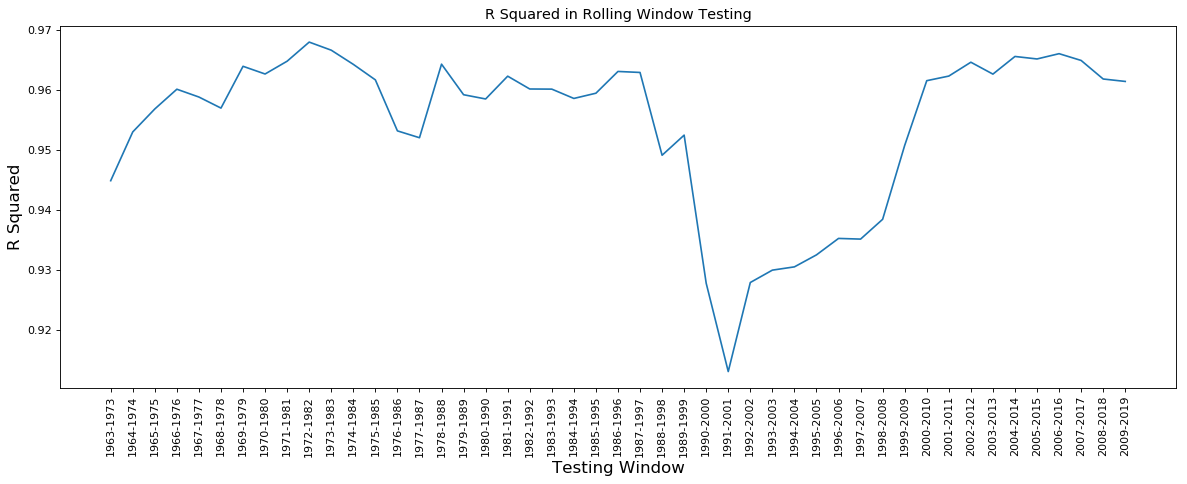

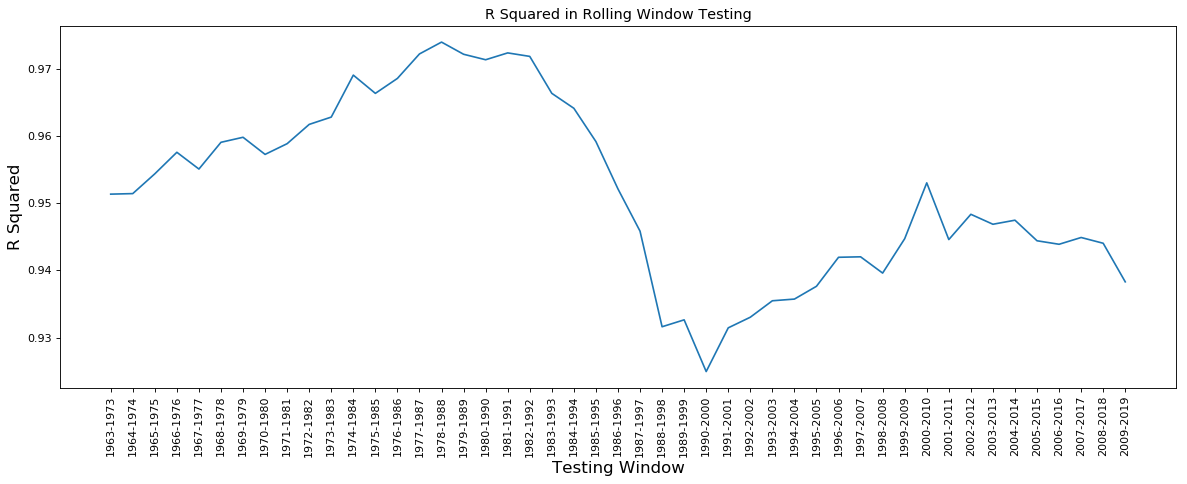

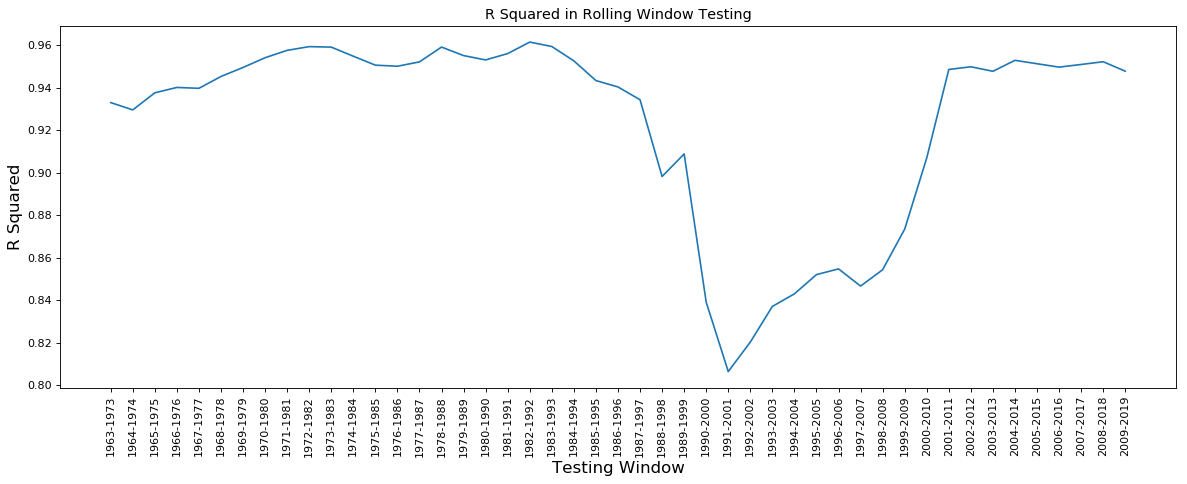

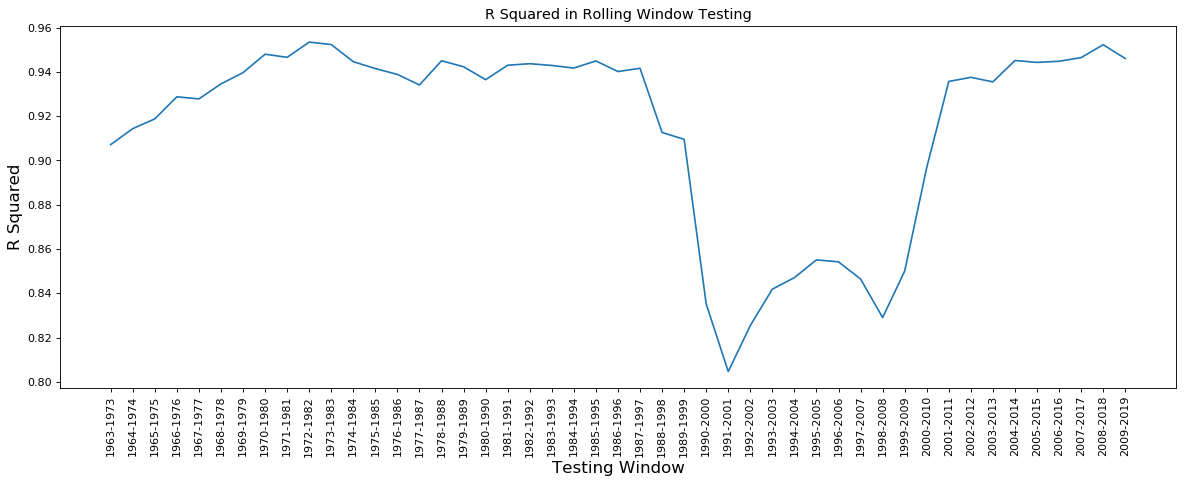

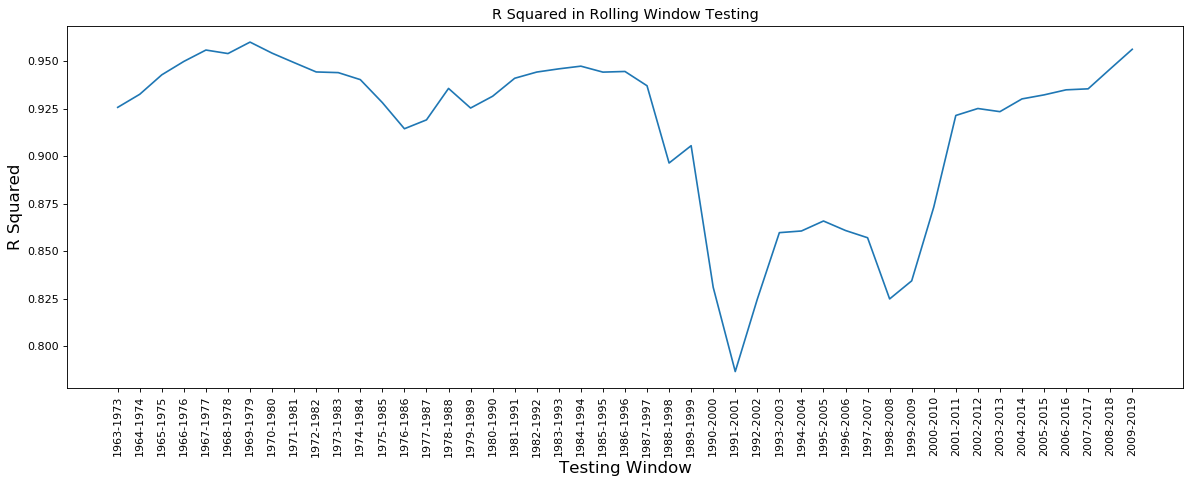

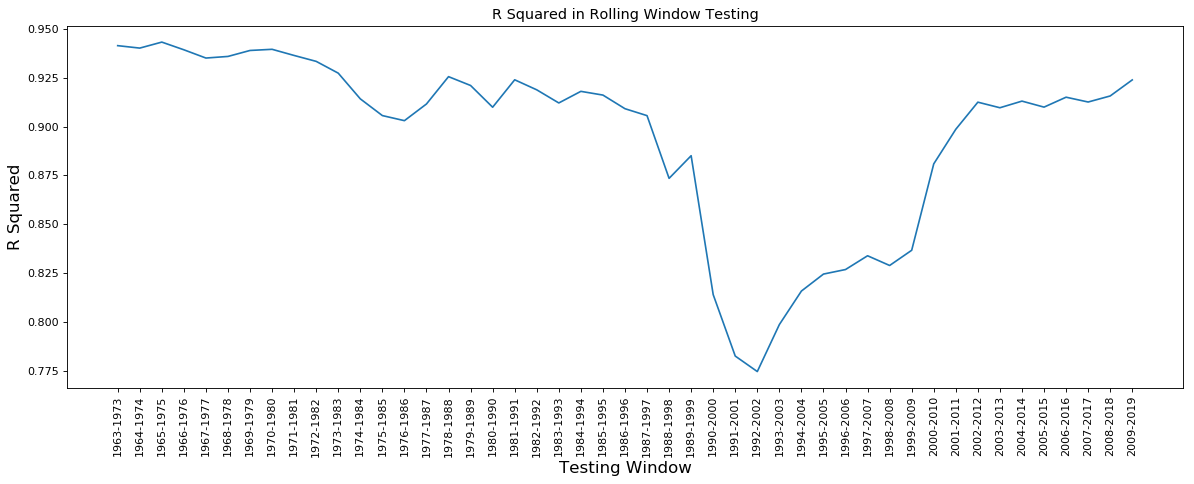

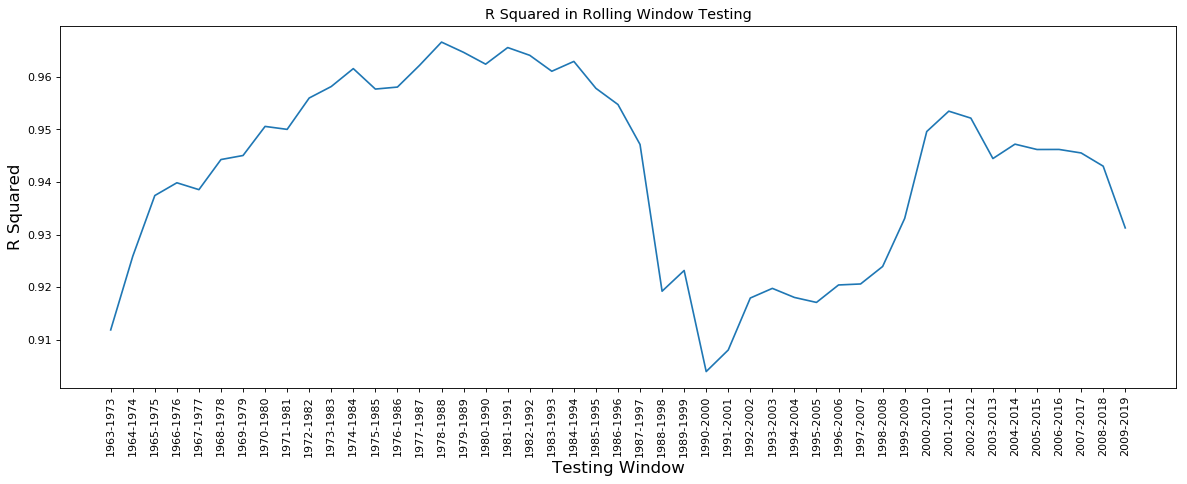

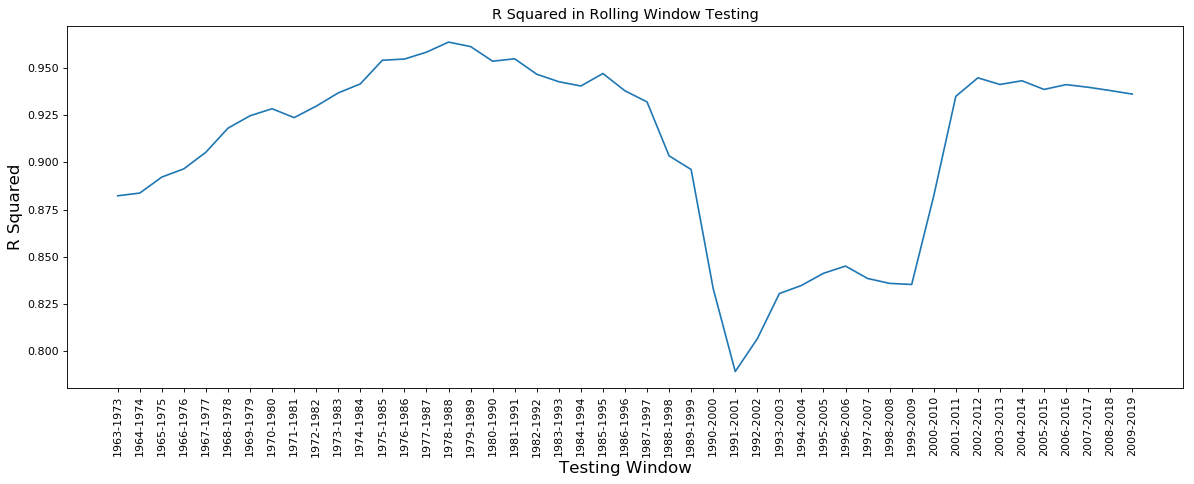

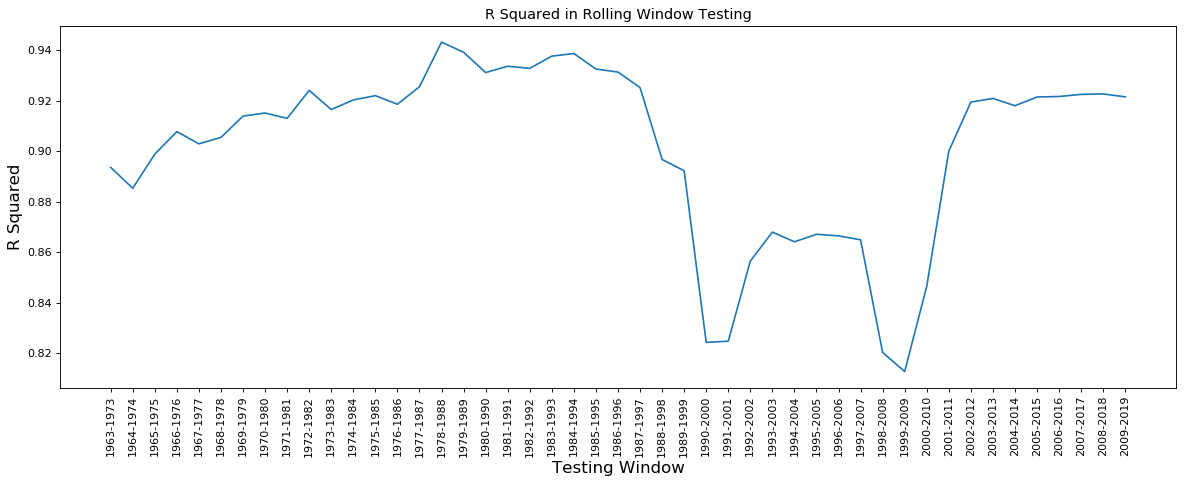

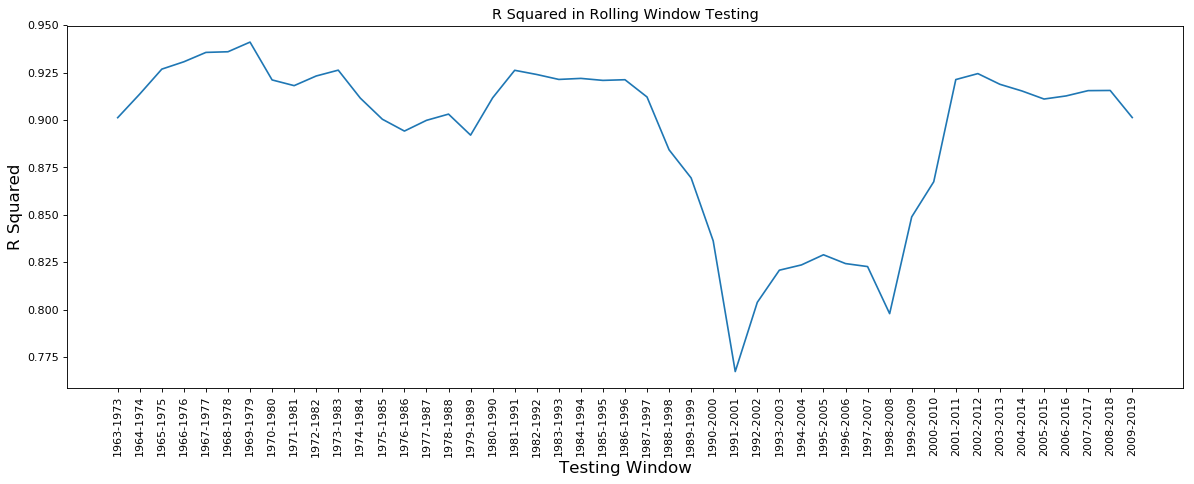

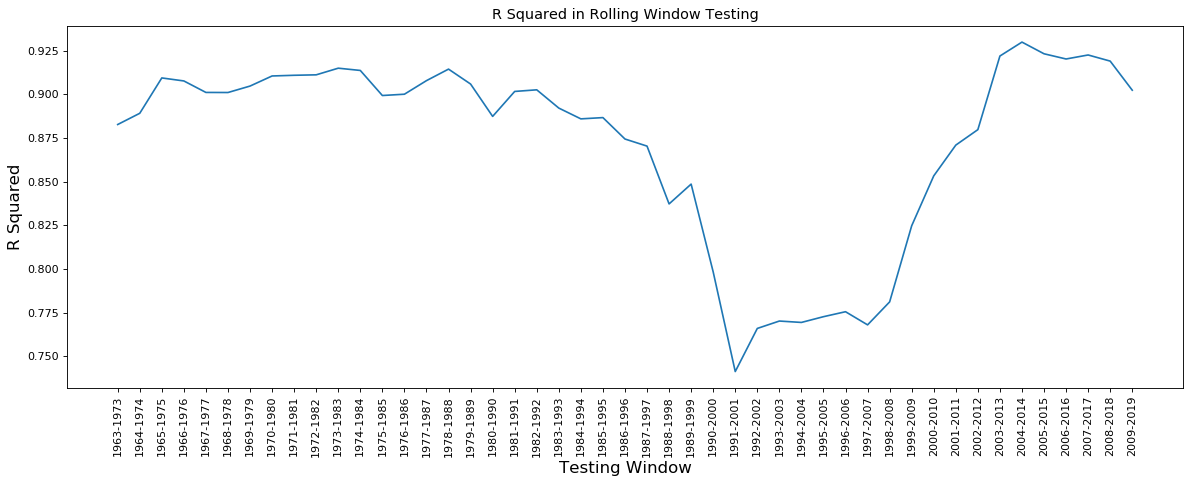

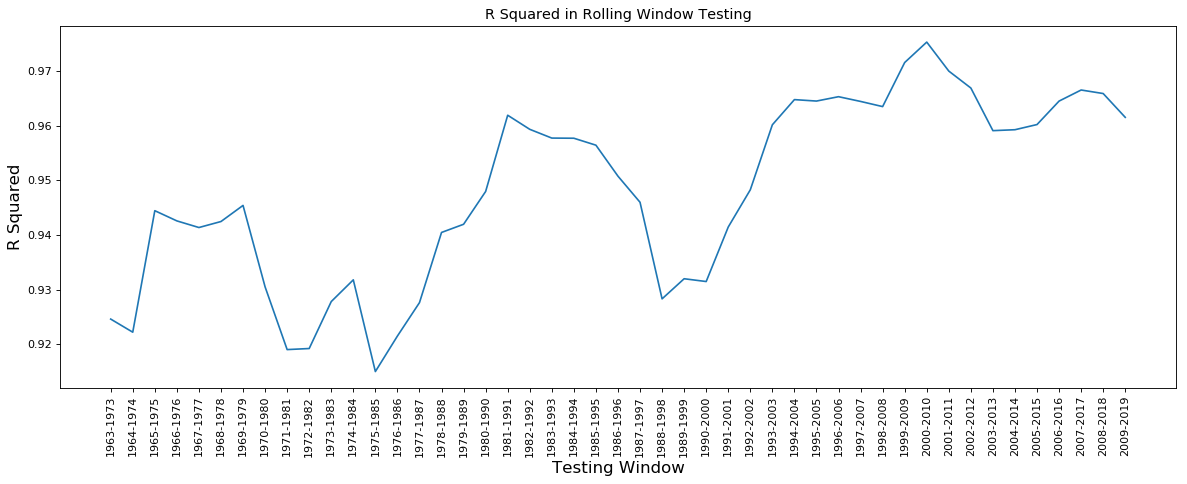

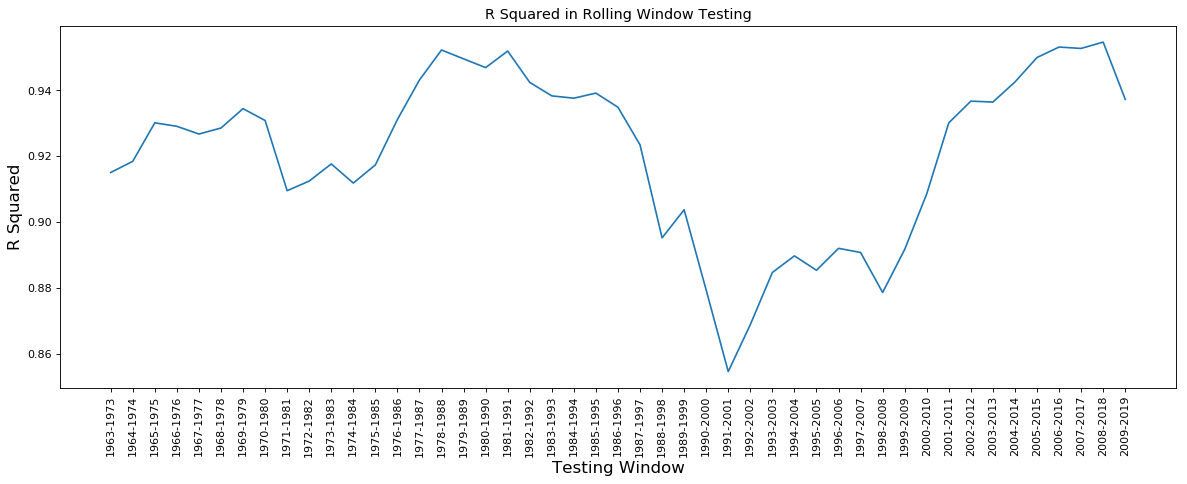

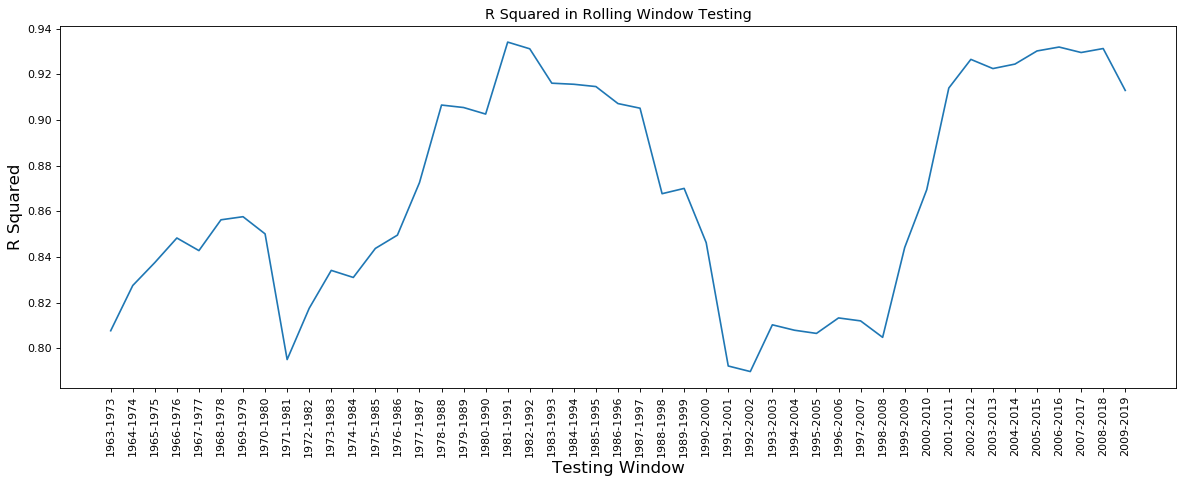

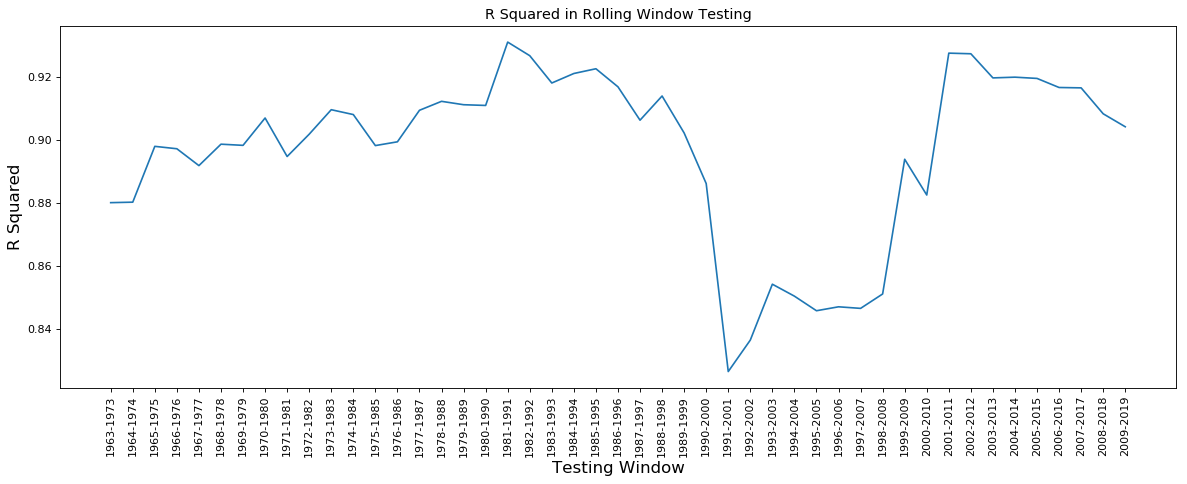

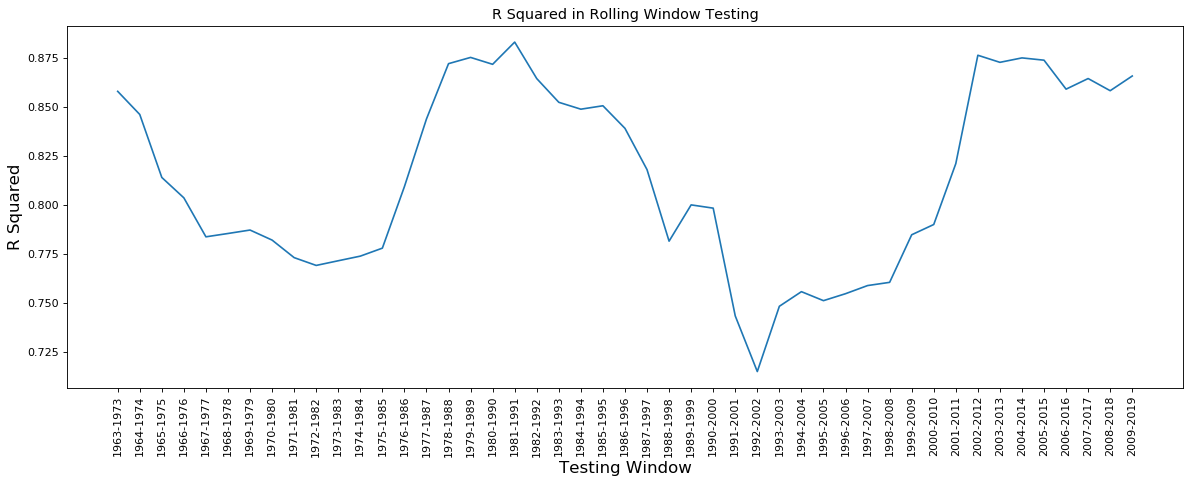

In [212]:
#In a loop, plot R-squared for each portfolio
for i in range(25):
    fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(Rsquare["Portfoio{0}".format(i)])
    plt.xticks(rotation=90)
    plt.xlabel('Testing Window', size = 15)
    plt.ylabel('R Squared', size = 15, rotation = 90)
    plt.title('R Squared in Rolling Window Testing', size = 13)
    plt.xticks(size = 10)

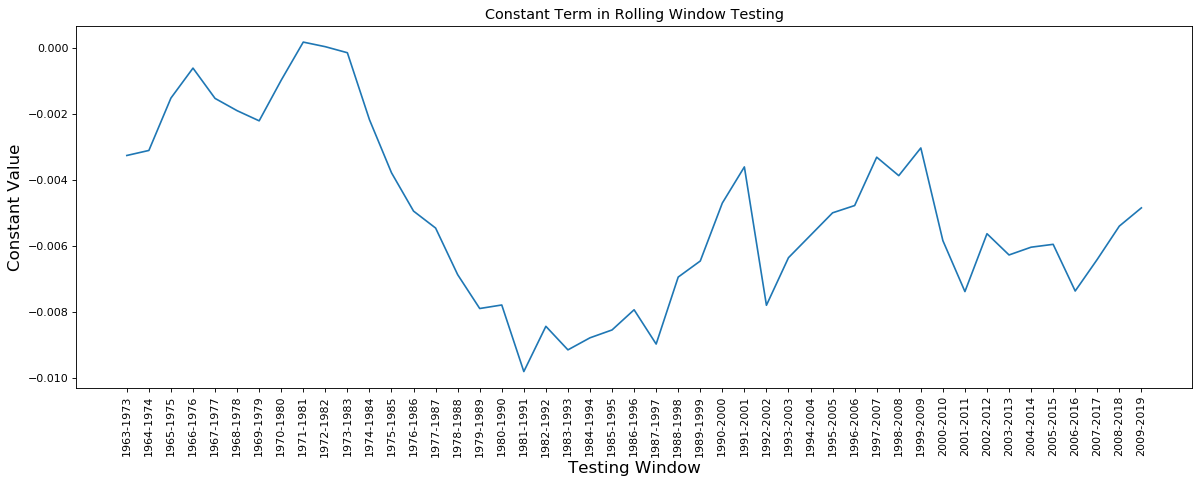

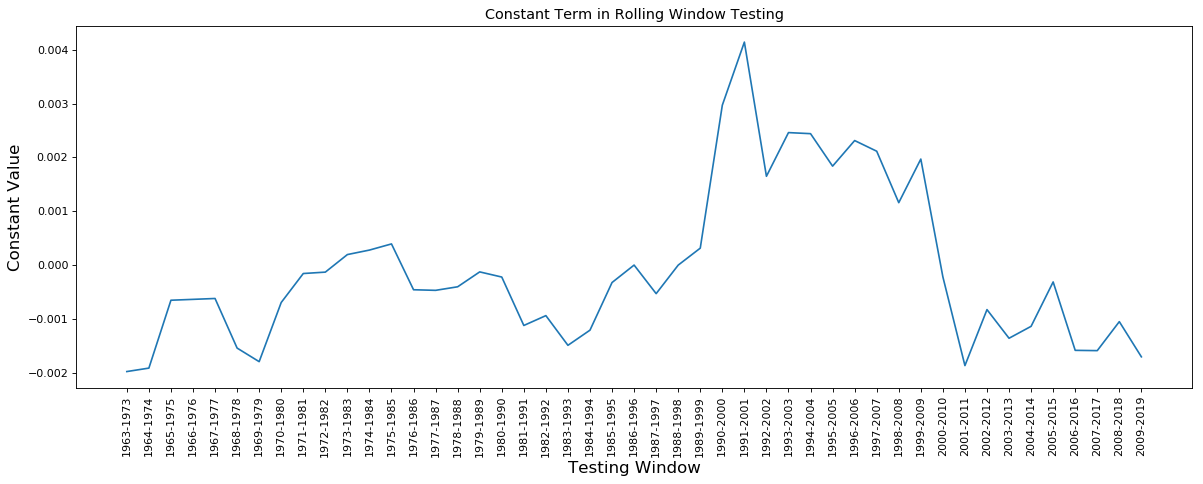

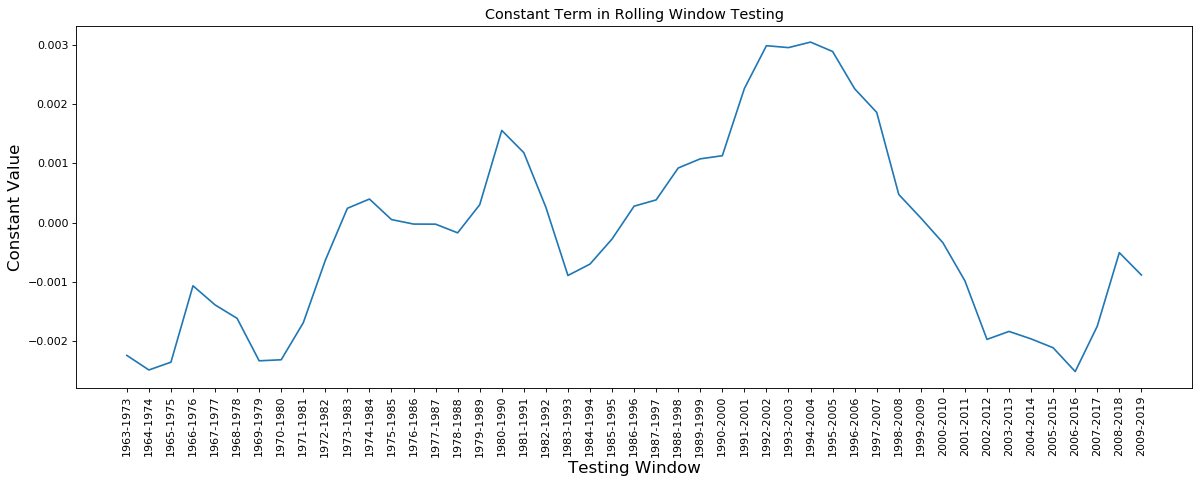

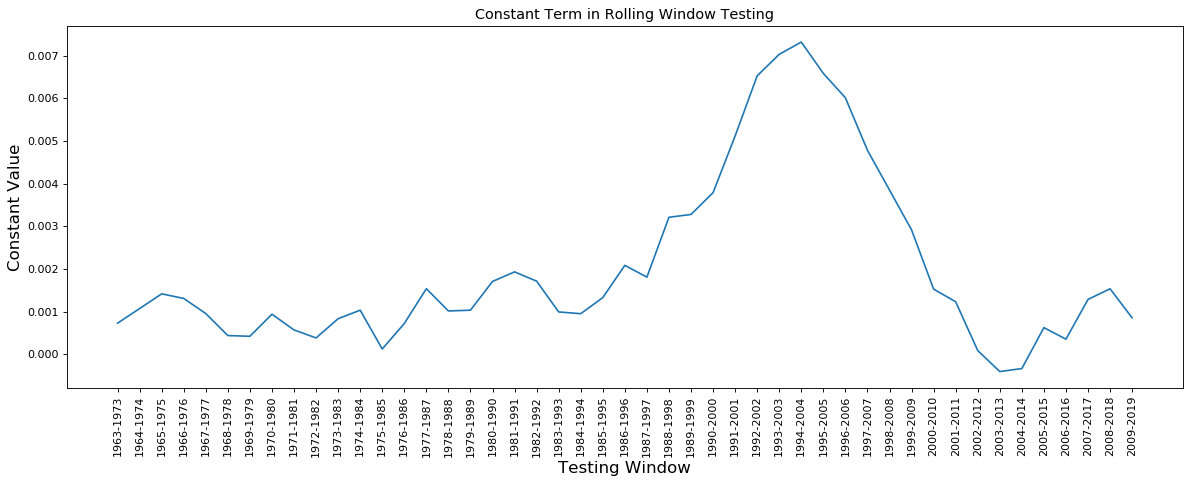

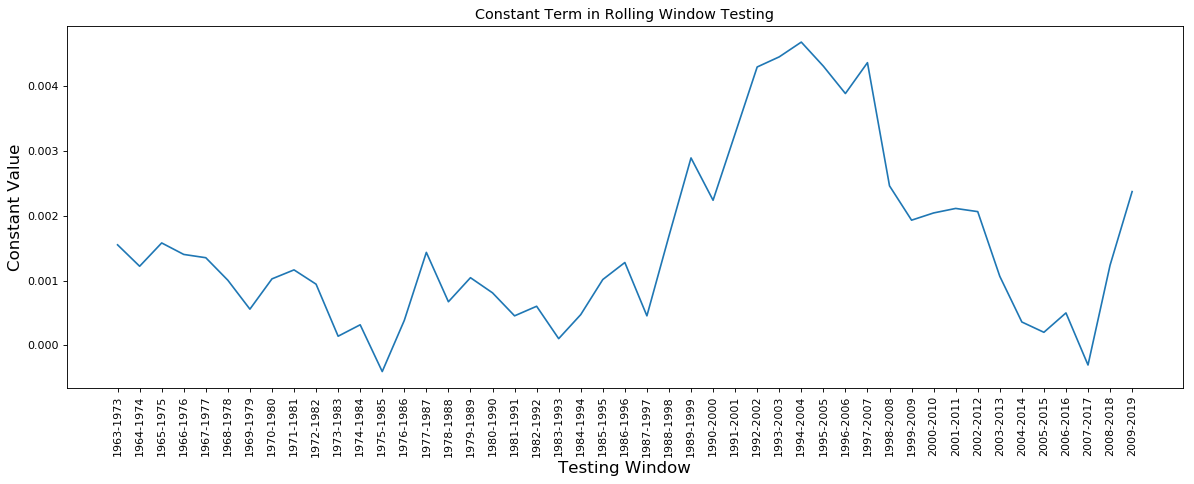

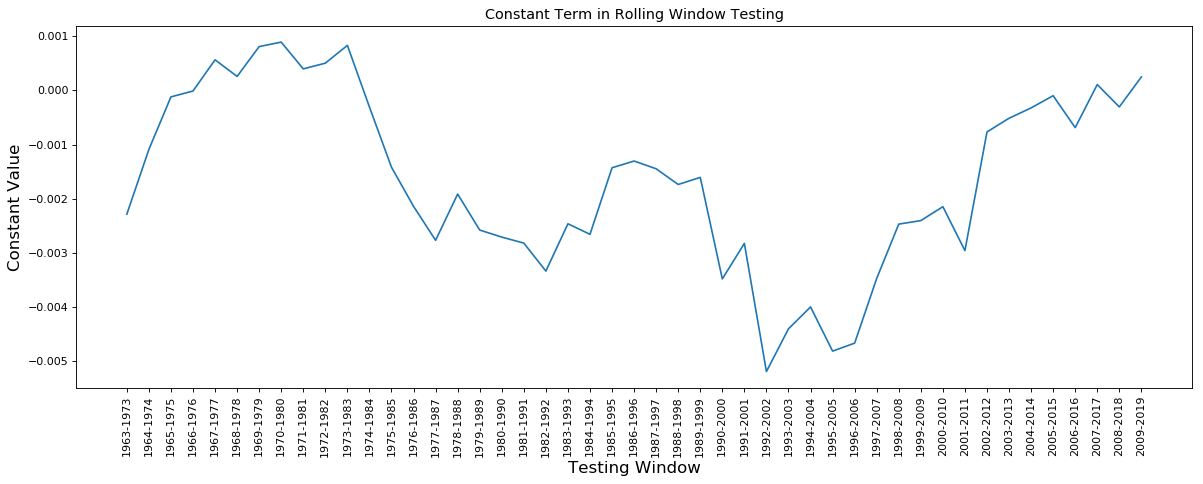

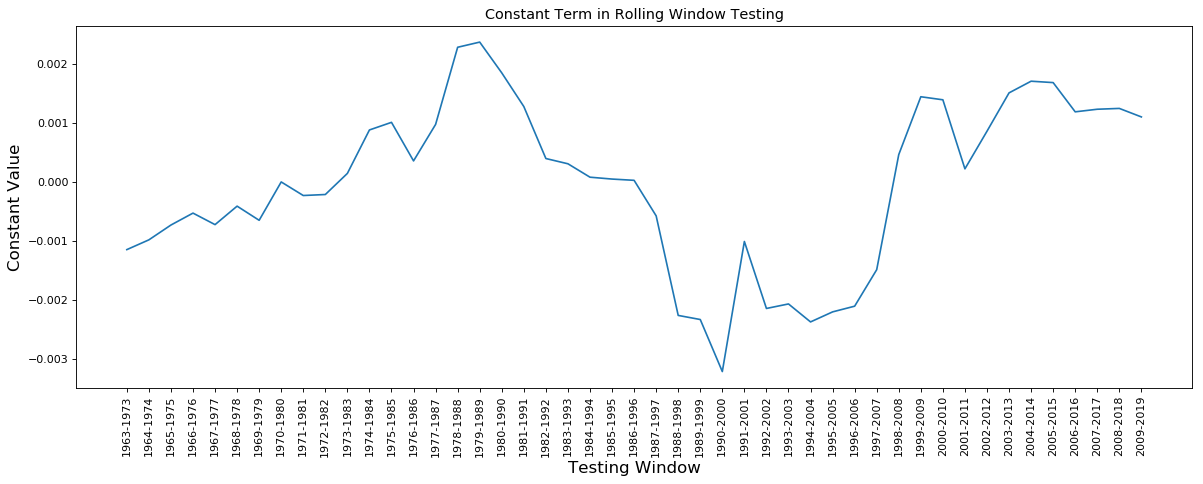

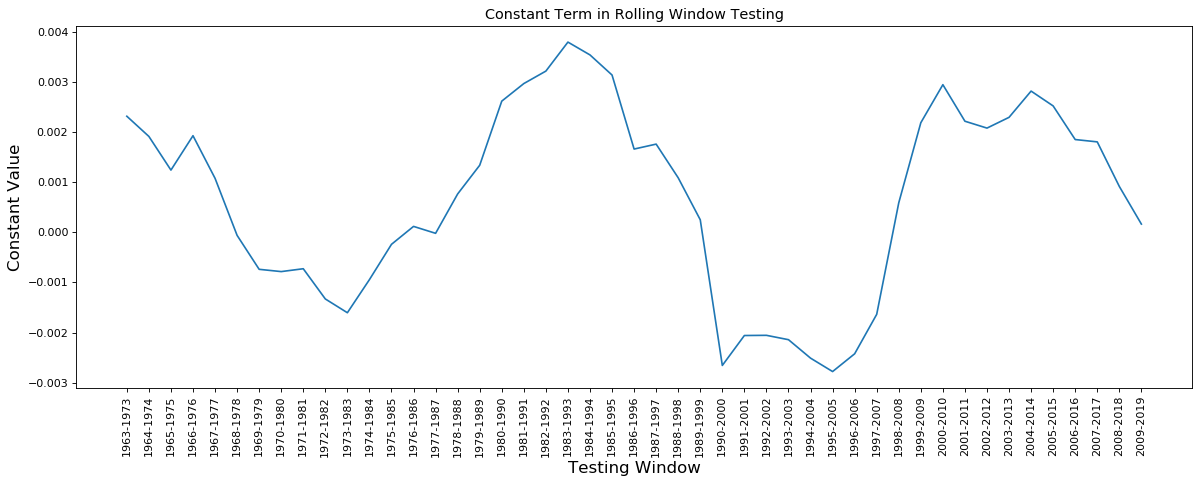

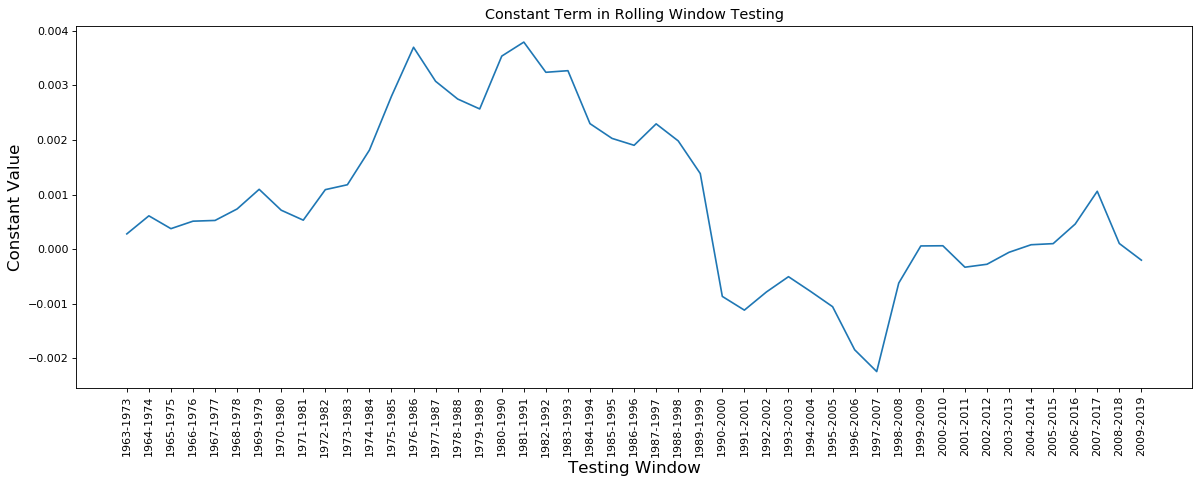

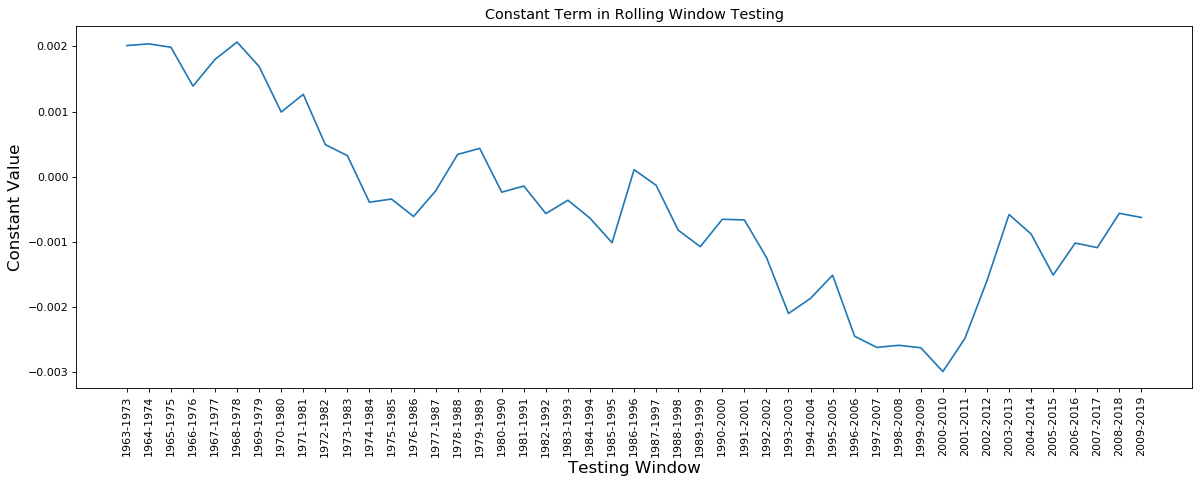

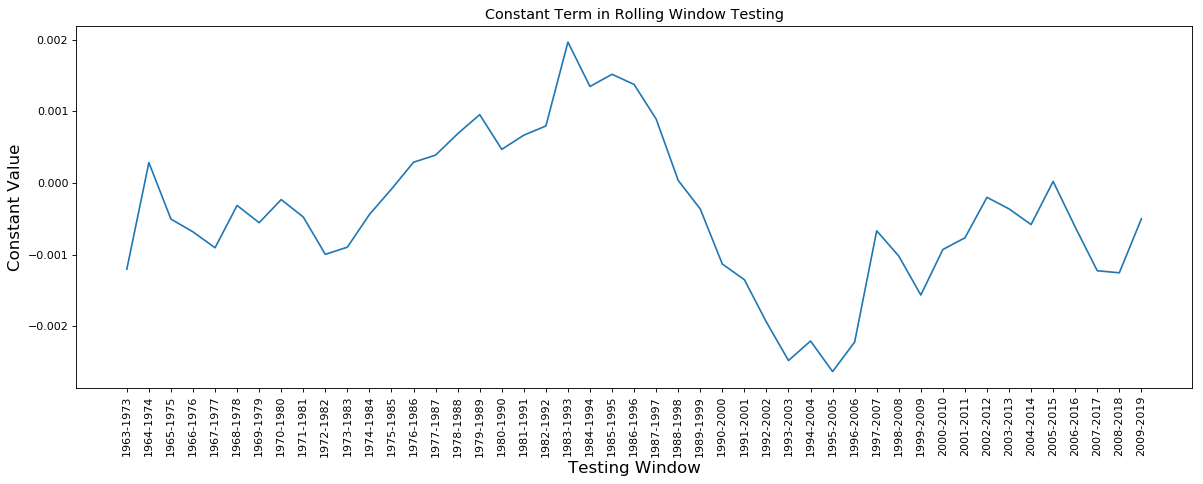

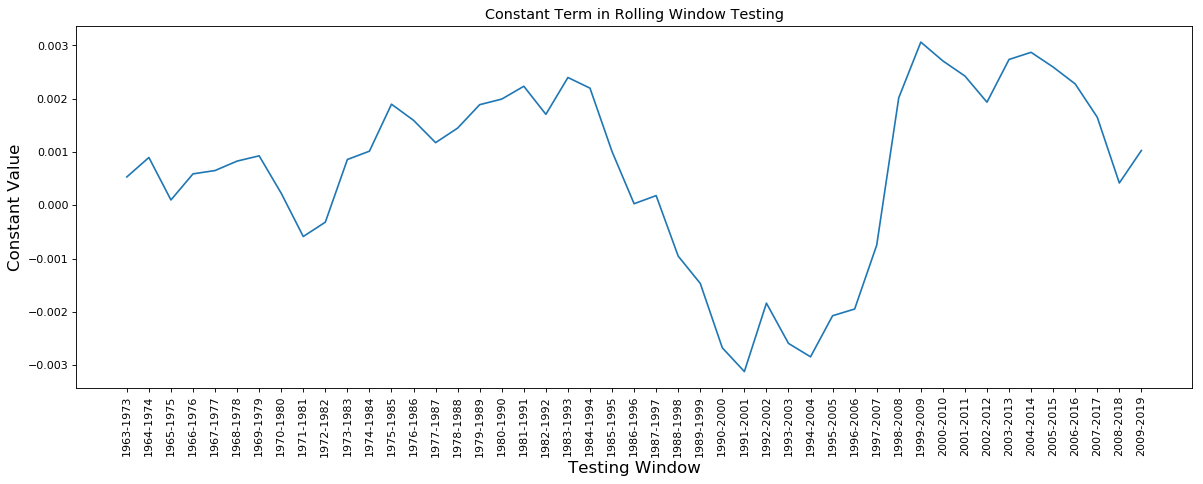

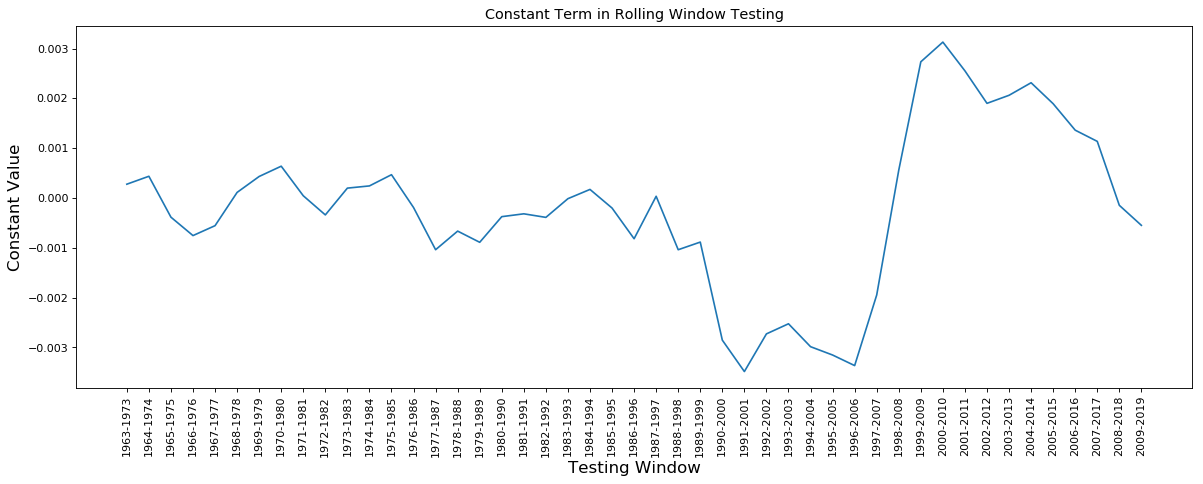

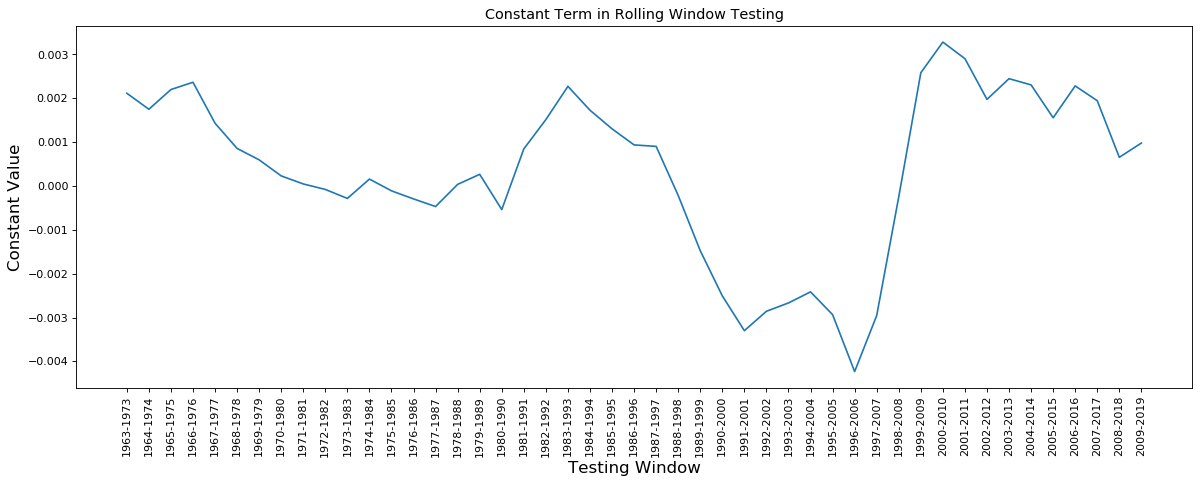

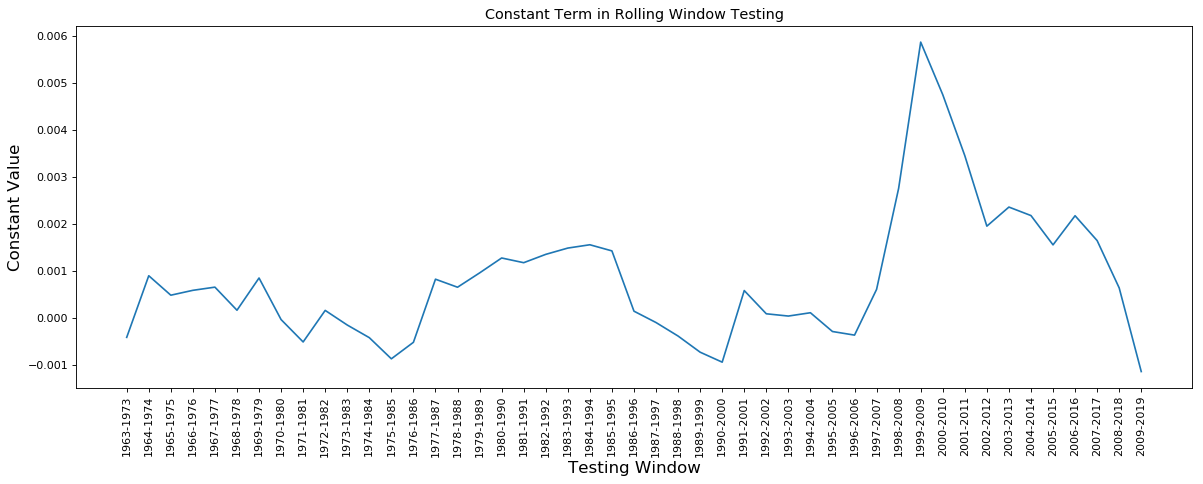

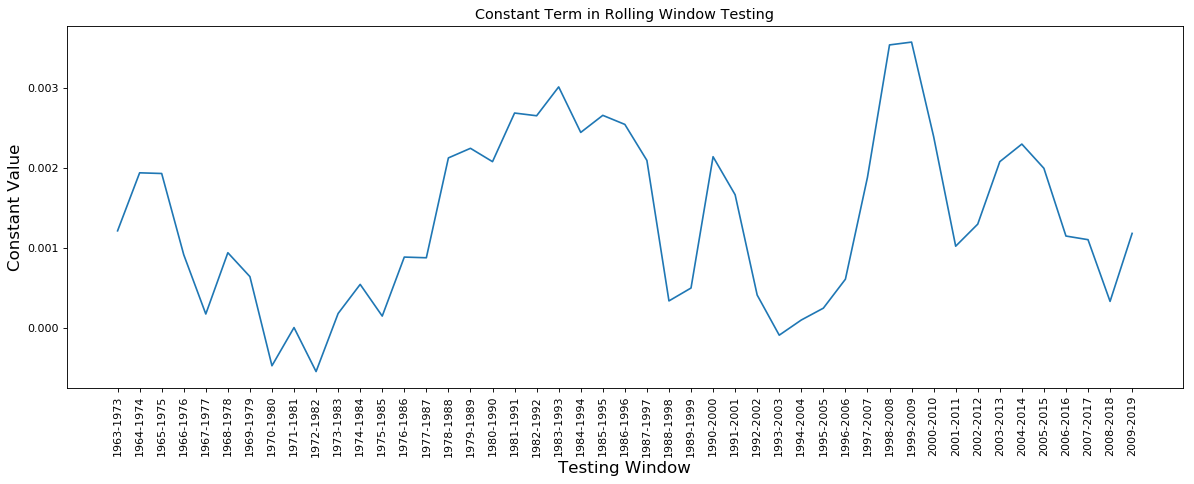

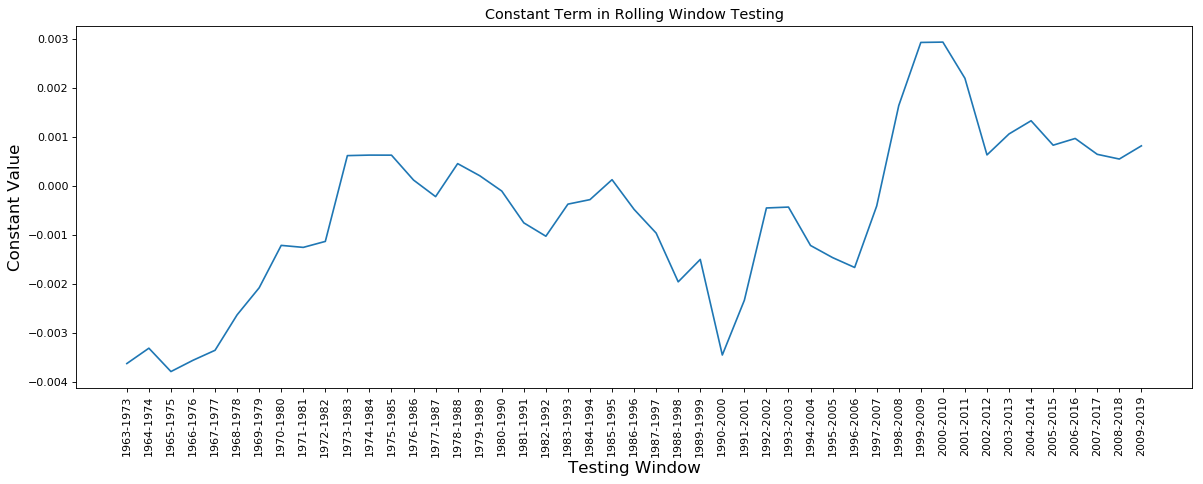

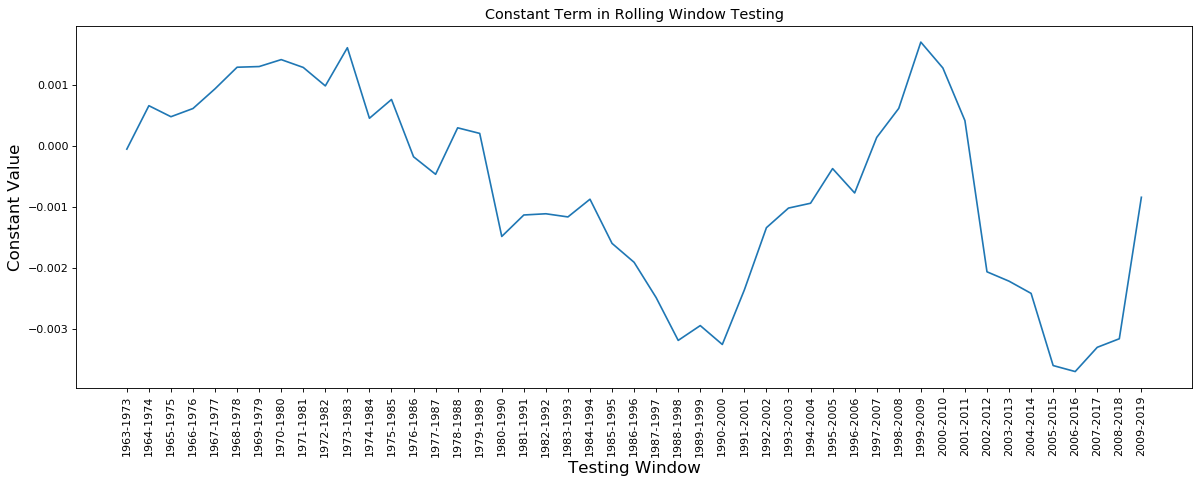

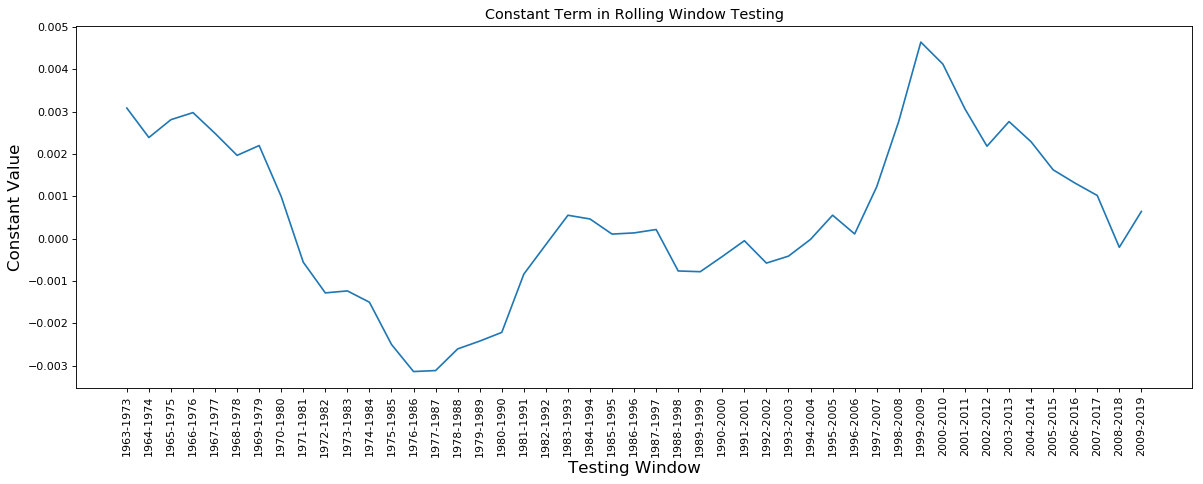

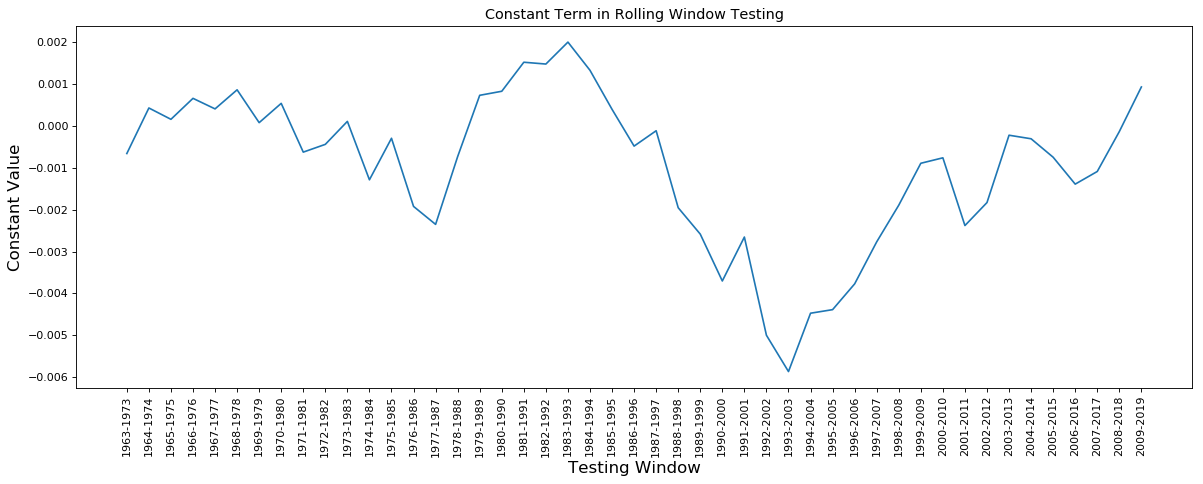

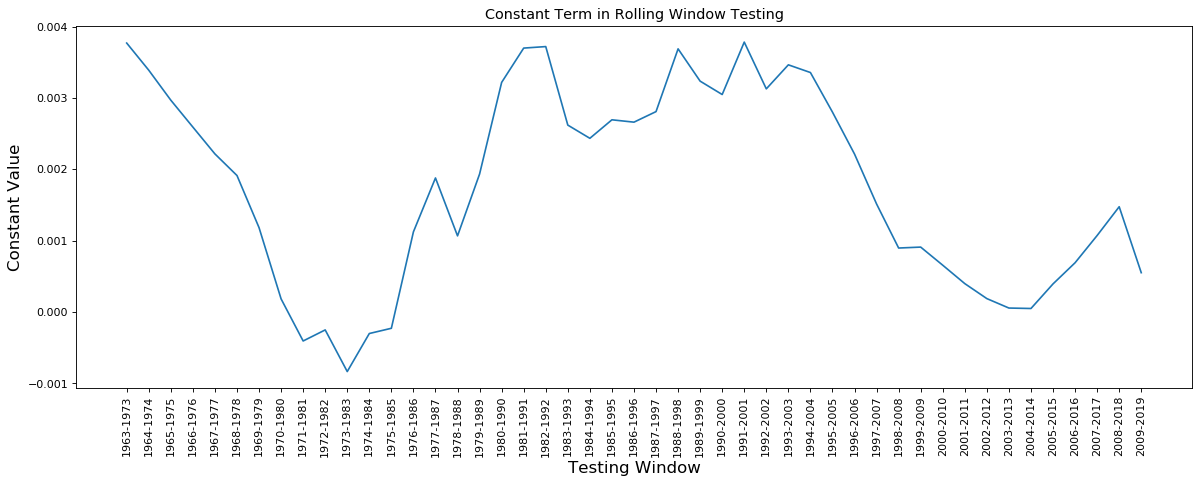

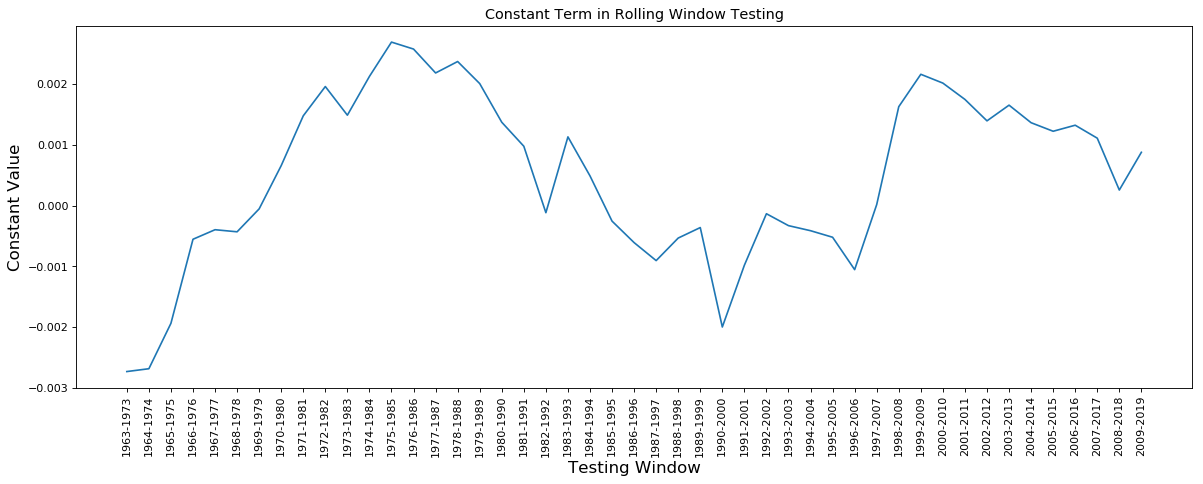

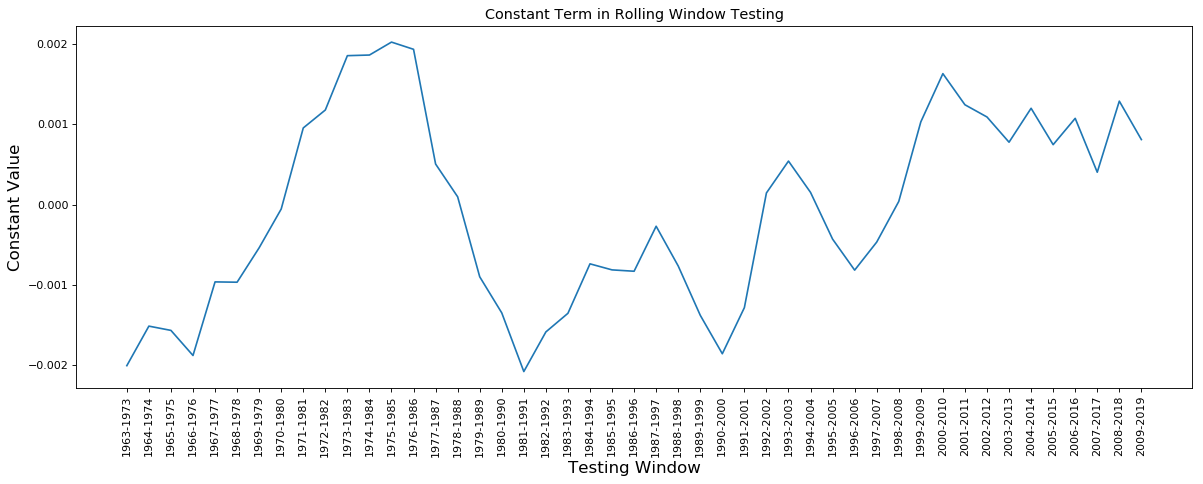

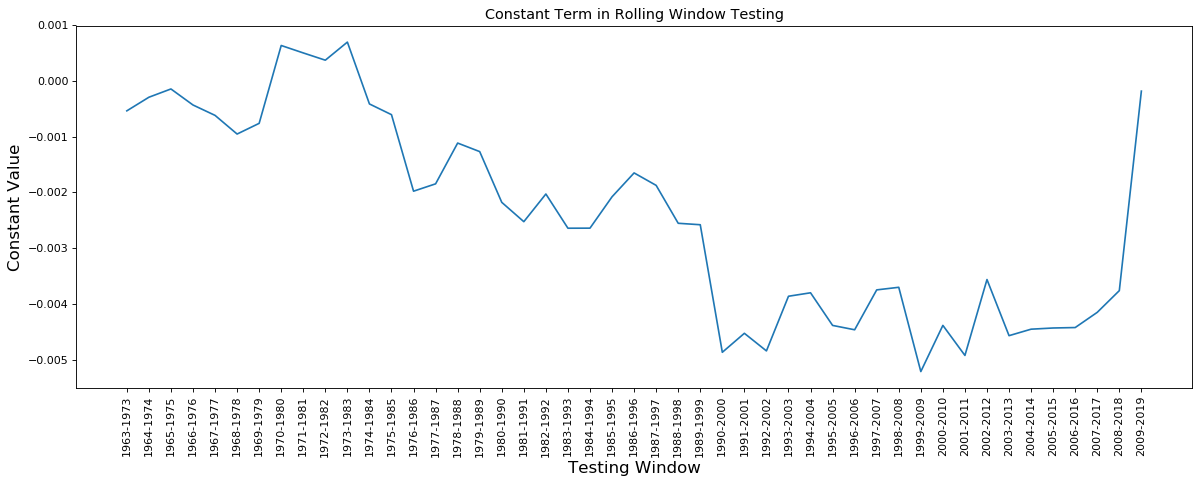

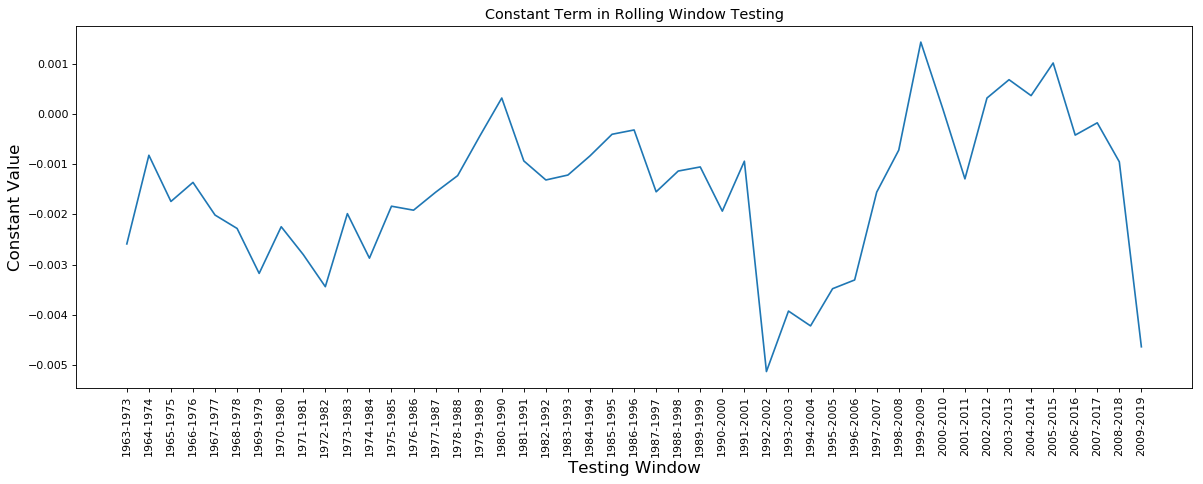

In [213]:
#In a loop, plot constant term for each portfolio
for i in range(25):
    fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(Constant["Portfoio{0}".format(i)])
    plt.xticks(rotation=90)
    plt.xlabel('Testing Window', size = 15)
    plt.ylabel('Constant Value', size = 15, rotation = 90)
    plt.title('Constant Term in Rolling Window Testing', size = 13)
    plt.xticks(size = 10)

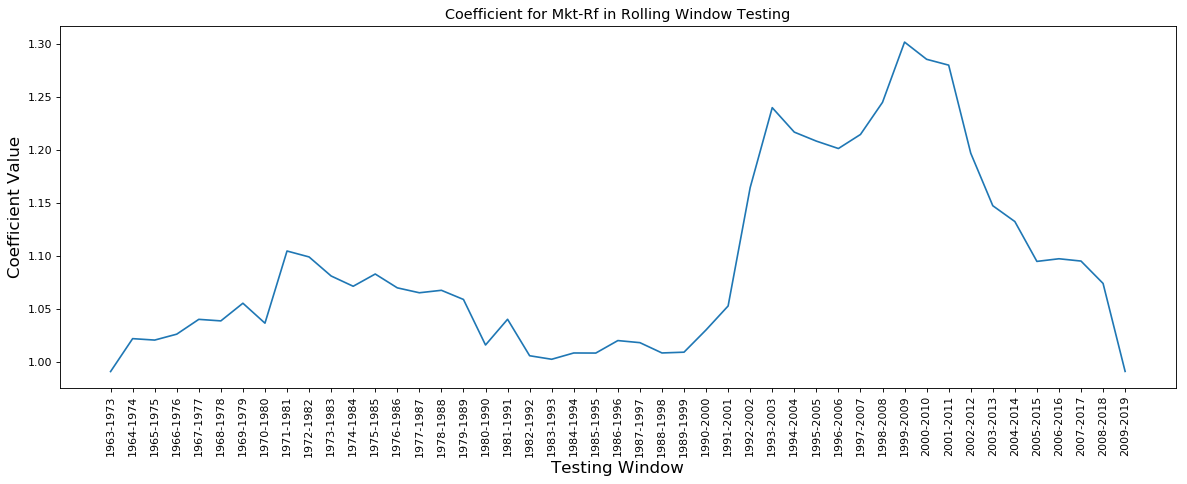

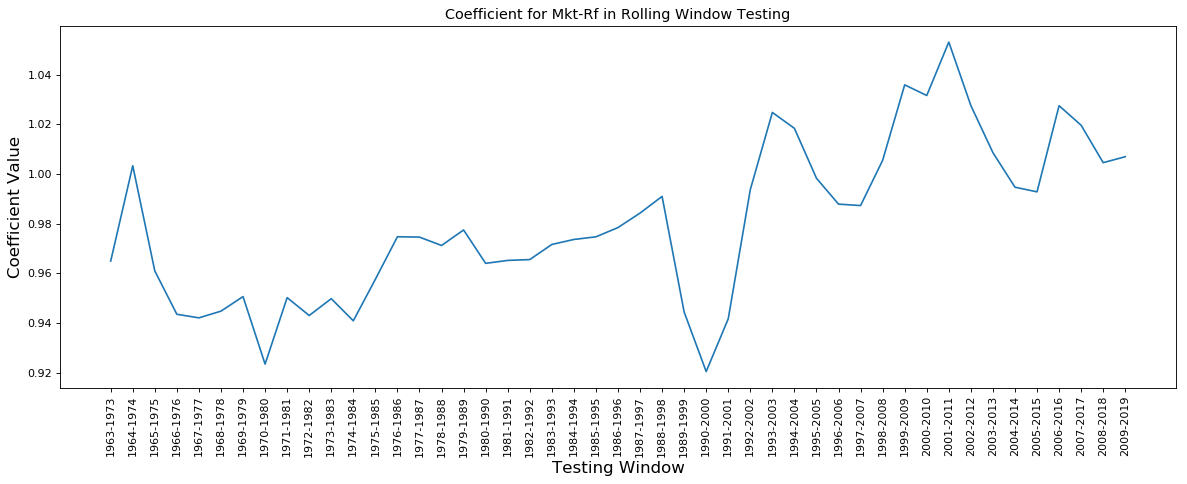

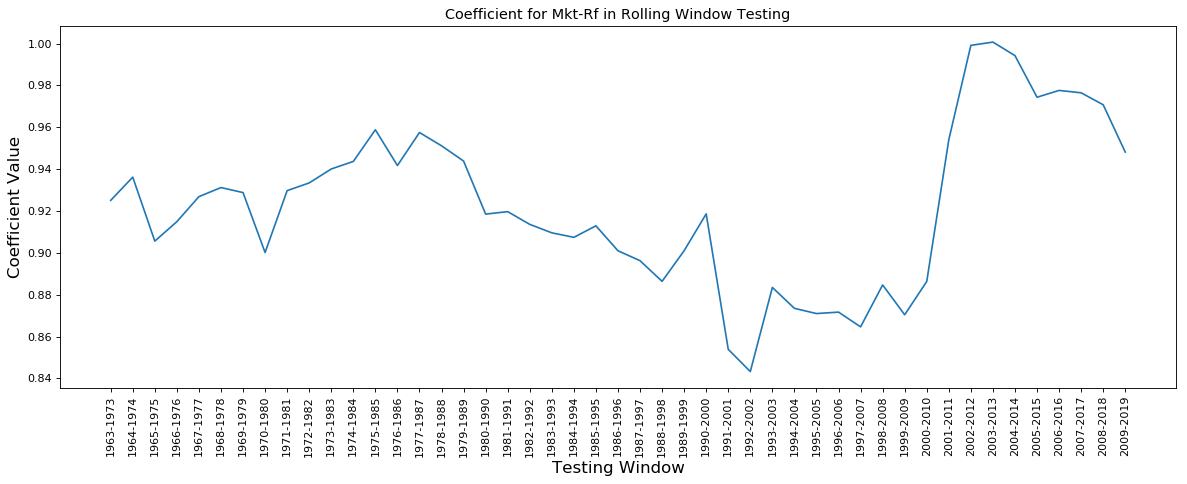

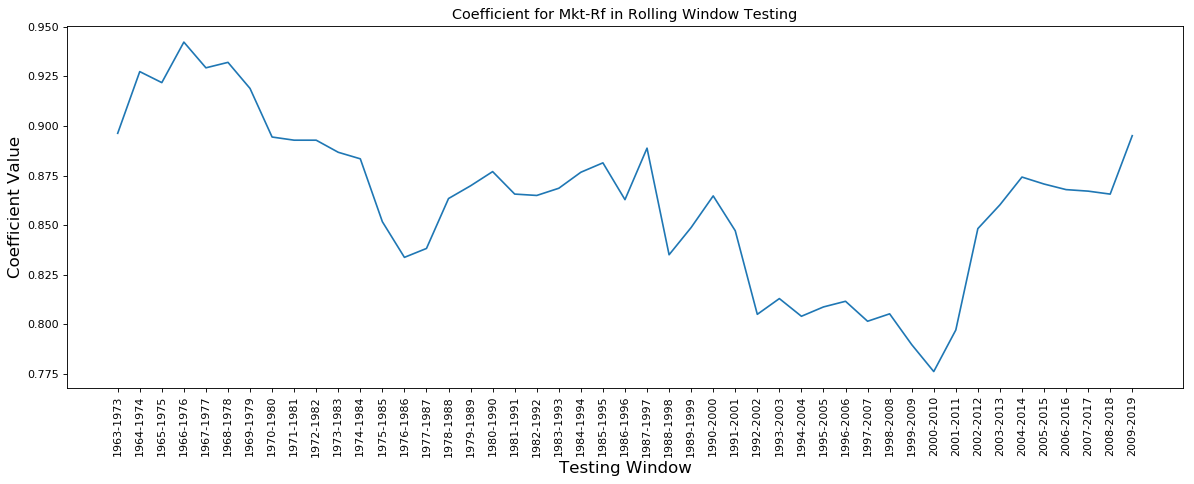

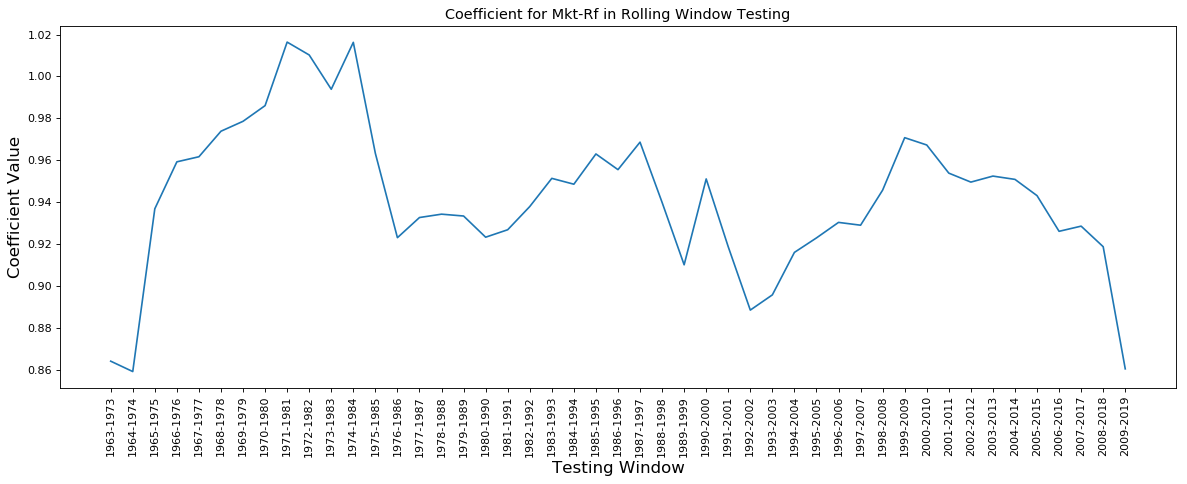

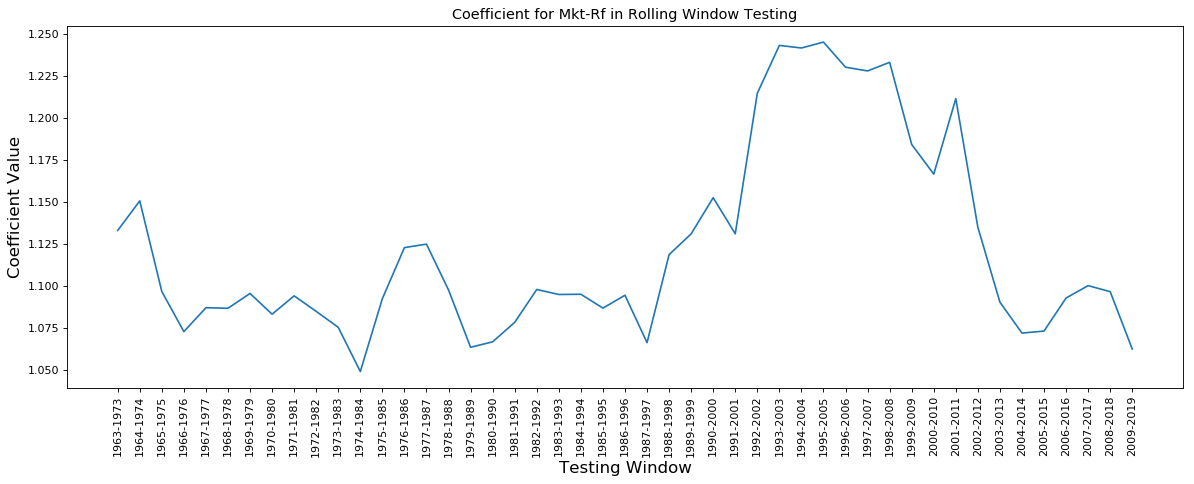

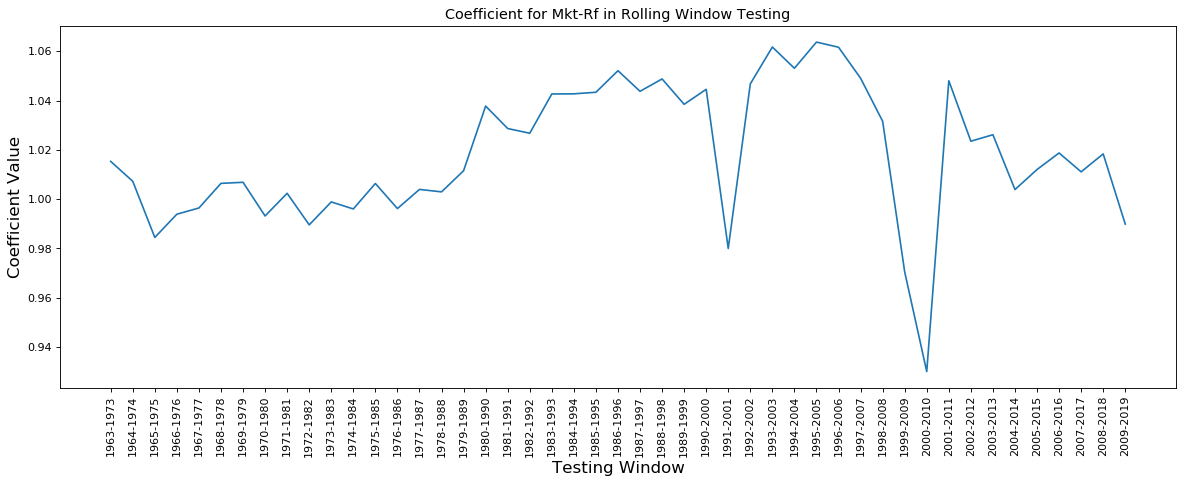

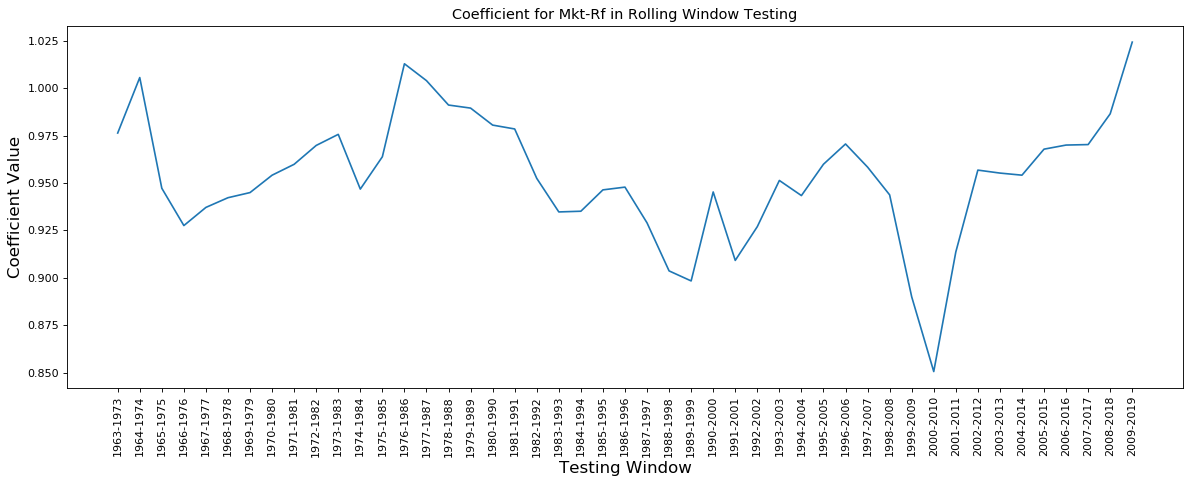

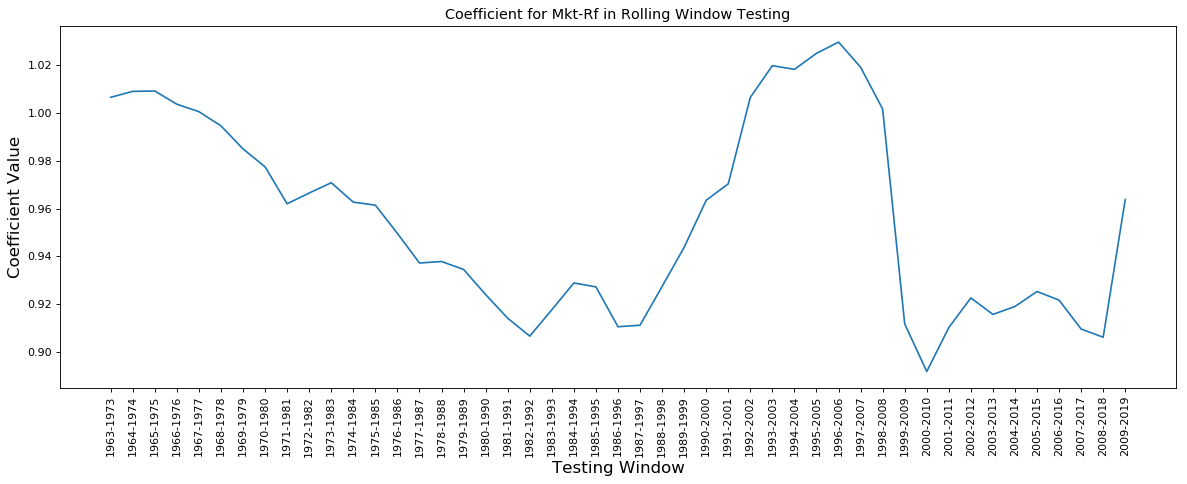

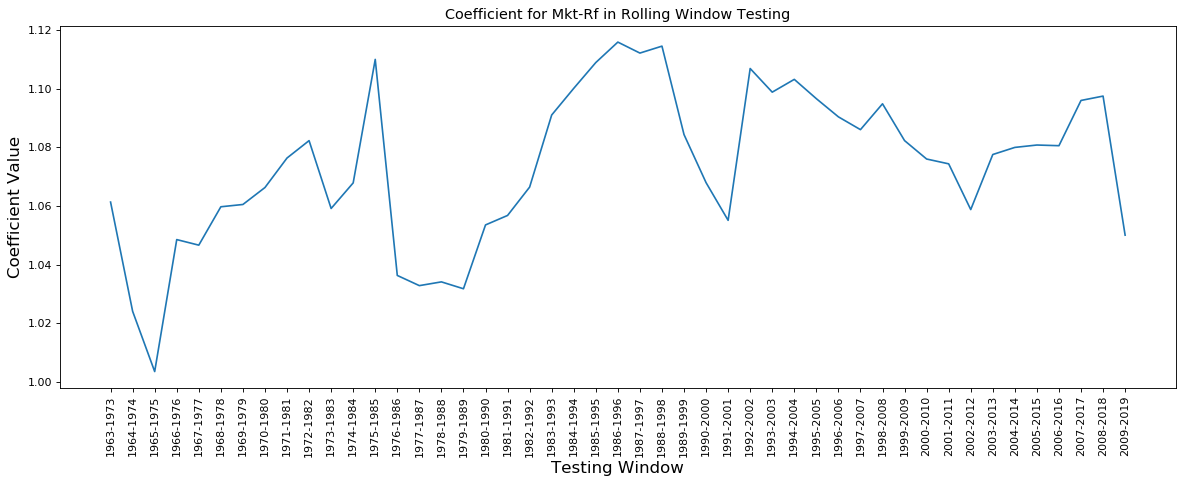

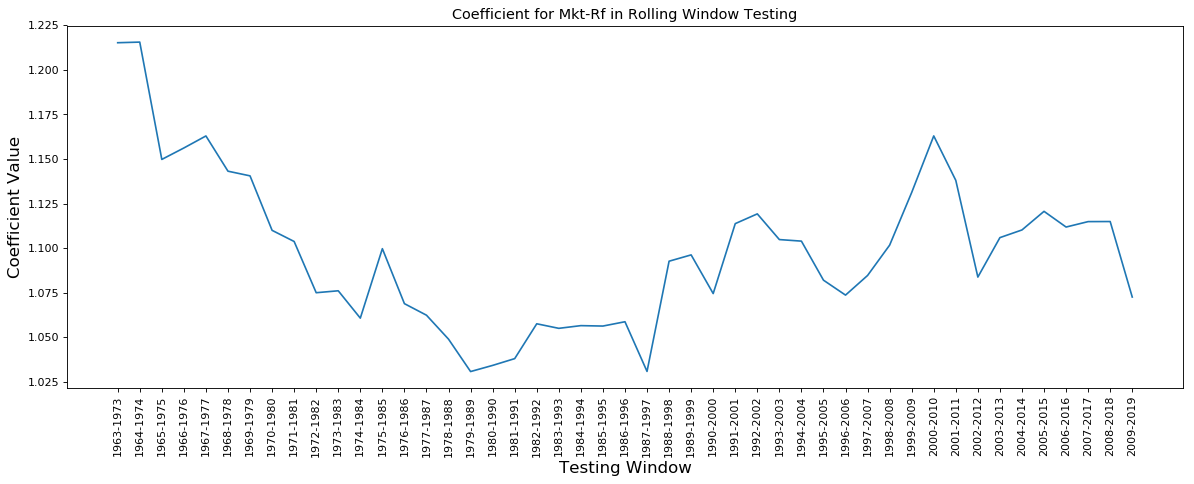

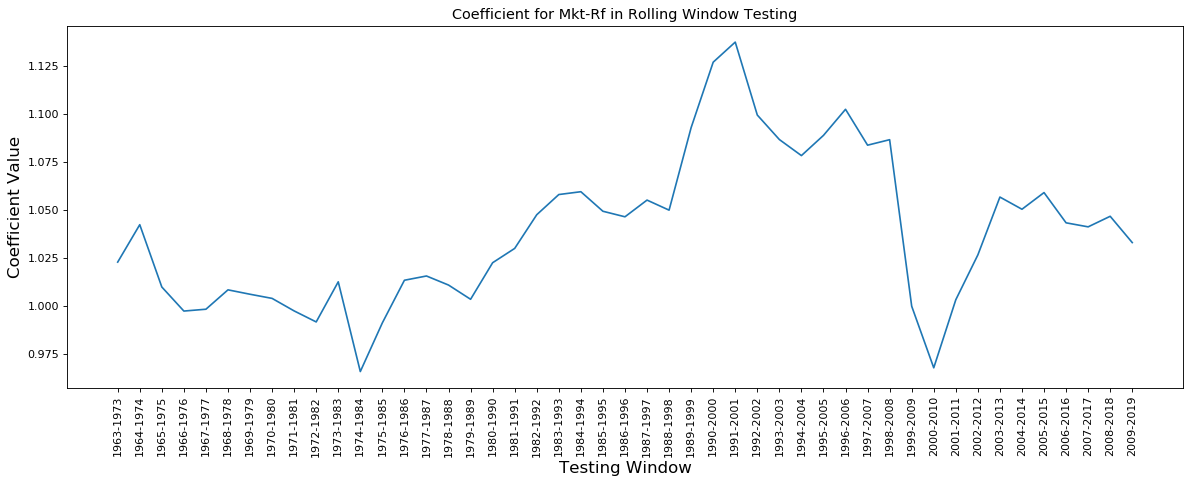

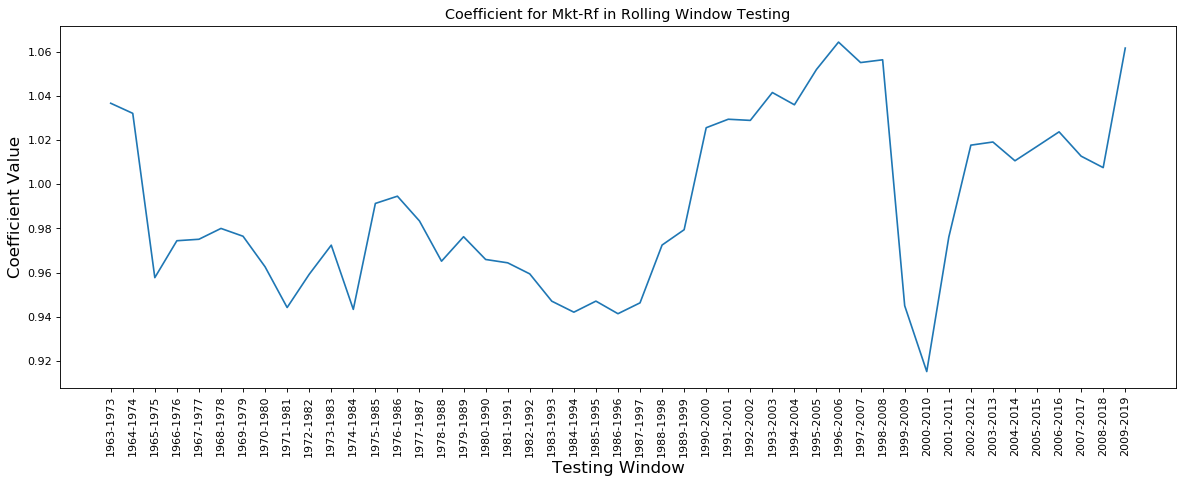

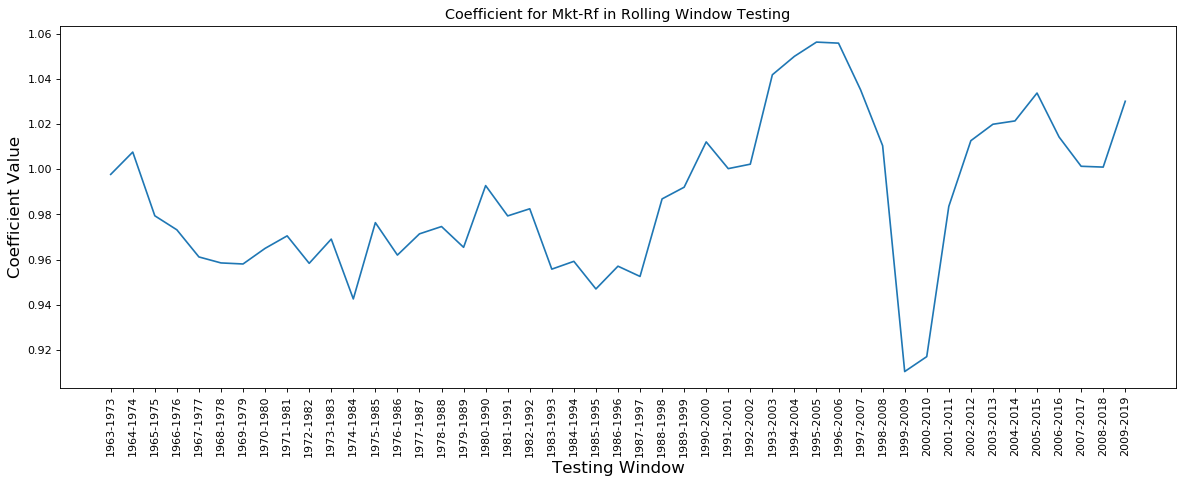

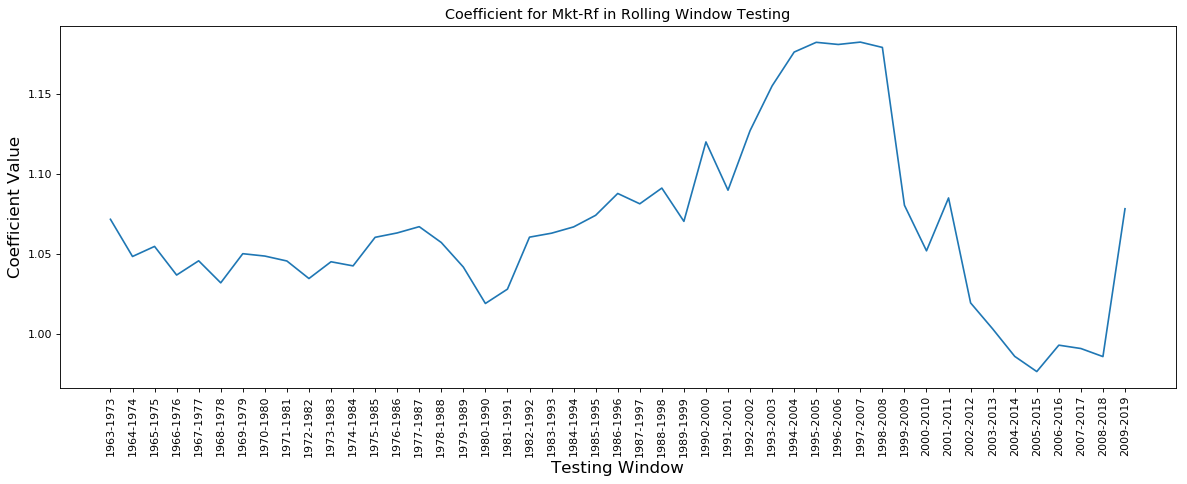

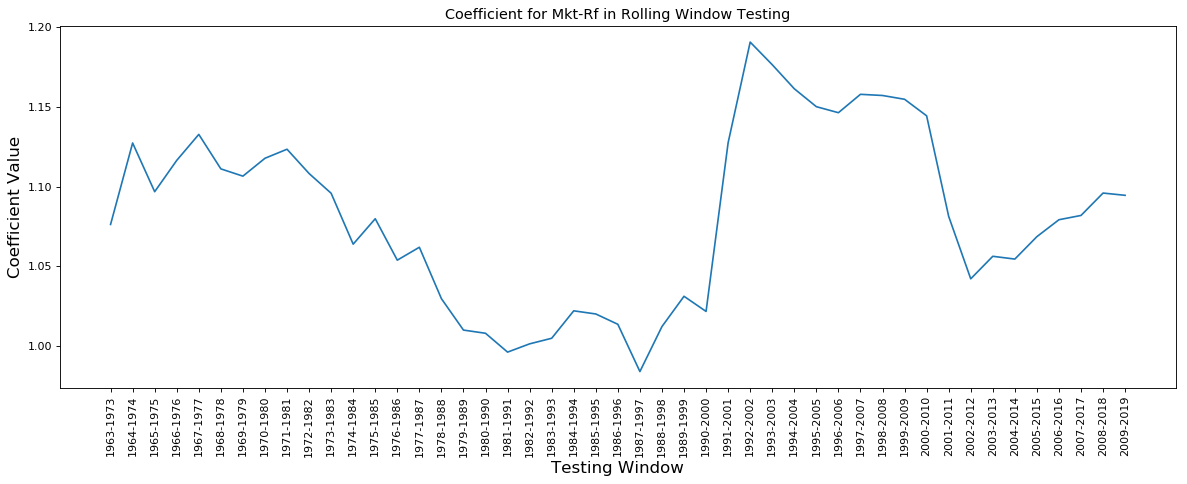

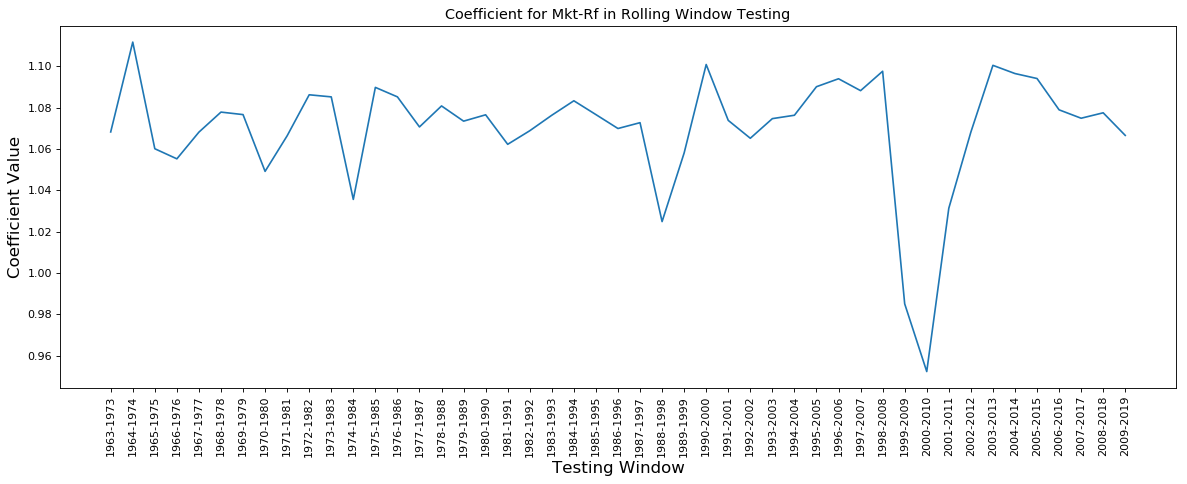

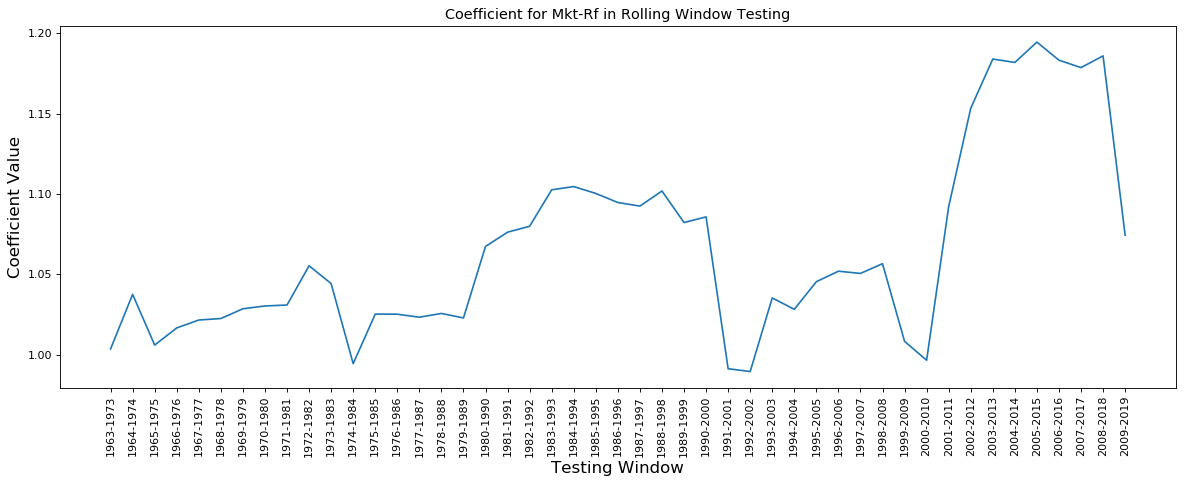

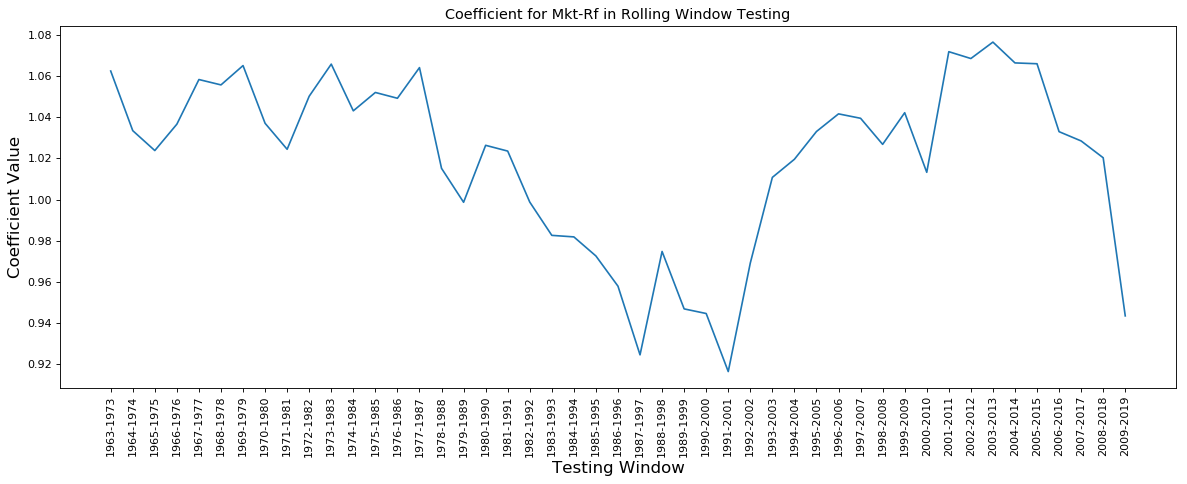

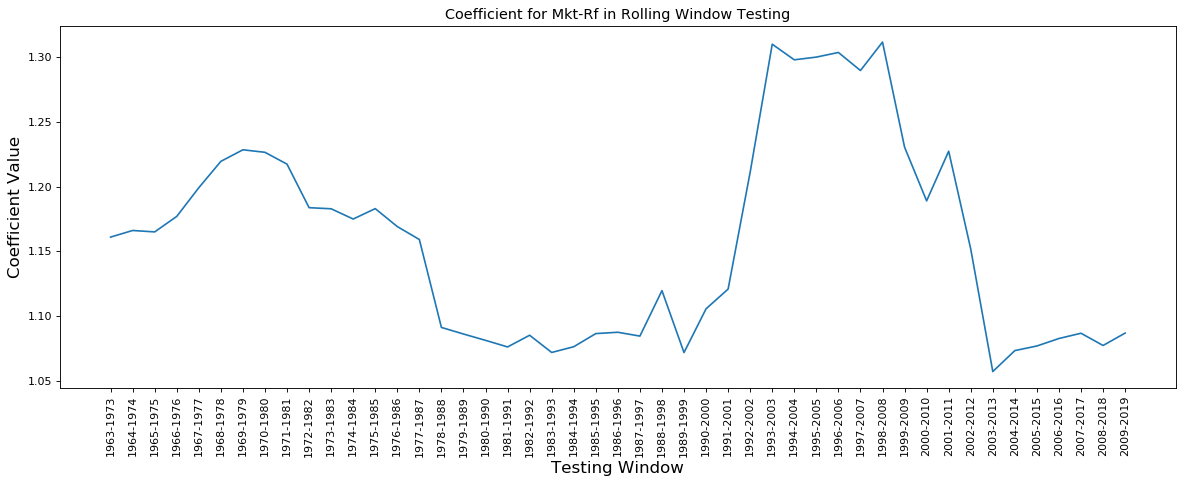

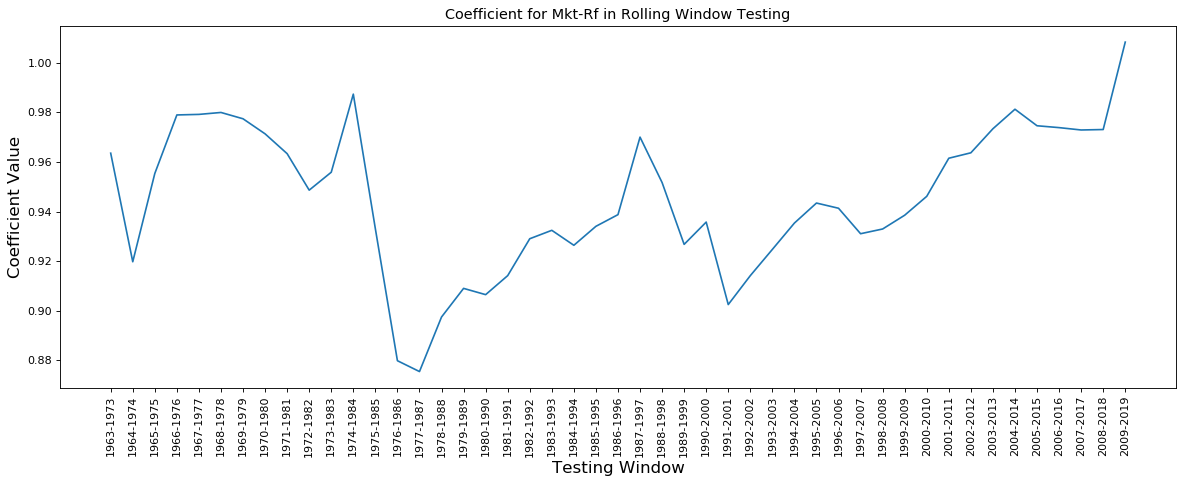

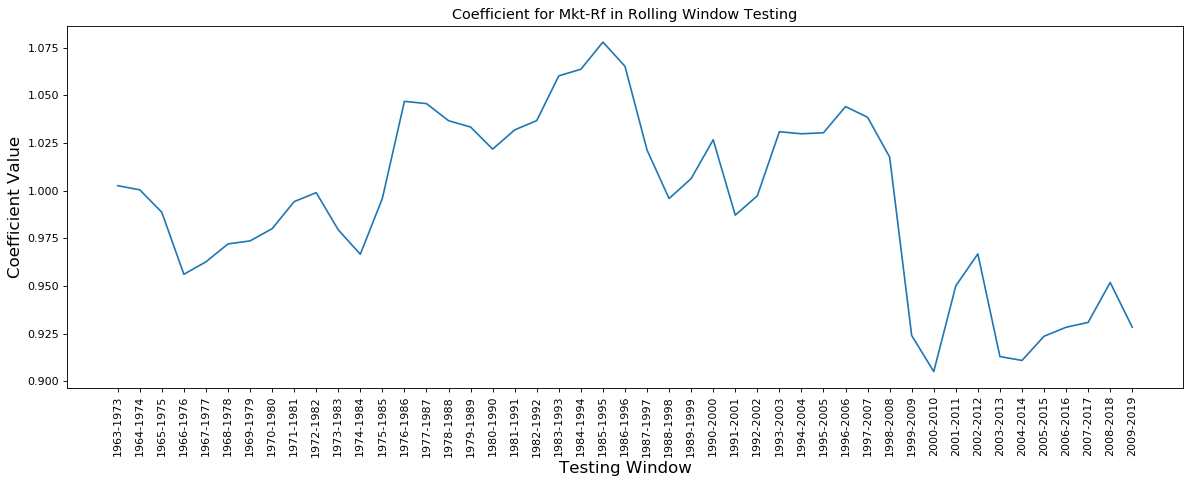

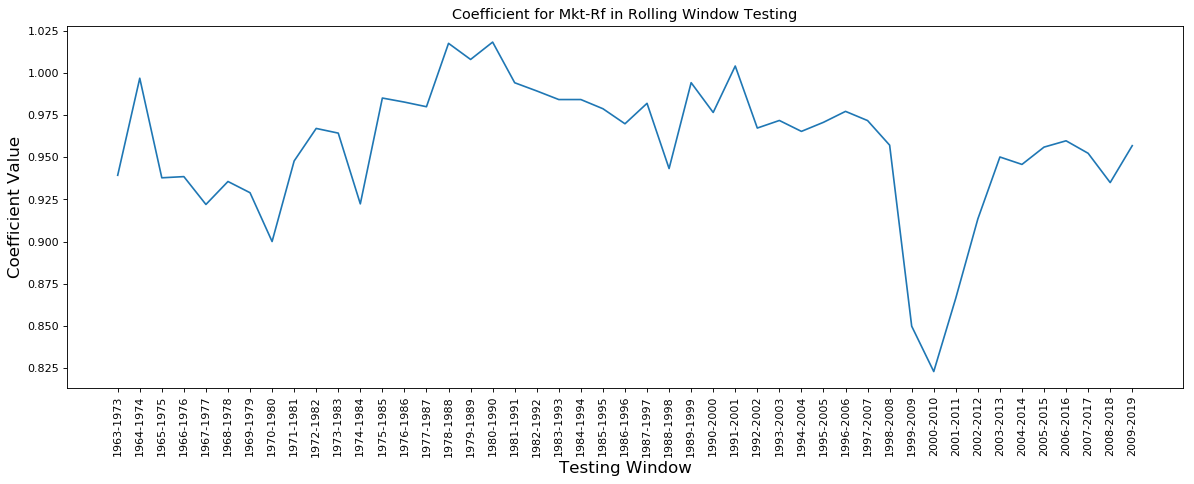

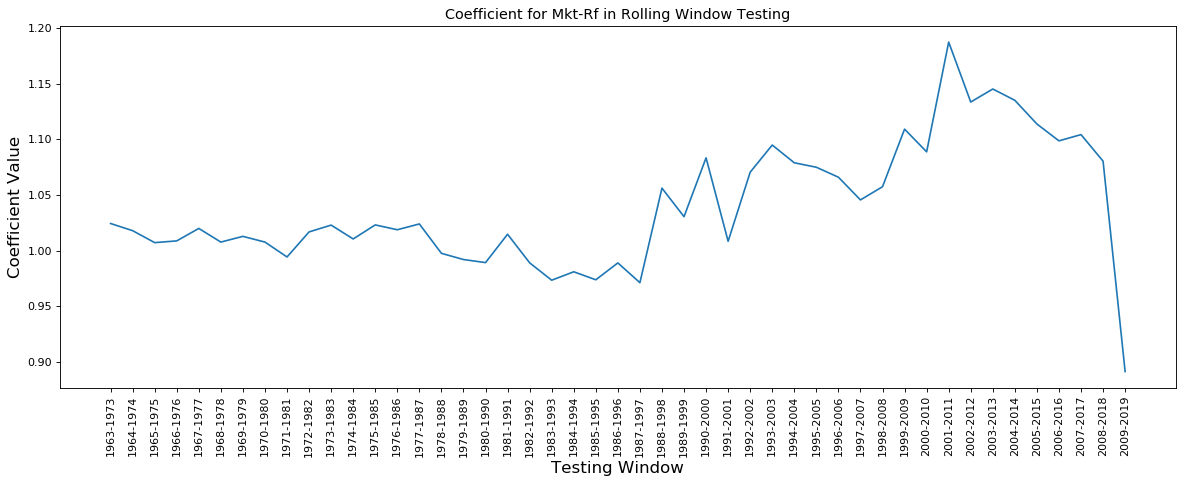

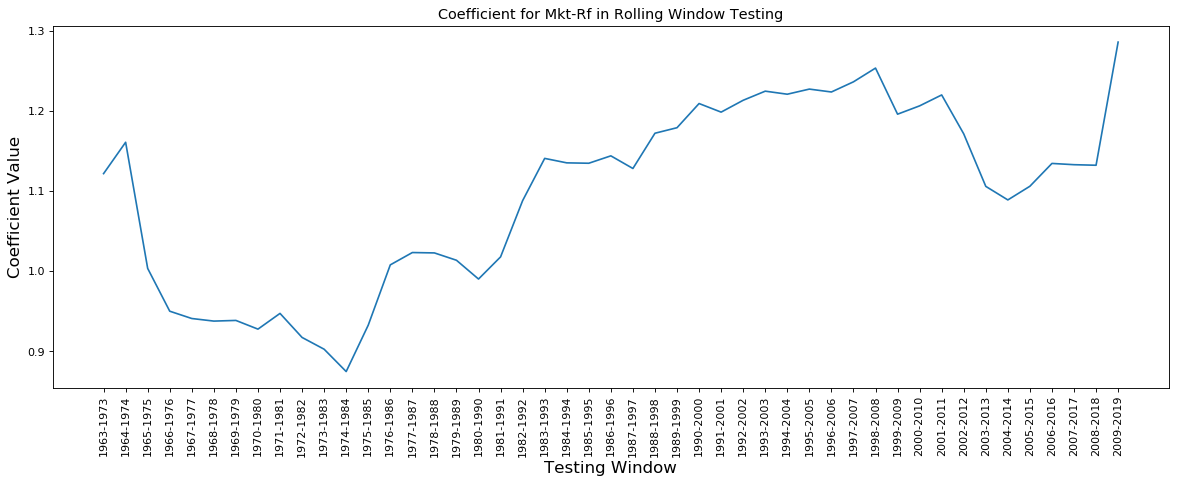

In [215]:
#In a loop, plot coeff of Mkt-Rf for each portfolio
for i in range(25):
    fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(Mkt["Portfoio{0}".format(i)])
    plt.xticks(rotation=90)
    plt.xlabel('Testing Window', size = 15)
    plt.ylabel('Coefficient Value', size = 15, rotation = 90)
    plt.title('Coefficient for Mkt-Rf in Rolling Window Testing', size = 13)
    plt.xticks(size = 10)

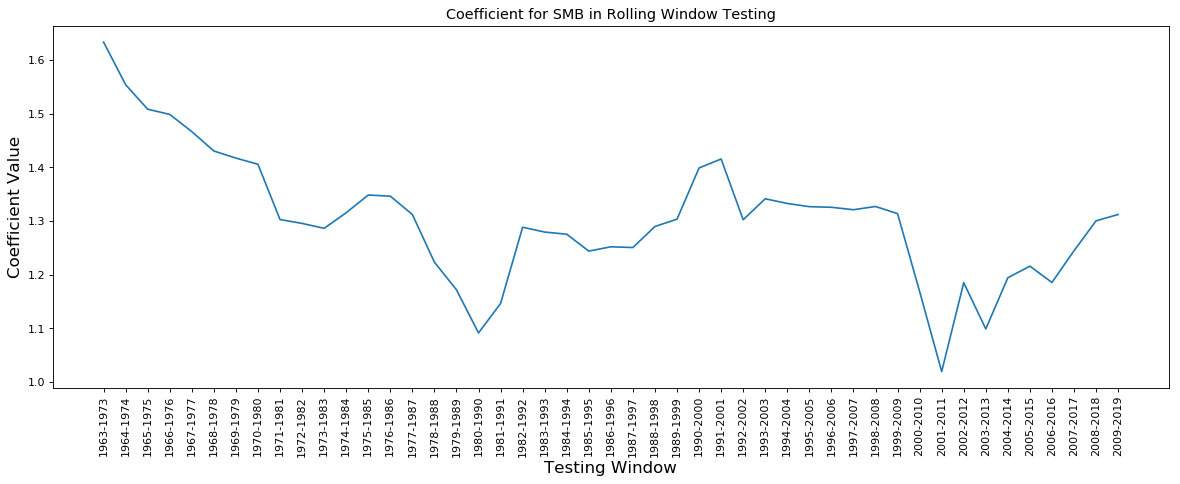

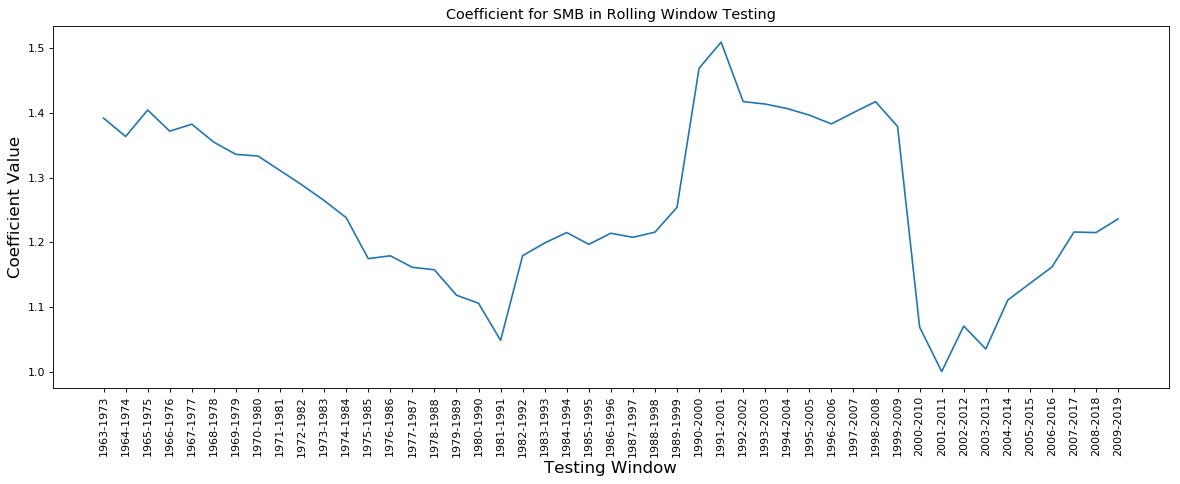

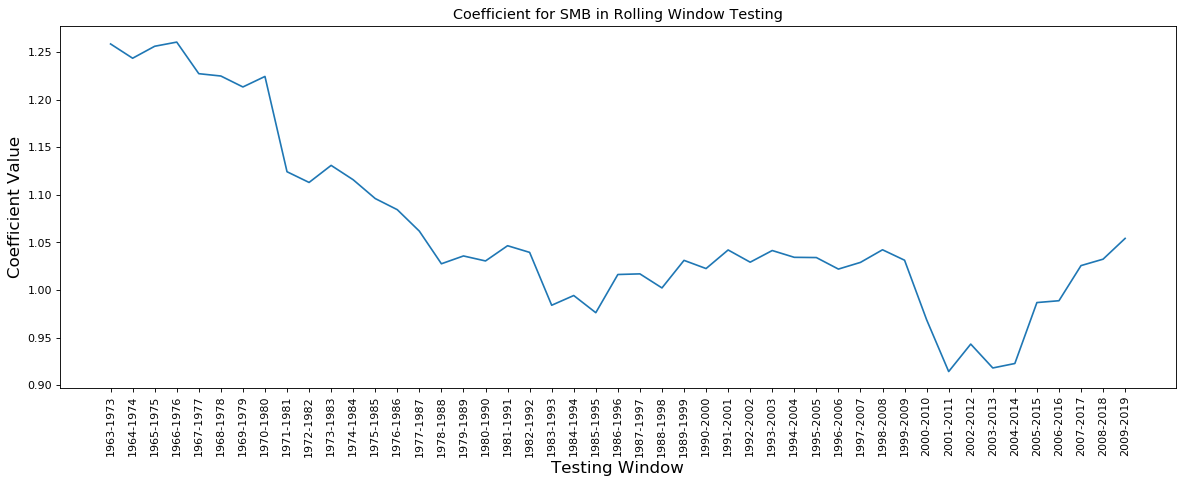

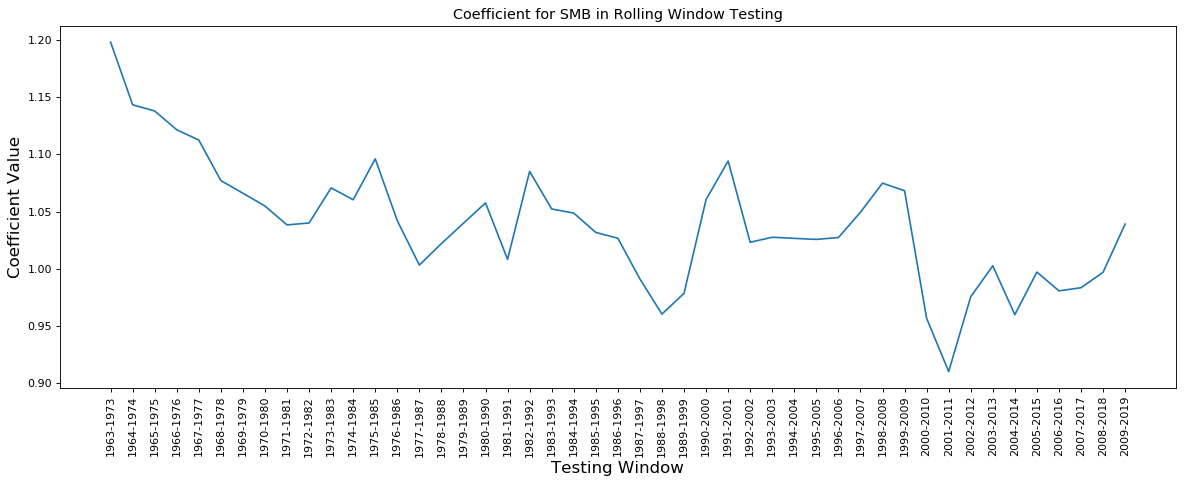

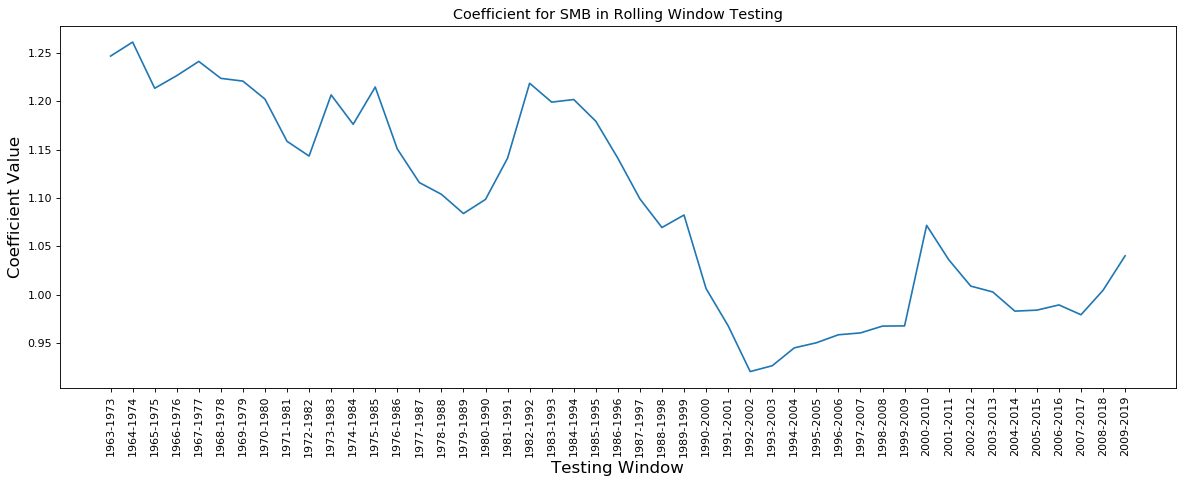

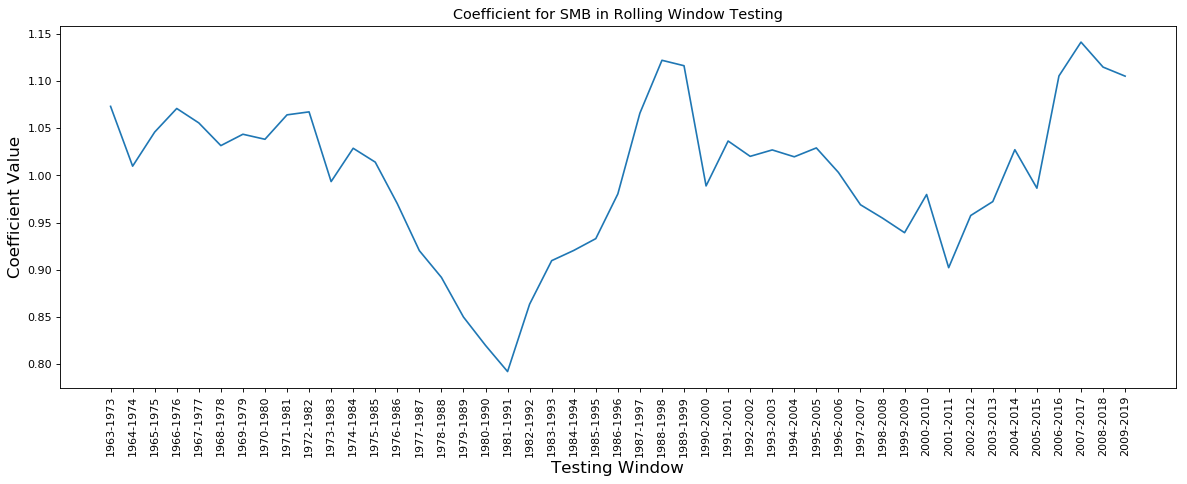

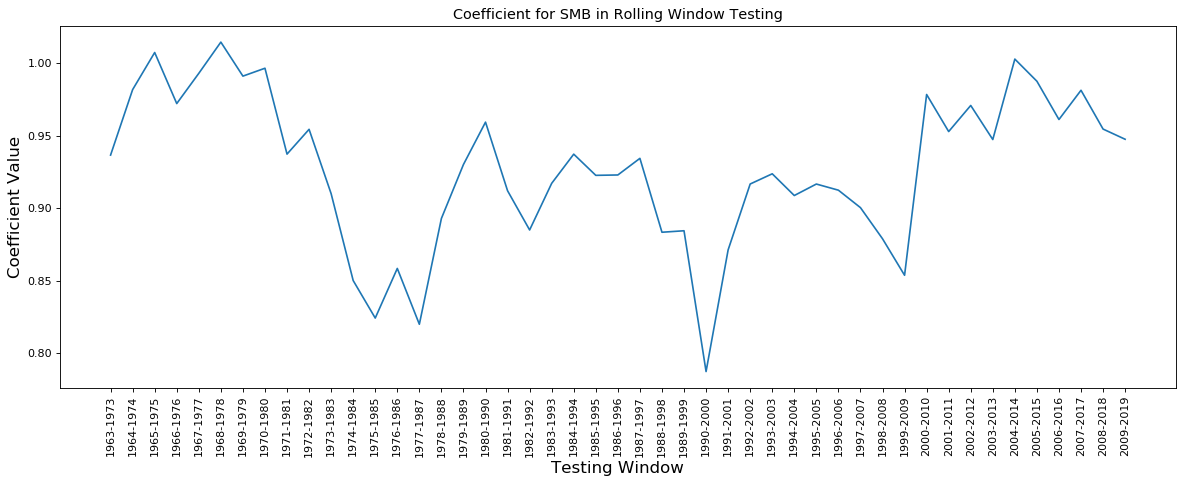

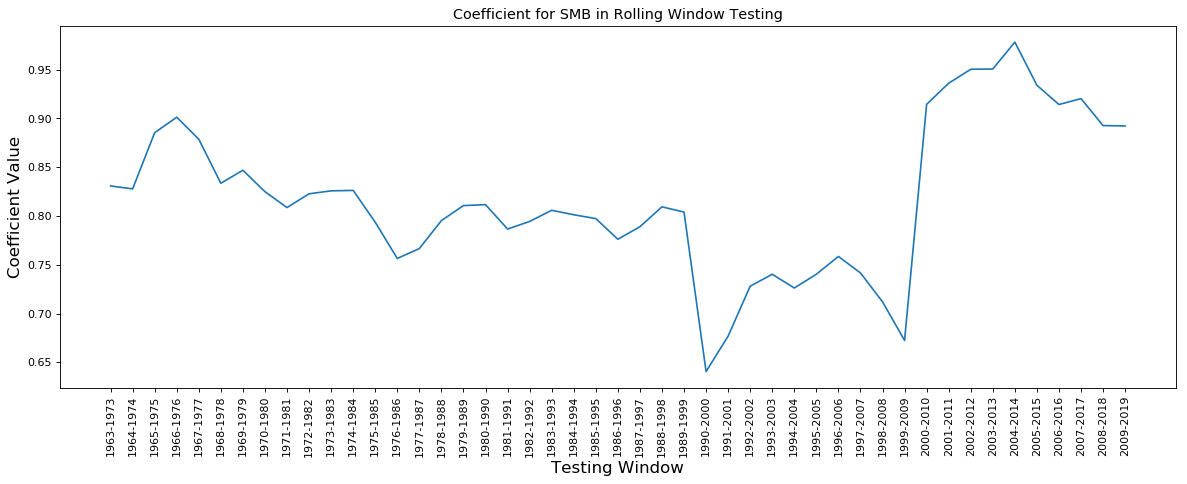

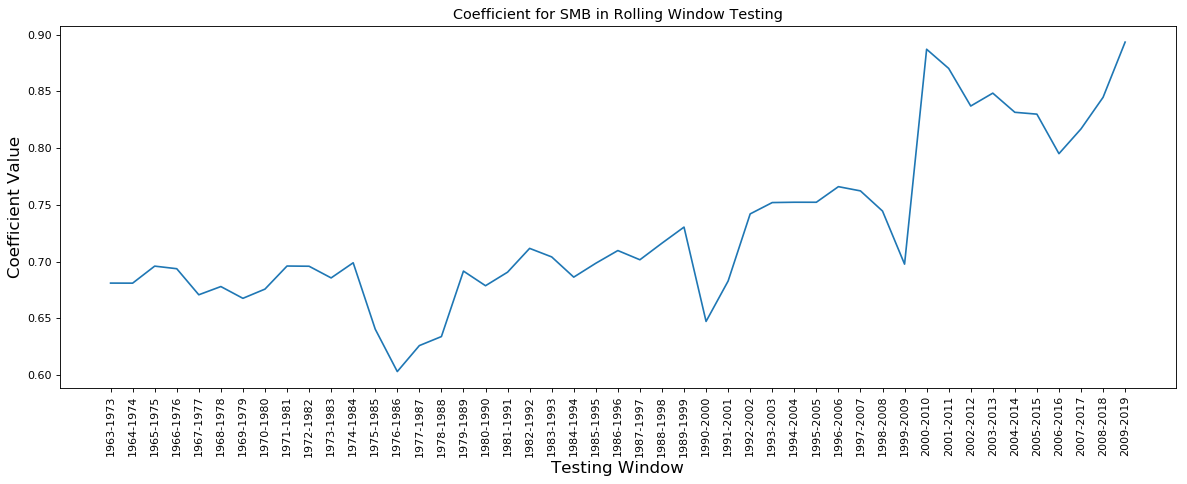

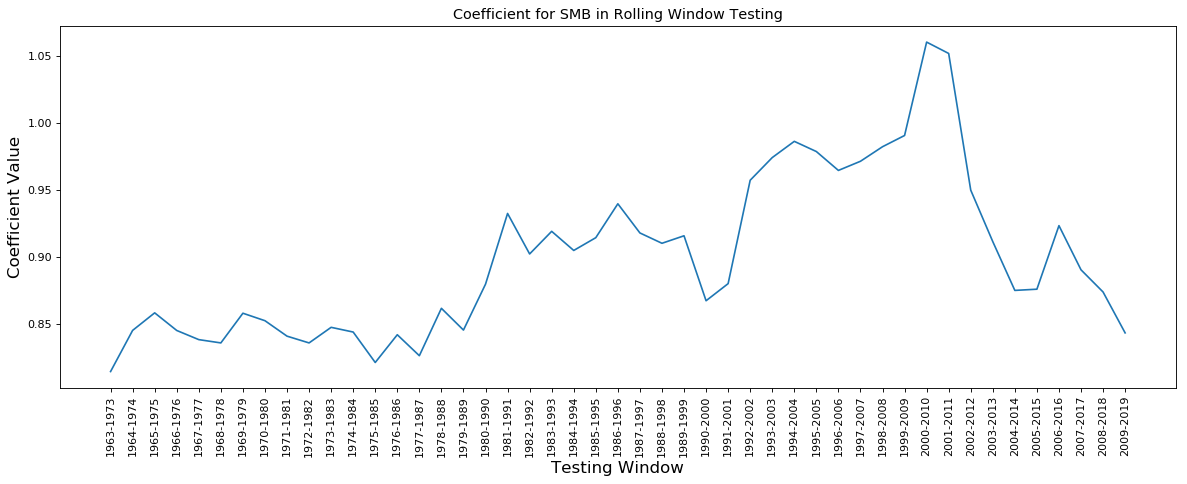

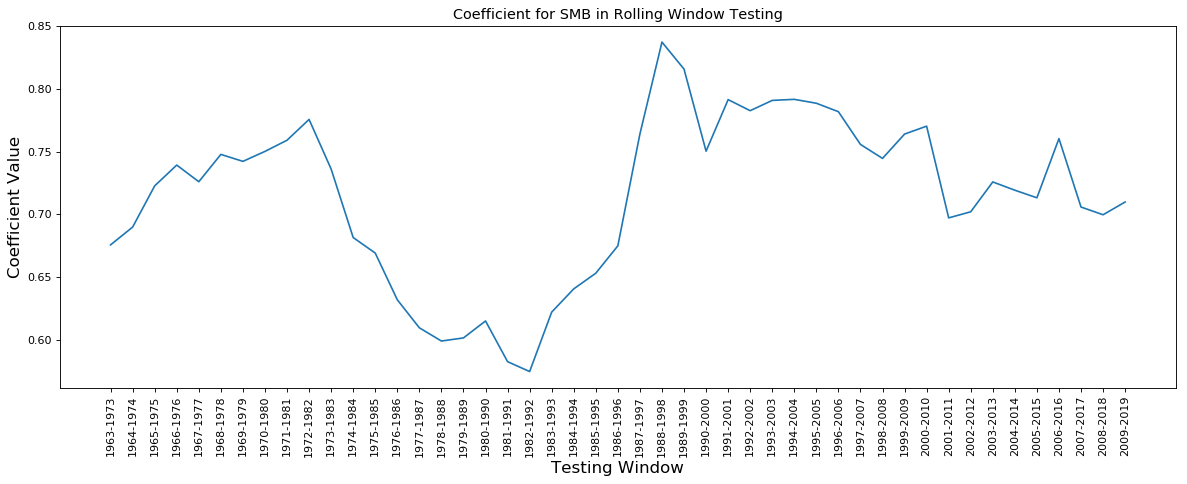

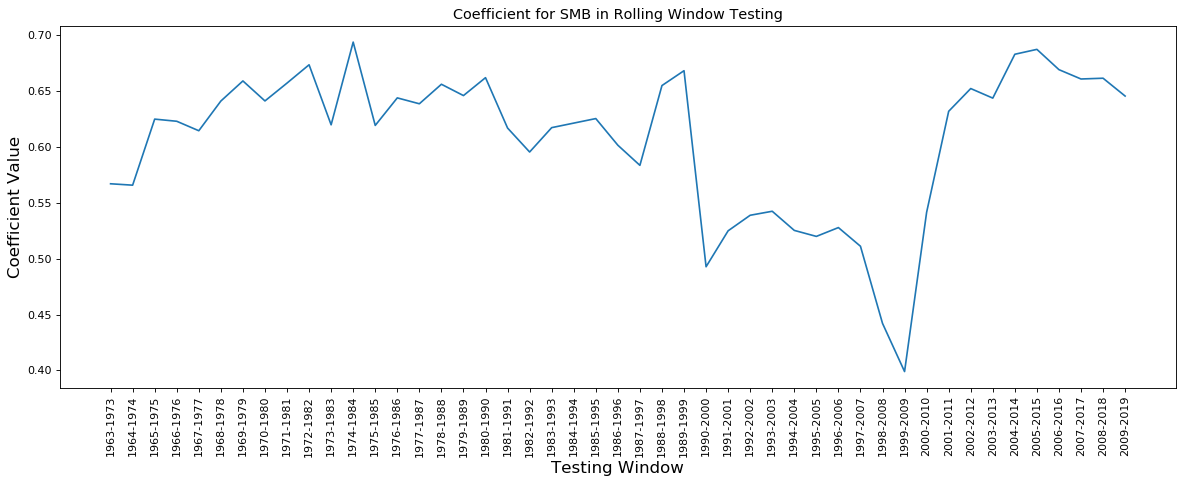

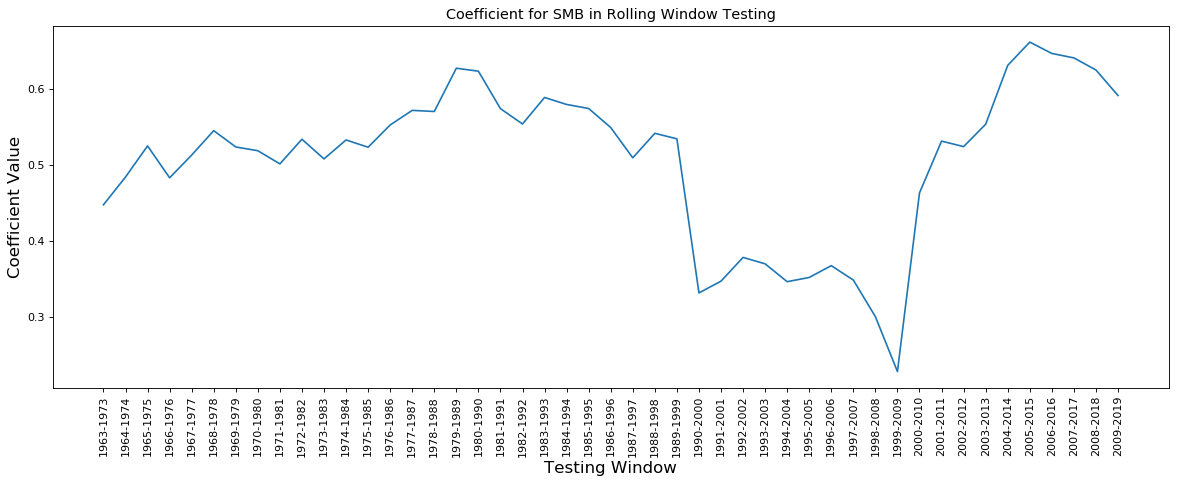

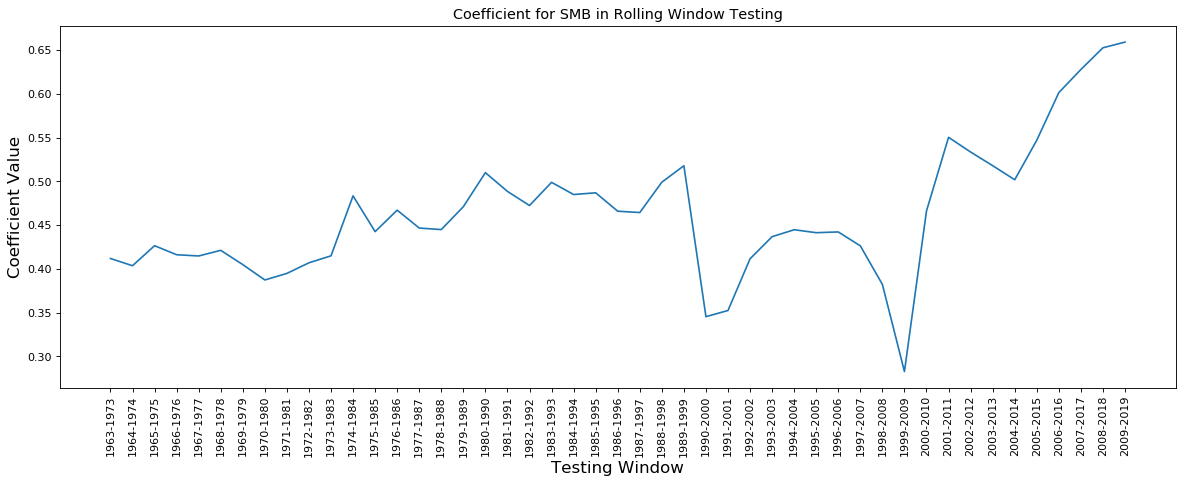

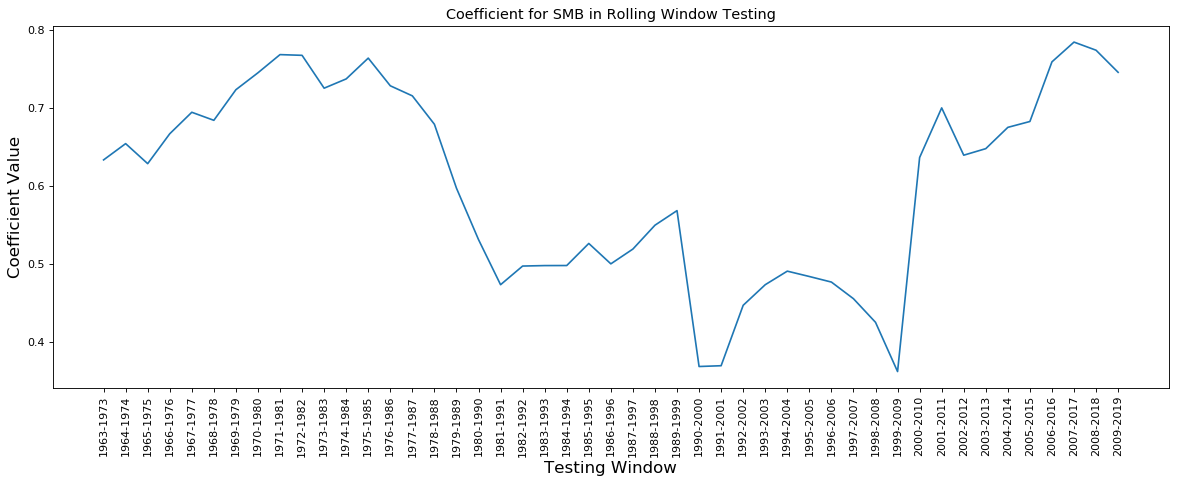

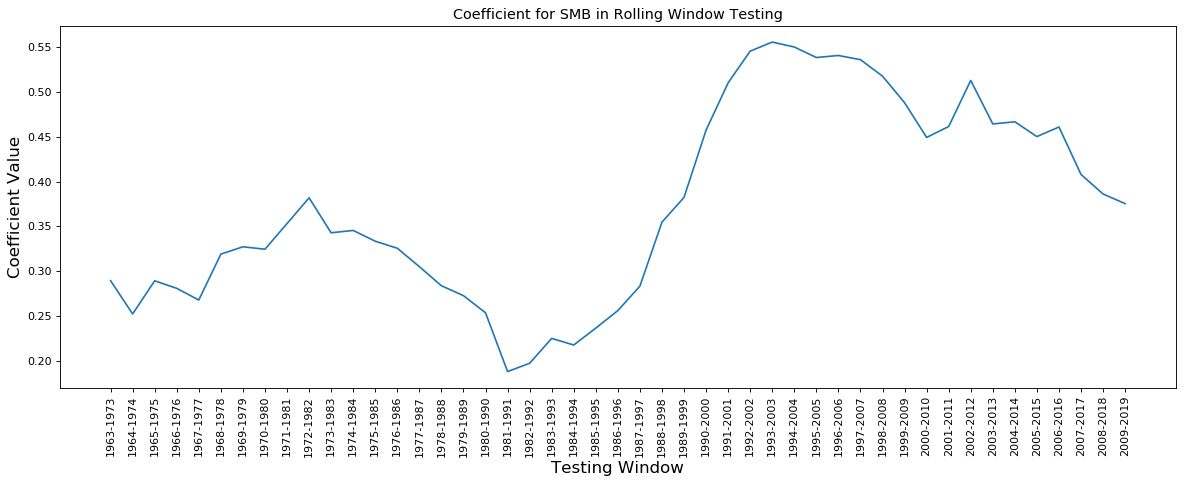

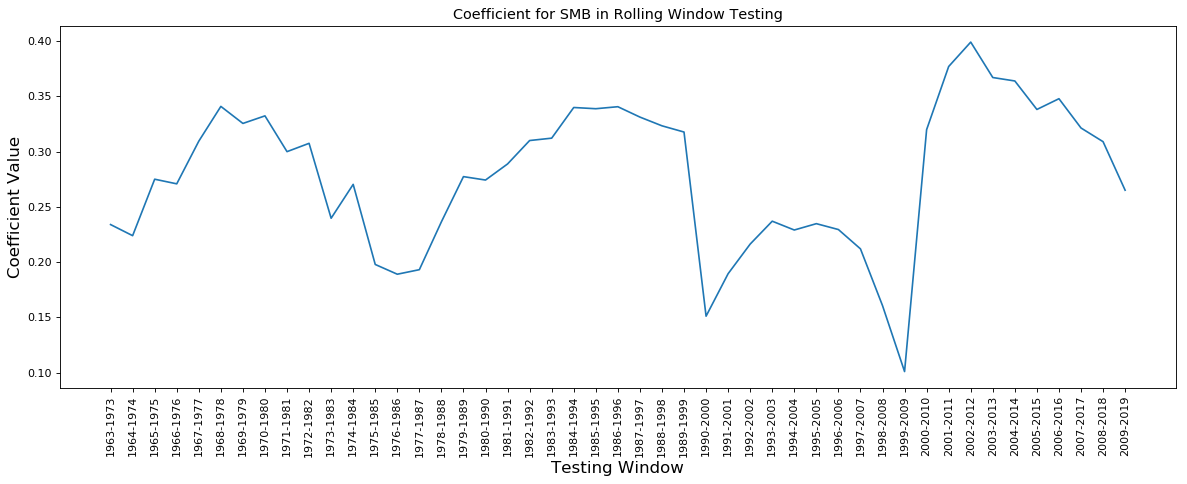

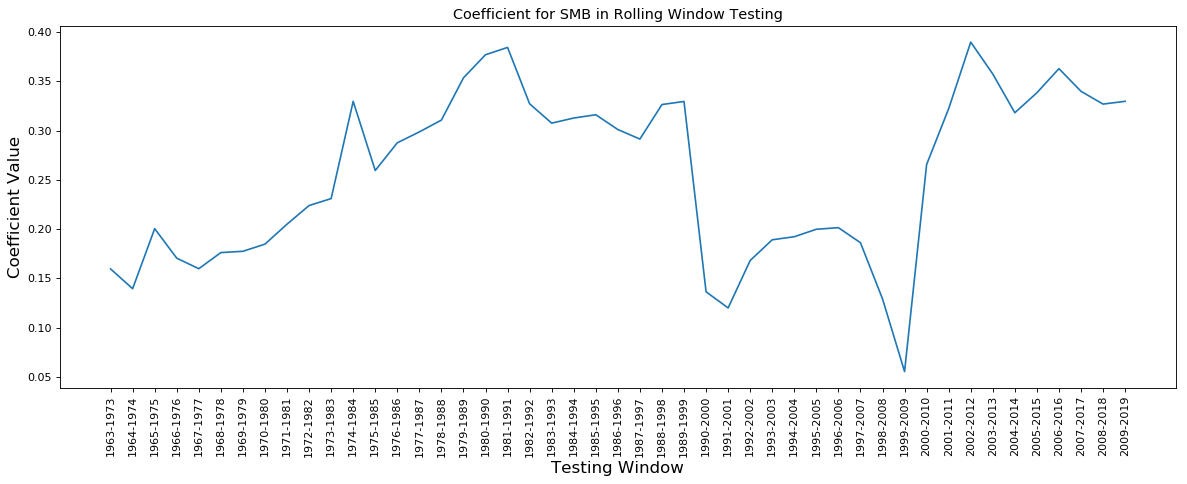

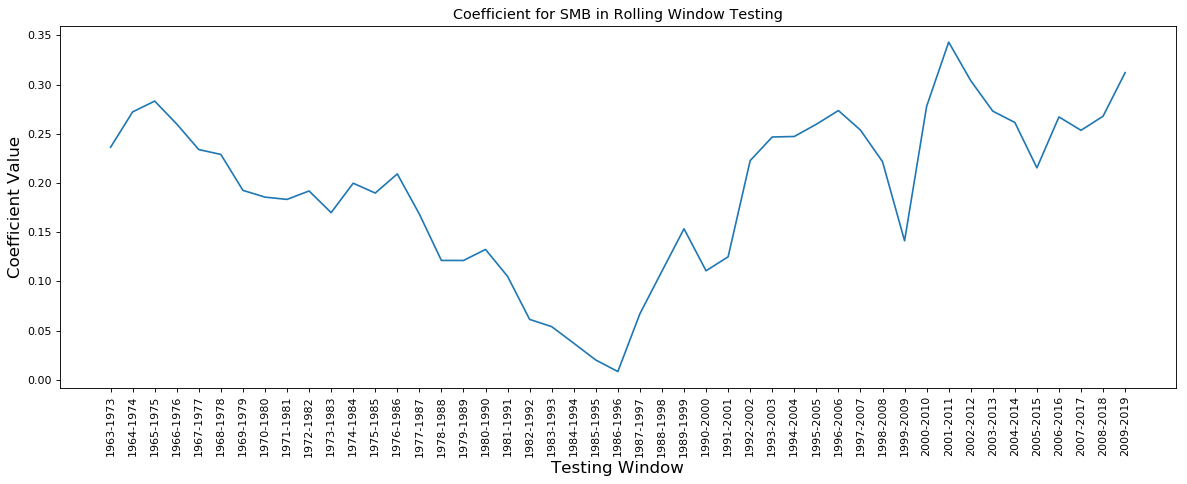

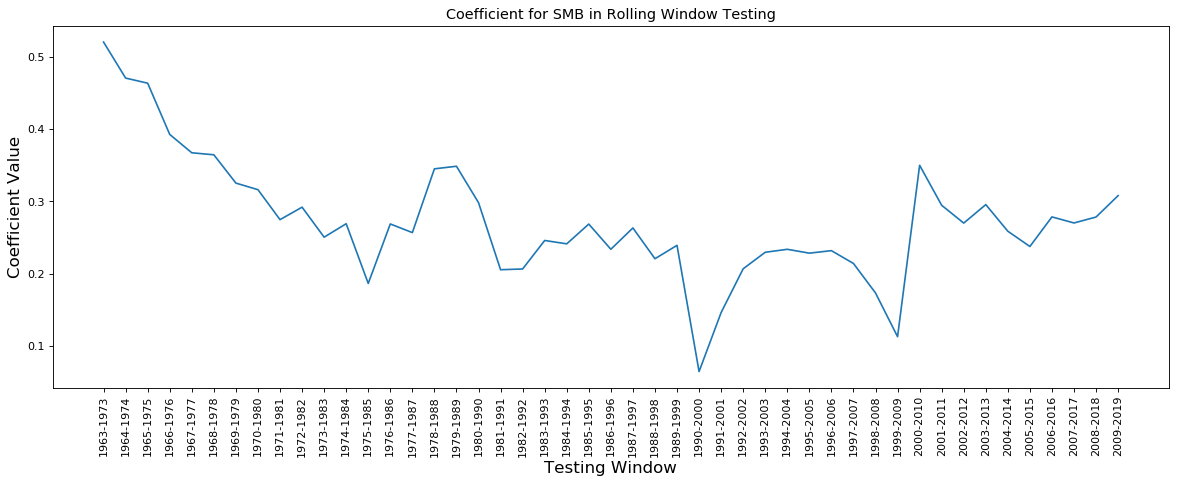

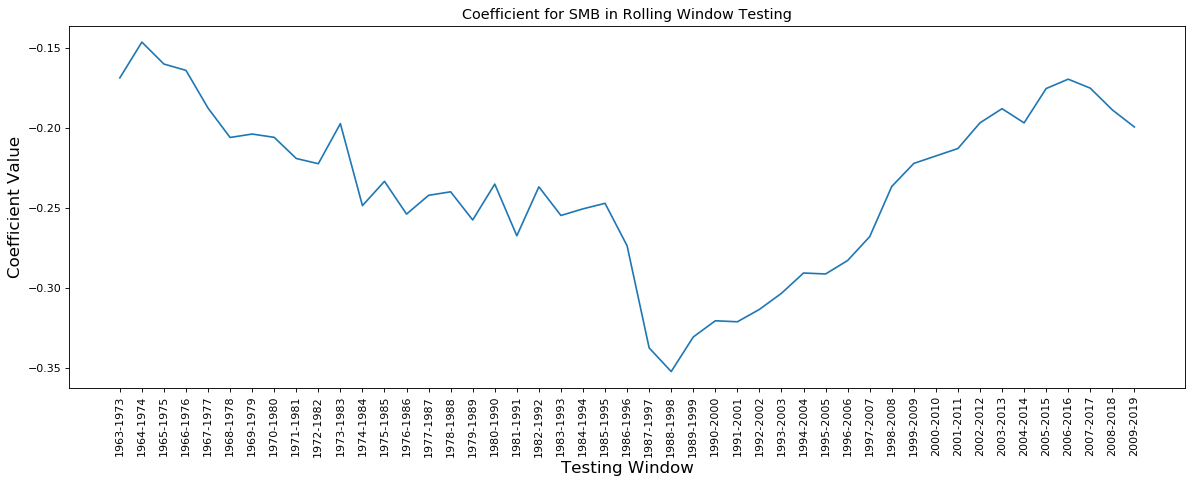

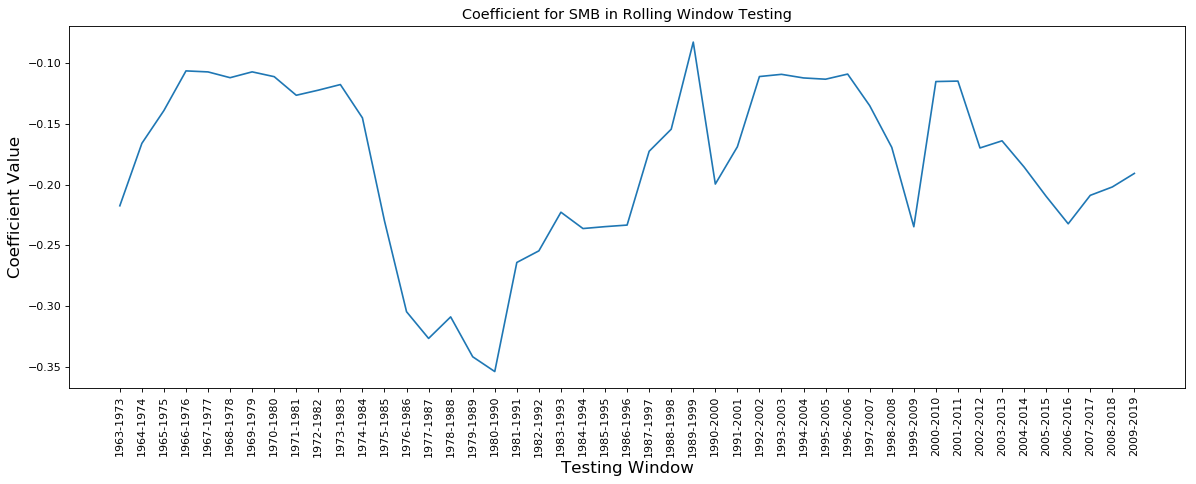

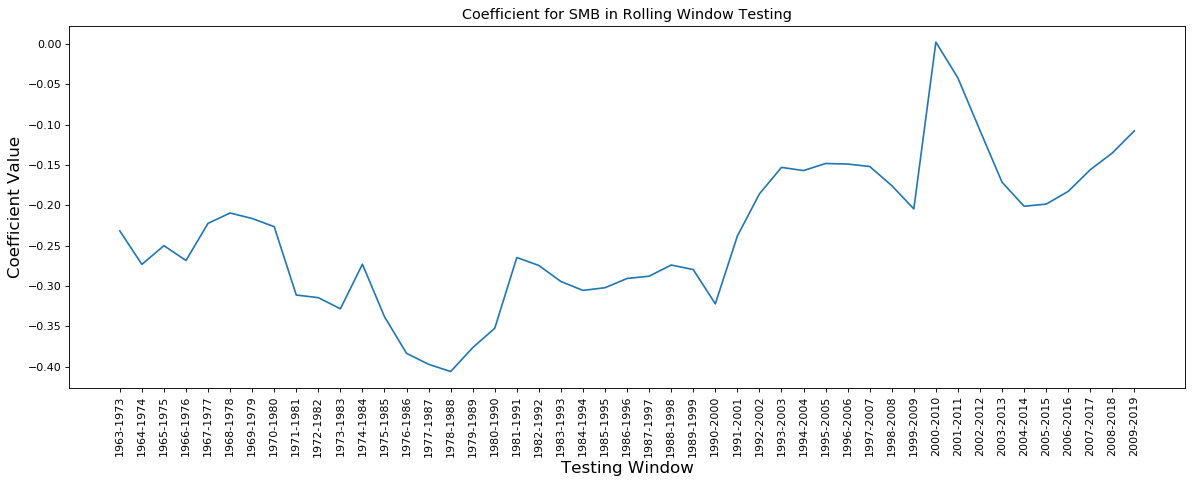

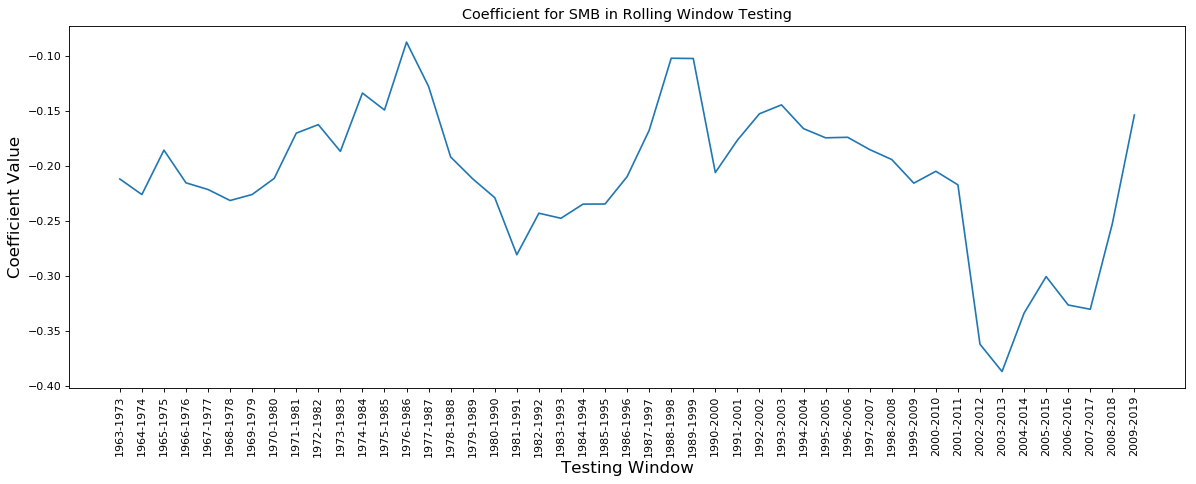

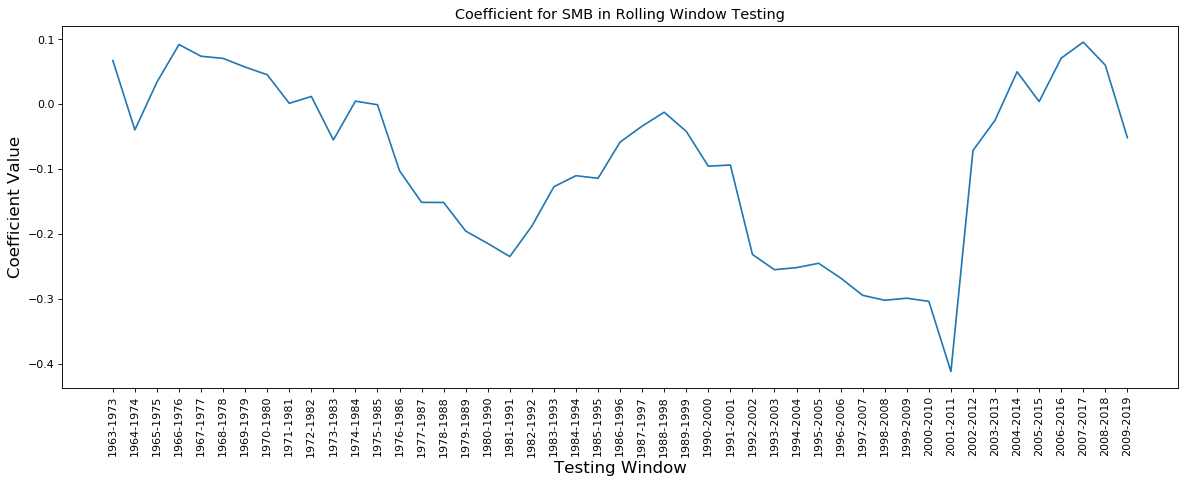

In [216]:
#In a loop, plot coeff of SMB for each portfolio
for i in range(25):
    fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(SMB["Portfoio{0}".format(i)])
    plt.xticks(rotation=90)
    plt.xlabel('Testing Window', size = 15)
    plt.ylabel('Coefficient Value', size = 15, rotation = 90)
    plt.title('Coefficient for SMB in Rolling Window Testing', size = 13)
    plt.xticks(size = 10)

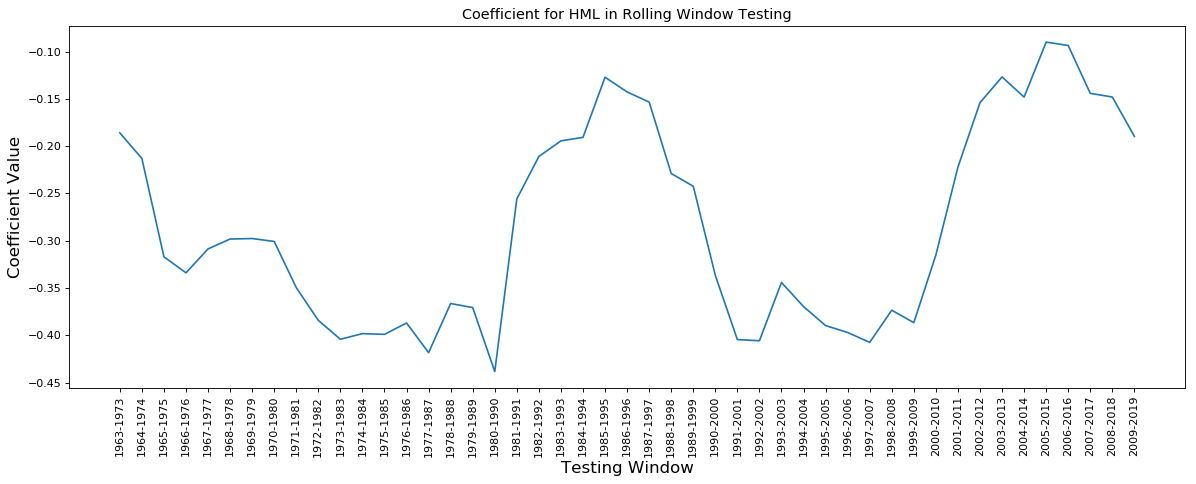

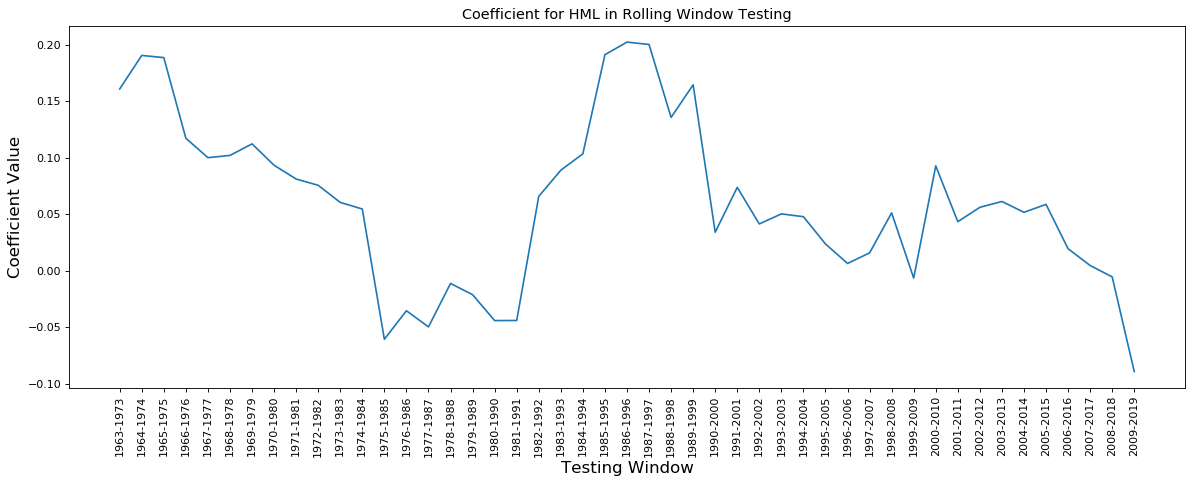

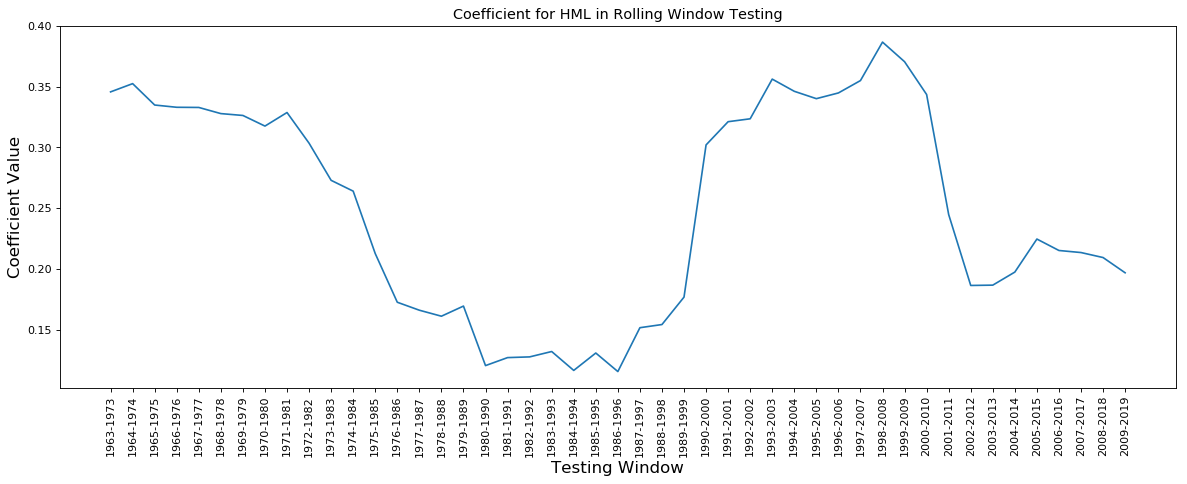

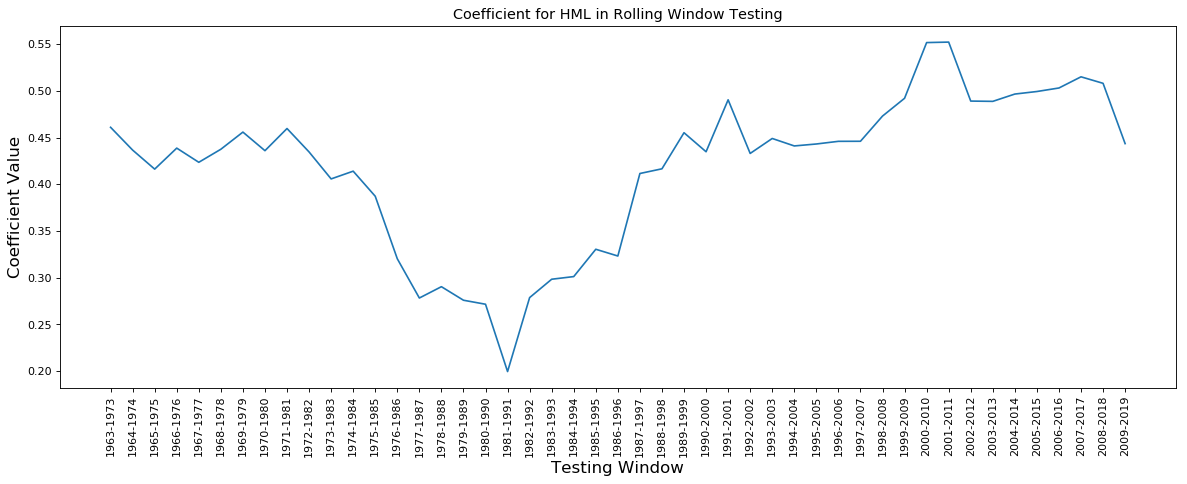

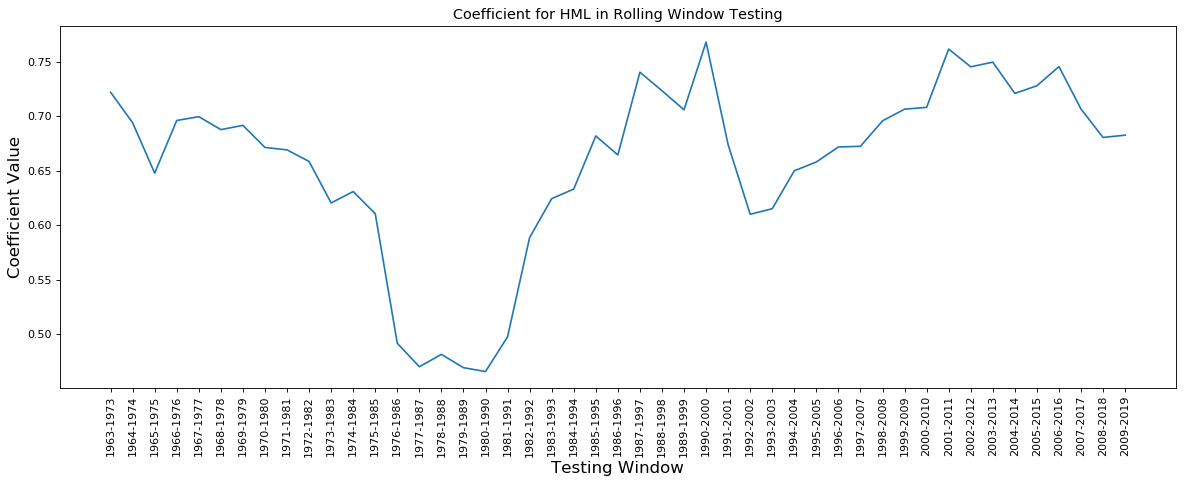

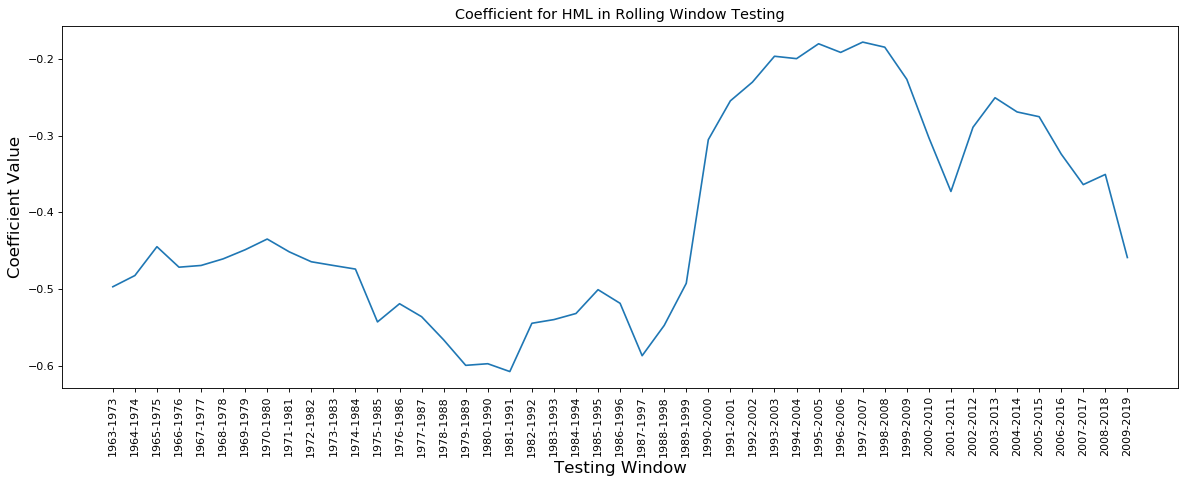

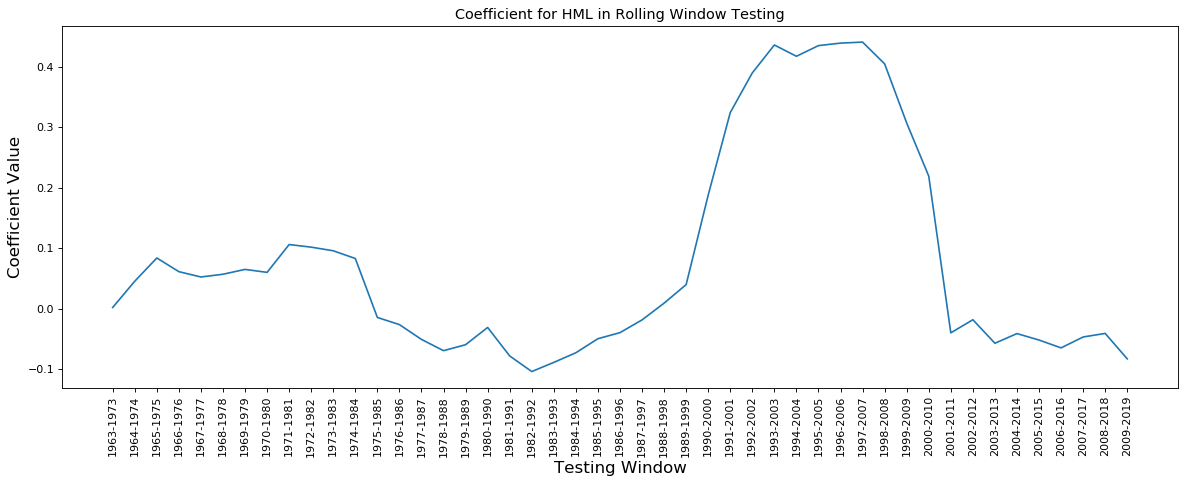

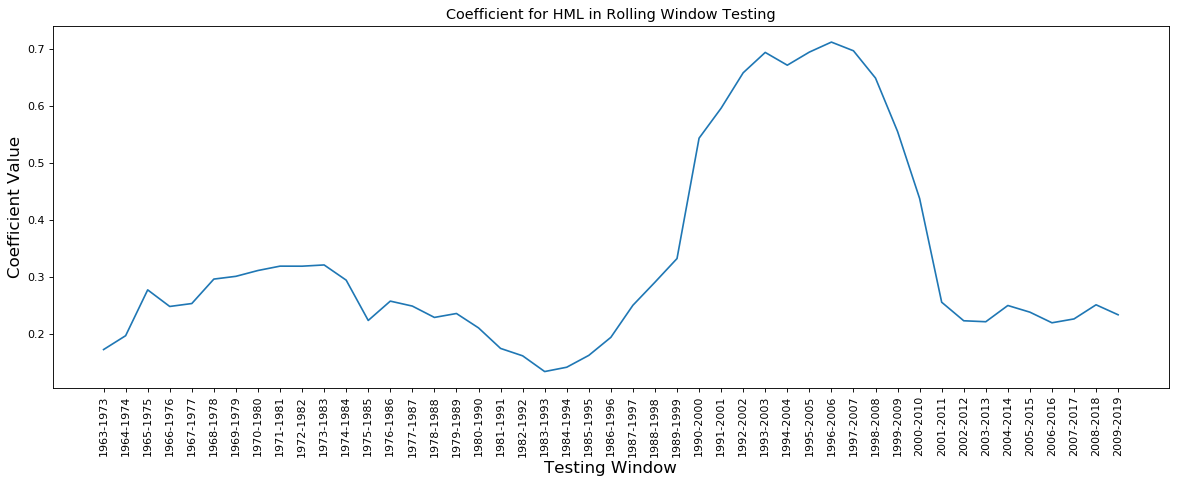

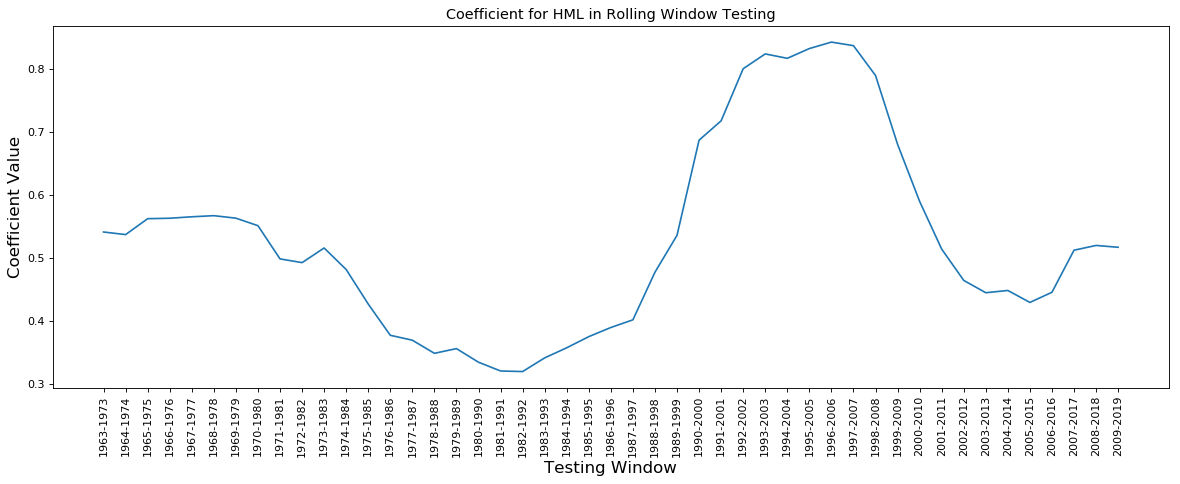

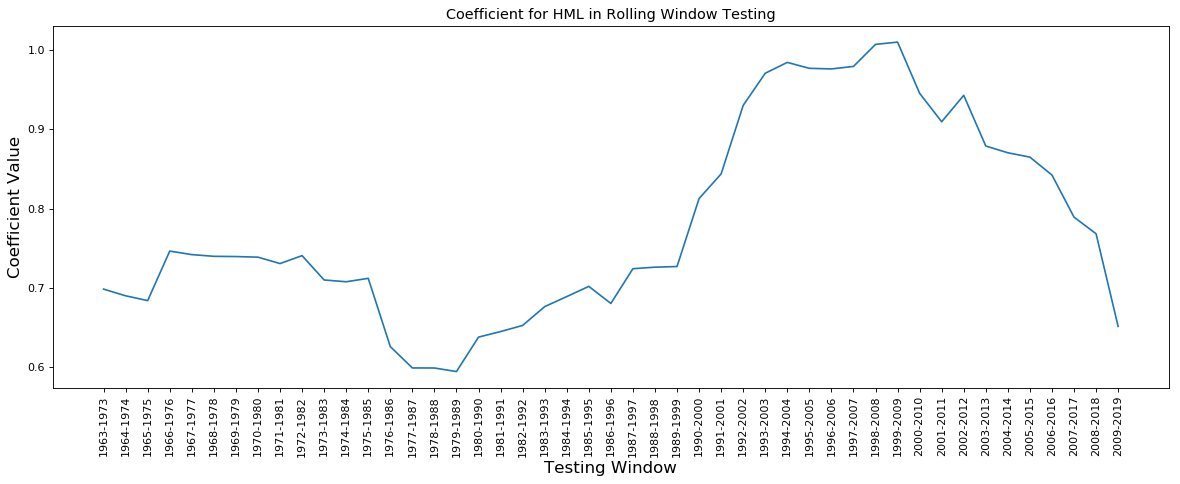

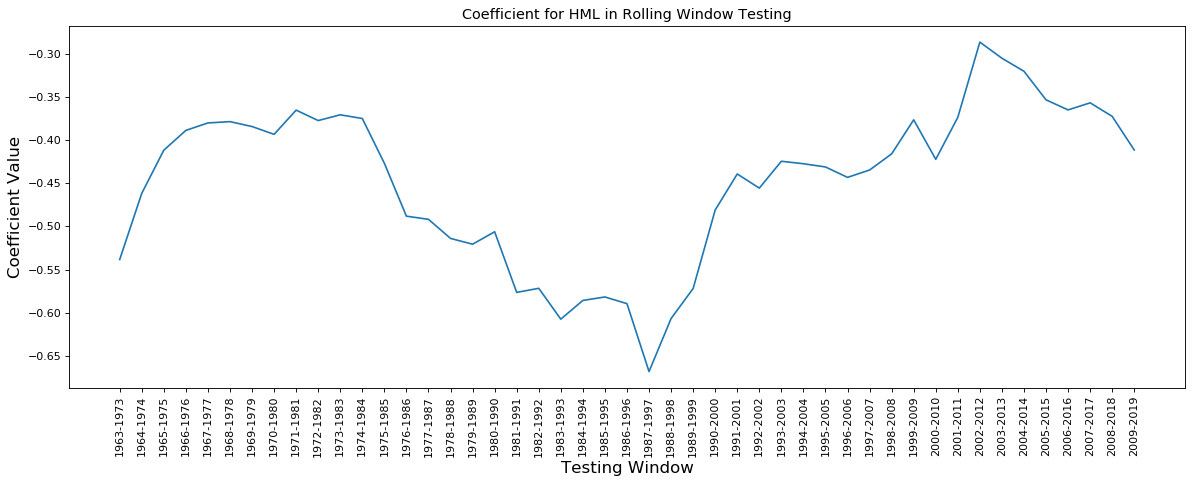

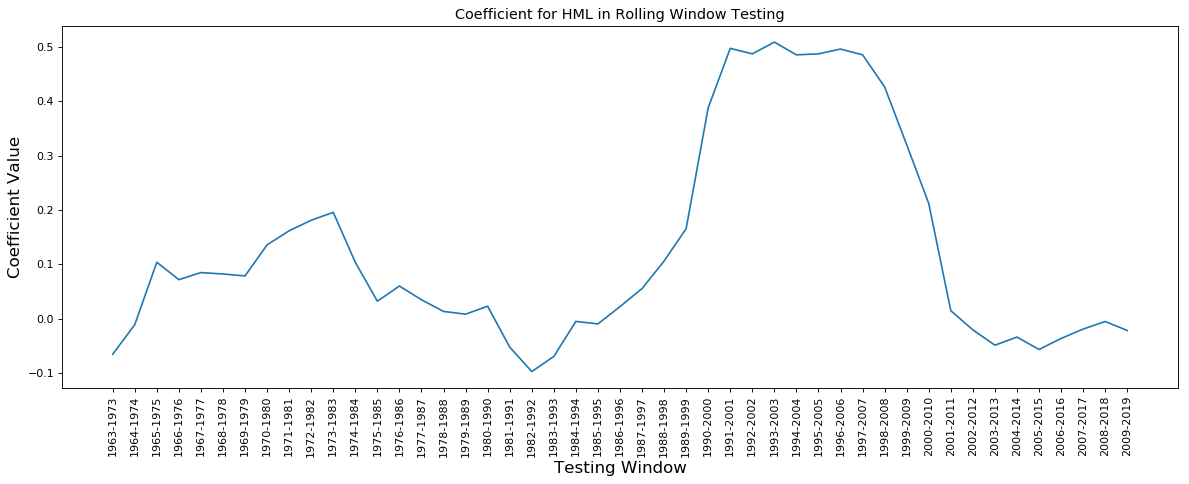

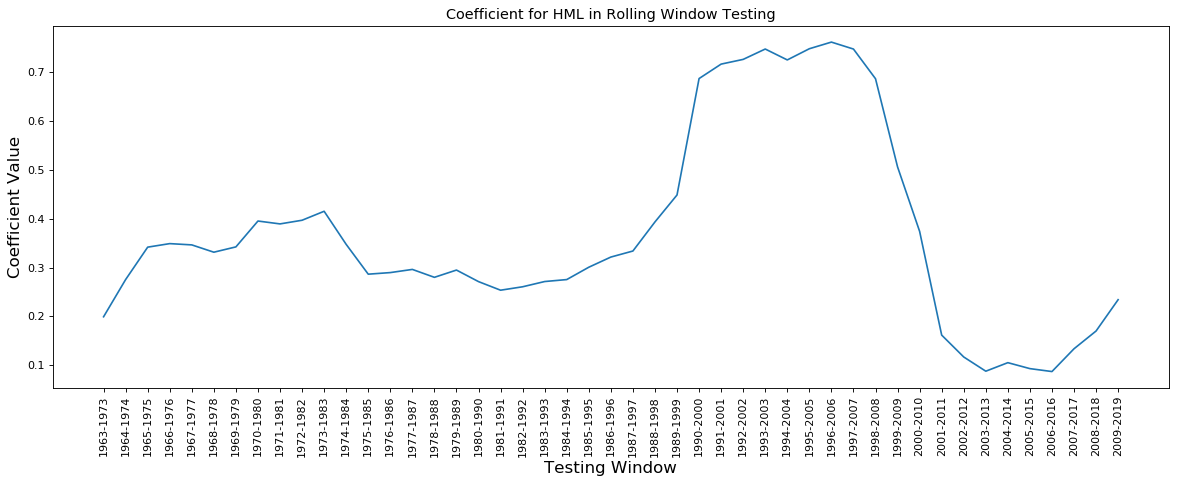

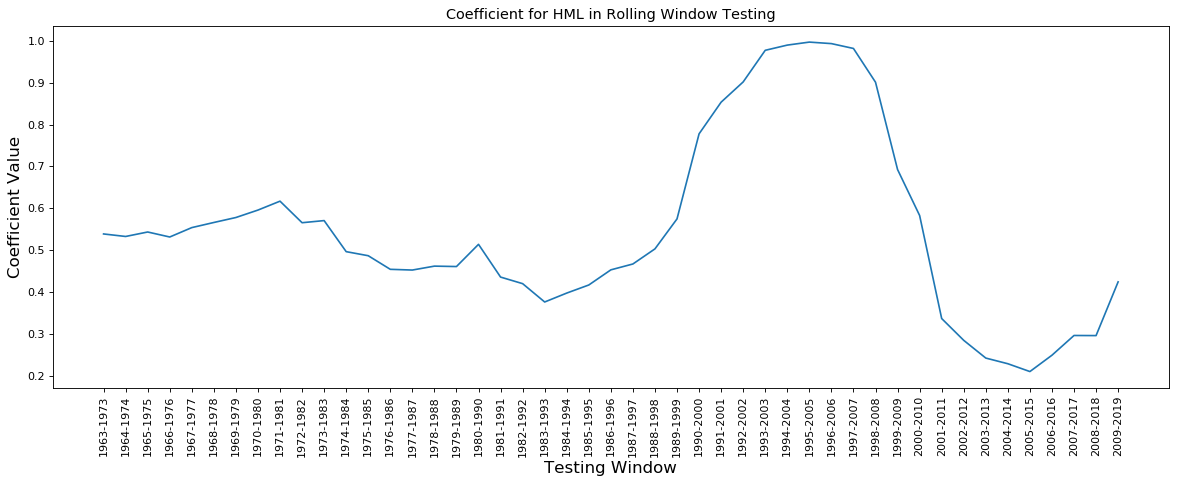

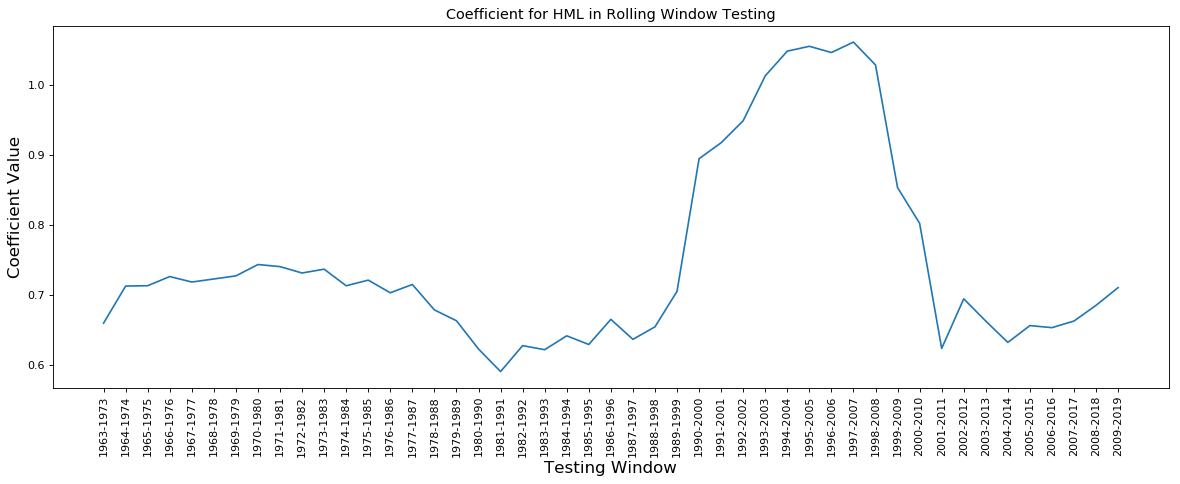

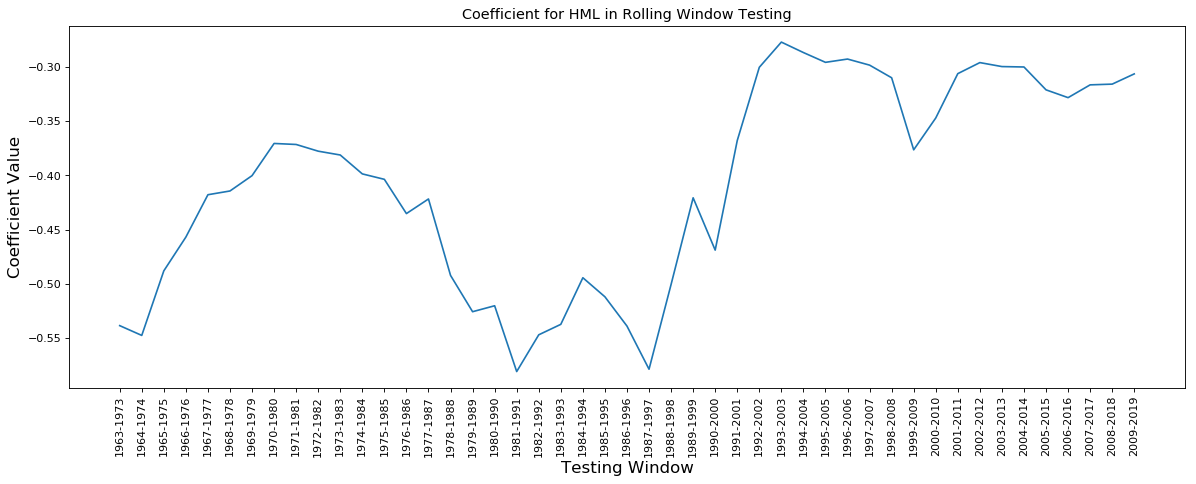

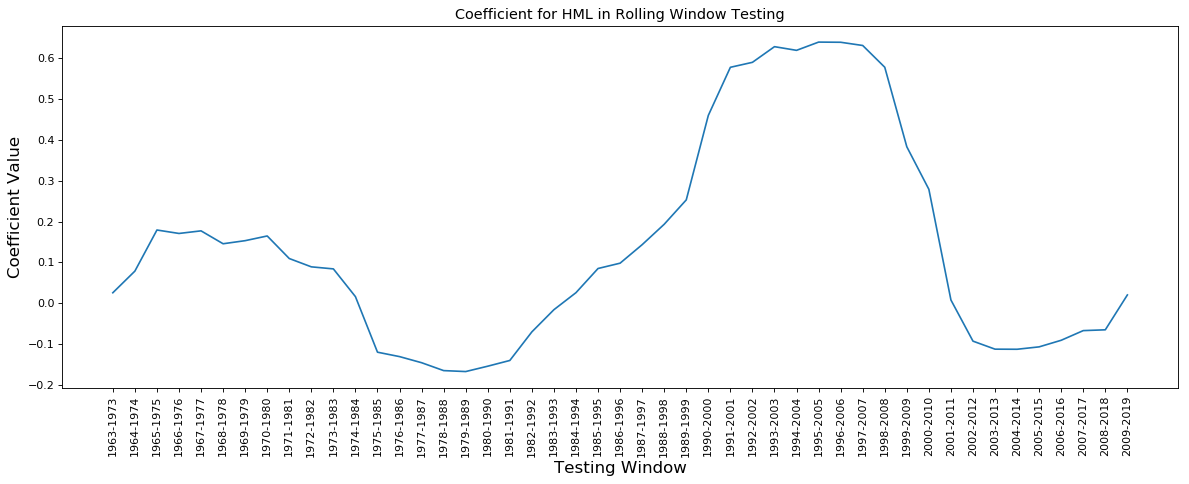

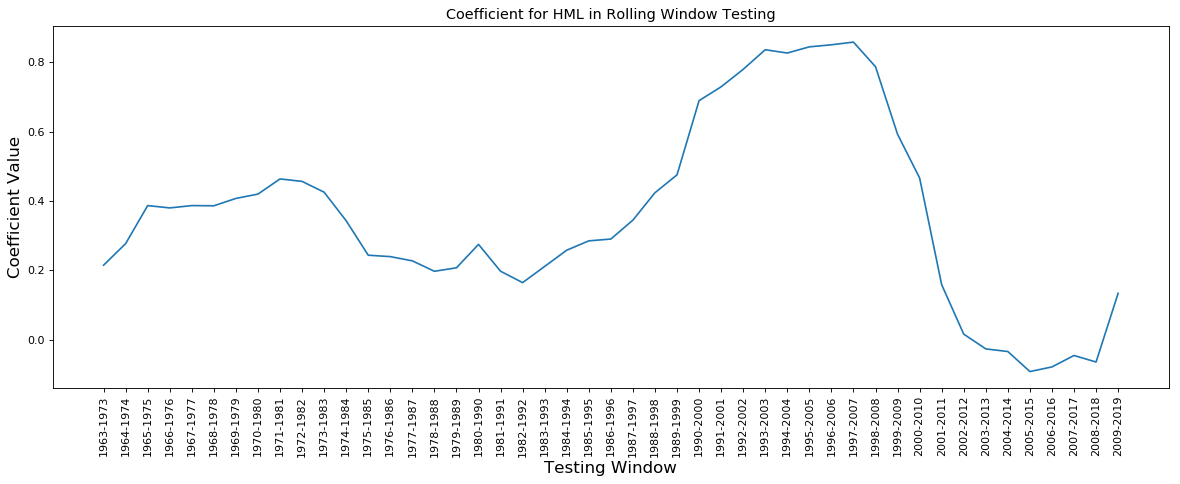

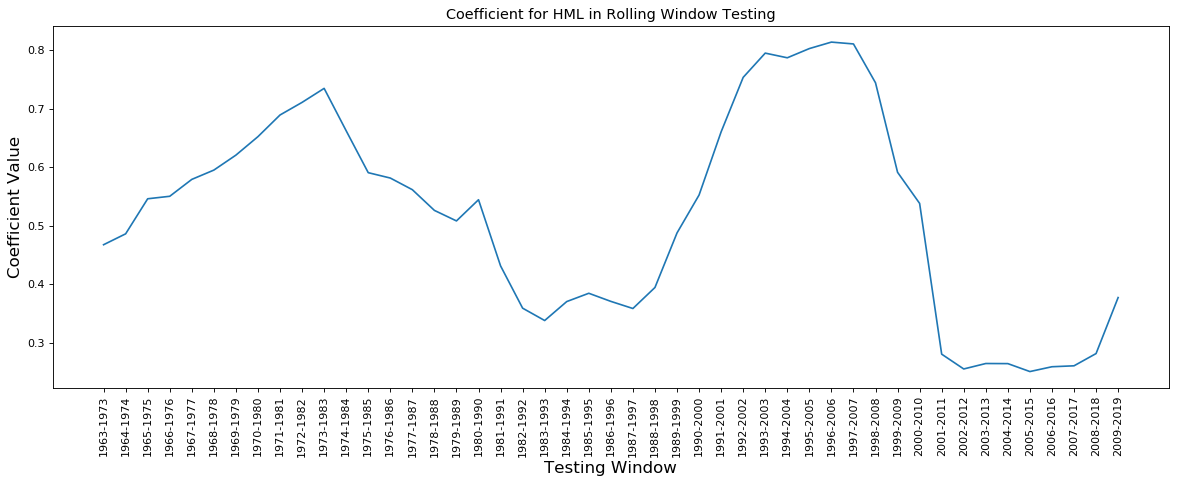

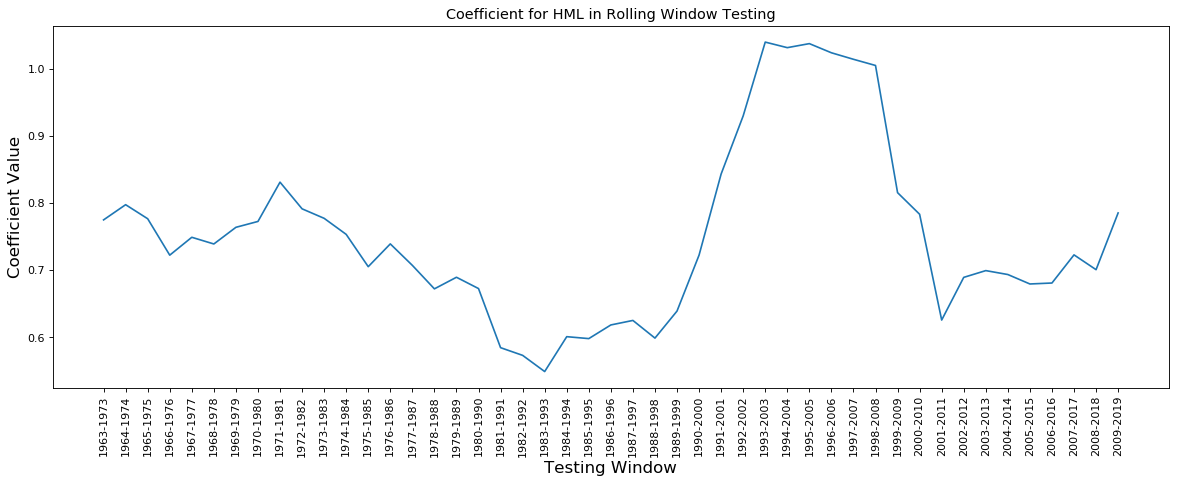

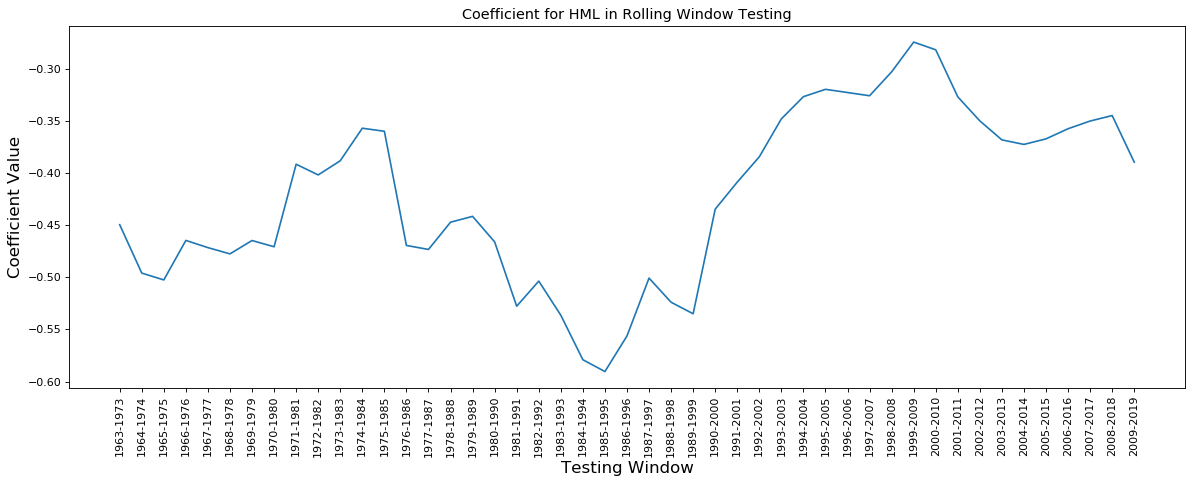

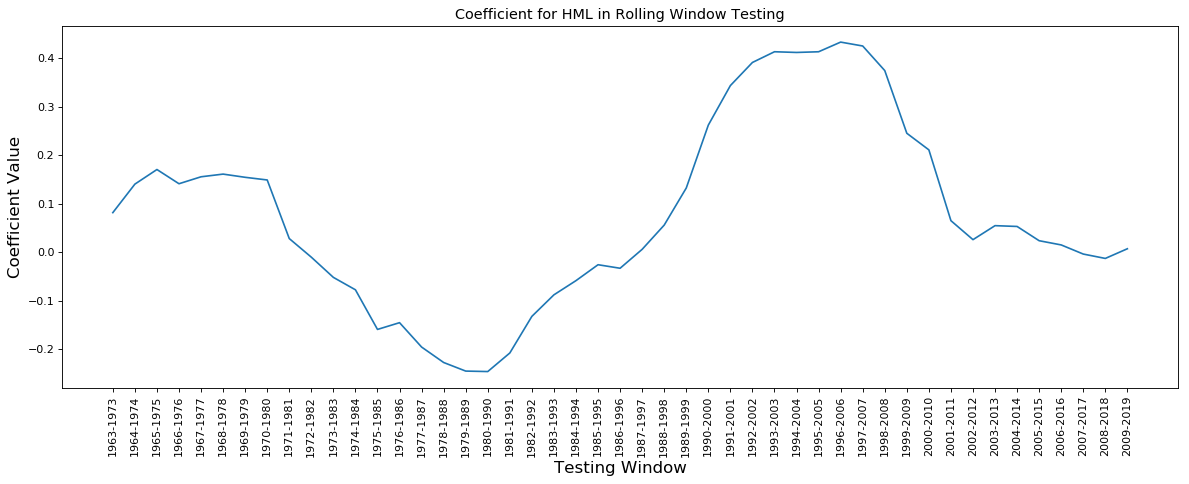

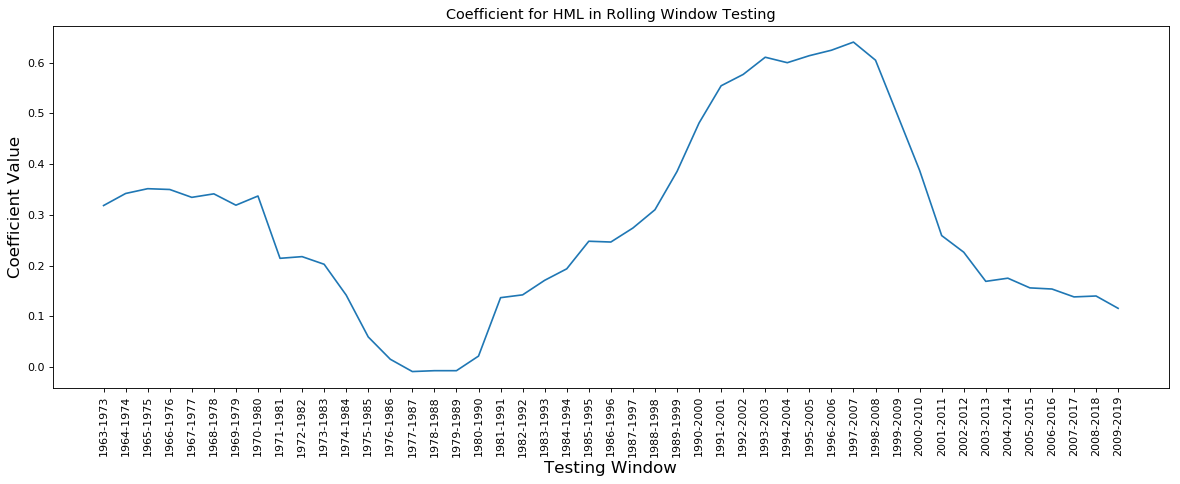

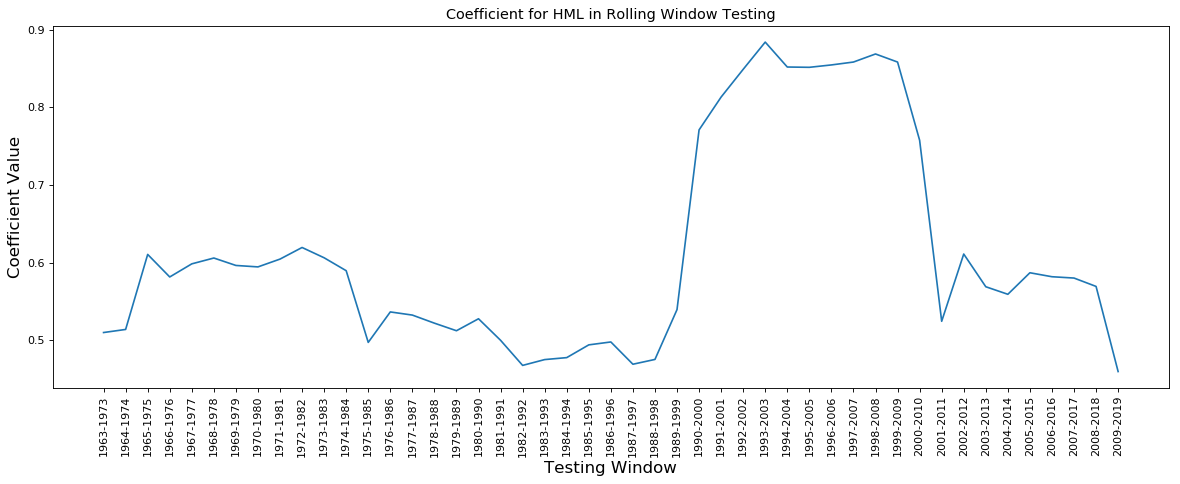

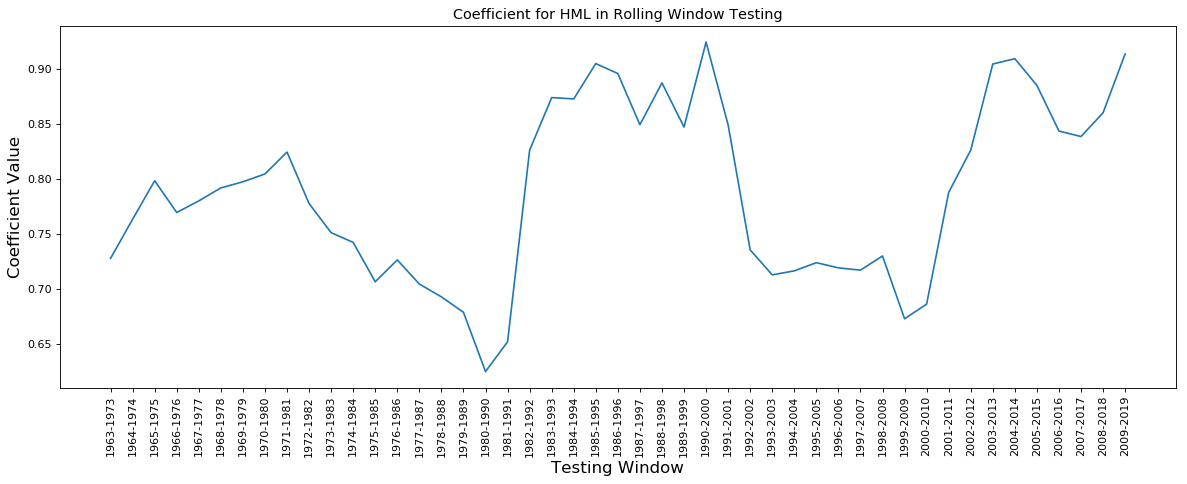

In [217]:
#In a loop, plot coeff of HML for each portfolio
for i in range(25):
    fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(HML["Portfoio{0}".format(i)])
    plt.xticks(rotation=90)
    plt.xlabel('Testing Window', size = 15)
    plt.ylabel('Coefficient Value', size = 15, rotation = 90)
    plt.title('Coefficient for HML in Rolling Window Testing', size = 13)
    plt.xticks(size = 10)